# Spectral Methods Part IV: Examples of Euler Equations and Shocks

Ernesto Barraza-Valdez, Feb 2, 2023

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is Part 4. It extends from the previous notebook and examines the Euler Gas equations and shocks.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
VERSION

v"1.10.3"

In [2]:
] activate .

  Activating project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


In [3]:
# ] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia Revise

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia
using Revise
using Pkg

# Creating a Julia Package

We need to create a package in Julia to store all our functions from Chapters 1-4. 

We can follow the following links for `Pkg.jl`: 

https://pkgdocs.julialang.org/v1/creating-packages/

and `Revise.jl`

https://timholy.github.io/Revise.jl/stable/

Where `Revise.jl` makes it easy to revise any of the source code of the package.

First we generate a package with the base package of `Pkg.jl`

Notice that in Jupyter we can use the bracket `]` to access `Pkg` mode

If you have not done this, go ahead and uncomment the below cell

In [5]:
# ] generate Part2b

A Part I directory was added. Navigating through it we can access the src directory where we will put the Chapter 1-3 code

Next we need to use a terminal app and open Julia. Navigate to this folder.

Activate a project there and add the packages needed for Chapters 1-3. 

Such as the following steps:

```
$> cd ./Part1
$> julia
```

then in Julia

```
] activate .
```
```
] add BenchmarkTools LinearAlgebra SparseArrays FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia
```

After we paste our code from the previous notebook. 

After doing the above we can import the Part1 package. First we need to add it to the scope

In [5]:
push!(LOAD_PATH, "Part2b/");


Then we just use the `using`

In [6]:
using Part2b

Part 1, and 2a functions are now fully loaded

In [5]:
# Pkg.generate("SpectralMethods")

In [6]:
# ] dev ./SpectralMethods

   Resolving package versions...
  No Changes to `/dfs6/pub/ernestob/Julia/SpectralMethods/Project.toml`
  No Changes to `/dfs6/pub/ernestob/Julia/SpectralMethods/Manifest.toml`


In [7]:
# push!(LOAD_PATH, "SpectralMethods/");


In [8]:
# ] build SpectralMethods

In [9]:
# using SpectralMethods

In [10]:
# nthreads() 

4

---------------

# Euler Gas Equations
-----------

In this section we extend the Euler Acoustic model to the full Euler Gas/Fluid model. 

The Euler Gas equations are:

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}
    \rho \\
    \rho u \\
    E
    \end{array}\right] + \frac{\partial}{\partial x} \left[ \begin{array}{cc}
    \rho u\\
    \rho u^2 + p \\
    u (E + p)
    \end{array}\right] = 0
\tag{T0}
\end{align}

Which can be re-written as:

\begin{align}
    \underline{Q} \frac{\partial }{\partial t} \bar{q} +  \frac{\partial f(\bar{q})}{\partial \bar{q}}\frac{\partial \bar{q}}{\partial x} = 0
\tag{T1}
\end{align}

Where we define the flux as:

\begin{align}
    \mathbf{F}_x = \frac{\partial}{\partial x} f(\bar{q})
\end{align}

and our Jacobian Flux as:

\begin{align}
  \underline{A} = \frac{ \partial f(\bar{q}) }{ \partial \bar{q} } = f'(\bar{q})
\tag{T3}
\end{align}

And the pressure:

\begin{align}
    P = (\gamma-1) \:\rho \: (E - \frac{1}{2} u^2)
\tag{T4}
\end{align}

With sound speed:

\begin{align}
    c = \sqrt{\frac{\gamma p}{\rho}}
\tag{T5}
\end{align}

And total energy density

\begin{align}
    \rho E =  \frac{\rho c^2 }{\gamma-1} + \frac{\rho u^2}{2} - P
\tag{T6}
\end{align}

and Enthalpy:

\begin{align}
    H = \frac{1}{\rho} ( E + p )
\tag{T7}
\end{align}


## Shocks and Moving Discontinuities

Current research with NDGSEM is simulating shocks and discontinuities. In the previous notebook, we saw how we could add stationary discontinuities into our simulation (discontinuous equilibrium density and discontinuous electric permitvity). However, space and time dependent discontinuities are another beast to handle. 

We saw that the Nodal Discontinuous Galerkin Spectral Element Method allows for discontinuities between element boundaries. However, within the element there is nothing to handle discontinuities. One can then either use very fine resolution (high number of elements) and a small number of Polynomials per element, and to assume shocks can only be between element boundaries. 

On the other hand, one can move the elements to the Discontinuity's frame of reference. This is fairly simple, but does not allow for large dispersion effects and multiple shock events. 

One more approach would be to use filtering or Flux Limitting. This has been very well studied.

In this section we use the Hybrid Blending method. Please review the following publications:

1. Hennemann, S., Rueda-Ramírez, A. M., Hindenlang, F. J., & Gassner, G. J. (2021). A provably entropy stable subcell shock capturing approach for high order split form DG for the compressible Euler equations. Journal of Computational Physics, 426, 109935.
2. Gassner, G. J., Winters, A. R., & Kopriva, D. A. (2016). Split form nodal discontinuous Galerkin schemes with summation-by-parts property for the compressible Euler equations. Journal of Computational Physics, 327, 39-66.
3. Winters, A. R., Kopriva, D. A., Gassner, G. J., & Hindenlang, F. (2021). Construction of modern robust nodal discontinuous Galerkin spectral element methods for the compressible Navier–Stokes equations. Efficient High-Order Discretizations for Computational Fluid Dynamics, 117-196.

### Numerical Flux

We've chatted about numerical fluxes in the previous notebook. Here we'll go into more depth. Conservation laws usually are thought of as energy conserving. Conservation laws also have other properties such as entropy conservation. Entropy plays a large role in the stability of a numerical methods for Hyperbolic Partial Differentia Equations, whether it's real or numerical entropy.

For higher order methods such Nodal Discontinuous Galerkin Spectral Element Method, research into numerical fluxes that allow for robustness and stability is still ongoing. Here, we will introduce **Entropy Conserving** and **Entropy Stable** fluxes for the 1D Euler Compressible Gas equations. 



We first follow Hennemann et al. Let's read this exerpt from the introduction:

> Based on a Galerkin type local finite element ansatz and a weak formulation of the underlying nonlinear problem, ideas from the finite volume methodology are applied via the so-called numerical fluxes to add stabilization for advection dominated flow problems. However, due to e.g. variational crimes caused by the insufficient integration of the highly non-linear volume and surface terms in the weak formulation and the finite dimensional approximation space, the DG scheme may still suffer critical stability issues. We roughly distinguish two stability issues: (i) the variational crimes or aliasing-driven instabilities that may cause crashes of the simulation especially in underresolved vortical driven flow fields such as e.g. turbulence; (ii) the oscillations caused by Gibbs phenomena when approximating very steep gradients or even discontinuities with high order polynomials.

As mentioned, the Gibbs phenomena is encountered for steep gradients and discontinuities. This causes fluxes to vary widely and could drive variables such as **temperature** and **density** to negative which are unphysical. This means that simulating shocks (which is a hot research topic in Fluid dynamics and plasma physics) is still very difficult. 

The main point of the paper is: 

> As we aim to keep discrete entropy stability in our approach, we adopt, extend and modify the subcell idea accordingly. First, we focus on the LGL nodes and the discretely entropy stable DGSEM as our high order baseline scheme. Next, we show how to construct a robust low order subcell scheme, that is fully compatible with the discrete entropy analysis, i.e. that is entropy stable for collocated entropy variables. We make heavy use of the very important findings presented first in [22] for high order diagonal norm summation-by-parts (SBP) operators, where it is proven that these operators can be equivalently represented as specific subcell conservative finite volume approximations. Lastly, instead of implementing a hard switch, we will show that it is possible to seamlessly blend the high order and low order variants local to each element with a blending factor $\alpha$ in a way such that the hybrid scheme is still entropy stable for arbitrary values of $\alpha$

As a list, the points are: 

- Use Higher Order Discontinuous Galerkin Spectral Element Method for the overall domain with Legendre Gauss-Lobatto Nodes
- Use higher order diagonal norm summation-by-parts (SBP) operators to split the domain into elements and subelements
- Construct a subcell (subelement) scheme (Finite Volume scheme) that is entropy stable.
- Us a blending (shock capturing) factor that determines the blending between the elements and subcells

## Implementation

We will use the 2-point flux blending method by:

Hennemann, S., Rueda-Ramírez, A. M., Hindenlang, F. J., & Gassner, G. J. (2021). A provably entropy stable subcell shock capturing approach for high order split form DG for the compressible Euler equations. Journal of Computational Physics, 426, 109935.

In [ ]:
#need to make a new struct
mutable struct EULERDG

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    FBar::AbstractArray{Float64} #flux
    FBarAlpha::AbstractArray{Float64} 
    DFbaralpha::AbstractArray{Float64}
    dF::AbstractArray{Float64} #flux
    FLext::AbstractArray{Float64} #flux on left boundary
    FRext::AbstractArray{Float64} #flux on right boundarty
    # FR::Array{Float64} #numerical flux on the right of elements
    # FL::Array{Float64} #numerical flux on left of elements
    # Qminus::AbstractArray{Float64} #flux
    # Qplus::AbstractArray{Float64} #flux

    D::AbstractArray #First derivative matrix in x
    Dx::AbstractArray #First derivative matrix in x
    M::AbstractArray{Float64} #Mass matrix (weighted)
    MD::AbstractArray{Float64} # M*D matrix
    invM::AbstractArray{Float64} #Mass matrix (weighted)
    Delta::AbstractArray{Float64} # finite difference
    B::AbstractArray{Float64} # boundary vector
    T::Float64 #threshold value
    alpha::AbstractArray{Float64}
    alphafinal::AbstractArray{Float64}
    alphamin::Float64
    alphamax::Float64
    ELeg::AbstractArray #Legendre Mode Energies

    #entropy and flux variables
    c::AbstractArray{Float64}  #speed of wave in material
    u::AbstractArray{Float64}  #impedance of wave in material
    p::AbstractArray{Float64}  #relative permattivity of material
    E::AbstractArray{Float64}  #Energy = rho*E/rho
    Beta::AbstractArray{Float64}
    rholn::AbstractArray{Float64} #Normal Vector
    rhoavg::AbstractArray{Float64}
    uavg::AbstractArray{Float64}
    u2avg::AbstractArray{Float64}
    Betaavg::AbstractArray{Float64}
    phat::AbstractArray{Float64}
    Hhat::AbstractArray{Float64}
    #external boundary values
    rhoextL::AbstractArray{Float64}
    rhoextR::AbstractArray{Float64}
    uextL::AbstractArray{Float64}  #impedance of wave in material
    pextL::AbstractArray{Float64}  #relative permattivity of material
    EextL::AbstractArray{Float64}  #Energy = rho*E/rho
    BetaextL::AbstractArray{Float64}
    uextR::AbstractArray{Float64}  #impedance of wave in material
    pextR::AbstractArray{Float64}  #relative permattivity of material
    EextR::AbstractArray{Float64}  #Energy = rho*E/rho
    BetaextR::AbstractArray{Float64}
    
    gamma::Float64 #gamma for gas
    
    EULERDG() = new()

end

In [ ]:
DGSEM = EULERDG

In [ ]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructEuler(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    # NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    N2pfluxtot = (N[1]+2)*K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        #use gauss lobatto
        x, w =  LegendreGaussLobattoNodesAndWeights(N[1], 100000, 1.0e-9); #LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];
    NDG.M = diagm(NDG.wk[1])
    NDG.invM = inv(NDG.M)
    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    

    #derivative matrix
    Dxx = PolynomialDerivativeMatrix(xi[1])
    NDG.Dx = Dxx
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.D = Dhat[1];
    NDG.MD = NDG.M*NDG.Dx

    delta = zeros(Float64, (N[1]+1,N[1]+2))
    for i in 1:NN+1
        for j in 1:NN+2
            delta[i,i] = 1.0
            delta[i,i+1] = -1.0
        end
    end
    NDG.Delta = delta
    
    xreal = zeros(Float64, Ntot)
    
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] .= Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))
    NDG.ELeg = zeros(Float64, K)
    NDG.alpha = zeros(Float64, K) 
    NDG.alphafinal = zeros(Float64, K) 

    NDG.F =zeros(Float64, (Ntot, Nvec))
    NDG.dF = zeros(Float64, ((N[1]+1), Nvec))
    NDG.FBar = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.FBarAlpha = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.DFbaralpha = zeros(Float64, ((N[1]+1), Nvec))
    
    NDG.QRext = zeros(Float64, Nvec)
    NDG.QLext = zeros(Float64,Nvec)
    NDG.FRext = zeros(Float64,Nvec)
    NDG.FLext = zeros(Float64,Nvec)

    NDG.u = zeros(Float64, Ntot)
    NDG.p = zeros(Float64, Ntot)
    NDG.E = zeros(Float64, Ntot)
    NDG.Beta = zeros(Float64, Ntot)
    NDG.rhoextL = [0.0]
    NDG.uextL = [0.0]
    NDG.pextL = [0.0]
    NDG.EextL = [0.0]
    NDG.BetaextL = [0.0]
    NDG.rhoextR = [0.0]
    NDG.uextR = [0.0]
    NDG.pextR = [0.0]
    NDG.EextR = [0.0]
    NDG.BetaextR = [0.0]

    NDG.T = 0.5*10.0^(-1.8 * (N[1]+1)^(1.0/4.0))
    NDG.alphamin = 0.0001
    NDG.alphamax = 0.5#1.0

    return xreal

end

In [ ]:
#bar{f}_j^alpha
# f0a = f0
# fN+1a = fN
# fja = a*fstar(j-1,j) + (1-a)*bar{fj} from j =1->N
# bar{fj} = sum(k=j,N) sum(l=0,j-1) ( 2*Qlk fstarS(l,k) ) from j=1->N
# fstarS(l,k) = FEC(l,k) = [ rholn*{{u}} , rholn*{{u}}^2 + phat^2 , rholn*{{u}}*Hhat  ]
# bar{f0} = f0
# bar{fN+1} = fN

function CalculateUPEBeta!(Q::AbstractArray, u::AbstractArray, E::AbstractArray, p::AbstractArray, Beta::AbstractArray, gamma::Float64 )

    @. u =  Q[:,2]/Q[:,1]
    @. E = Q[:,3]/Q[:,1]
    @. p = (gamma - 1) * Q[:,1] * (E - u^2/2.0  )
    @. Beta = Q[:,1]/(2.0*p)#exp( -gamma * log(Q[:,1]) + log(gamma*Q[:,1])  )

    return nothing

end



In [ ]:
function EulerFlux!(NDG::DGSEM)
    #calculates the euler flux
    #drho/dt = df1/dx = rho*u
    #d(rho*u)/dt = df2/dx = rho*u^2 + p
    #d(rho*E)/dt = u*(rho*E + p)
    @. NDG.F[:,1] = NDG.Q[:,2] # rho*u
    @. NDG.F[:,2] = NDG.Q[:,1] * NDG.u^2 + NDG.p
    @. NDG.F[:,3] = NDG.u * (NDG.Q[:,1]*NDG.E + NDG.p)

    #external fluxes
    NDG.FLext[1] = NDG.QLext[2]
    NDG.FLext[2] = NDG.QLext[1]*NDG.uextL[1]^2 + NDG.pextL[1]
    NDG.FLext[3] = NDG.uextL[1] * (NDG.QLext[1]*NDG.EextL[1] + NDG.pextL[1])
    NDG.FRext[1] = NDG.QRext[2]
    NDG.FRext[2] = NDG.QRext[1]*NDG.uextR[1]^2 + NDG.pextR[1]
    NDG.FRext[3] = NDG.uextR[1] * (NDG.QRext[1]*NDG.EextR[1] + NDG.pextR[1])

    return nothing

end

In [ ]:
function calculateLegE(v1::AbstractArray, v2::AbstractArray, x::Array{Float64}, w::AbstractArray, m::Int64)
    #calculates the Legendre Transform Mode Energy
    #for the multiplied vectors v1*v2
    #and finds maximum energy between the mth mode and the (m-1)th mode
    v = v1.*v2
    Legv = LegendreTransformNaive(v, x, w)
    m2 = Legv.^2
    m2N = sum(m2[1:m])
    m2Nm1 = sum(m2[1:m-1])

    maxmE = maximum( [ m2[m]/m2N, m2[m-1]/m2Nm1])#, m2[mode-1]/m2Nm1  ])

    return maxmE
    

end

In [ ]:
function CalcLegEelement!(NDG::DGSEM, eindex::Array{Int64}, m::Int64)
    #calculates the Legendre Energy for each element
    K = NDG.K
    N = NDG.N[1]
    #calculate Legendre Mode Energies for each element
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        #right boundary index
        r = eindex[2*k]
        #calculate energy legendre mode
        NDG.ELeg[k] = calculateLegE(NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)#NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)

    end
    return nothing

end

In [ ]:
function calcAlpha(E::Float64, T::Float64,s::Float64, alphamin::Float64, alphamax::Float64)
    #calculates the initial alpha given the Legendre Energy
    #s = 9.21024
    #alpha on current element(left)
    alpha = 1.0/( 1.0 + exp(  -(s/T)*( E - T  )))

    #tilde{alpha}
    talpha = 0.0

    if alpha < alphamin
        talpha = 0.0
    elseif alphamin <= alpha <= 1-alphamin
        talpha = alpha
    elseif alpha>1-alphamin
        talpha=1.0
    end

    alpha = minimum([talpha,alphamax])
    
    return alpha

end

function calcFinalAlpha(alpha::AbstractArray)
    #calculates Final Alpha which is the maximum between element's alpha and neighboring elements' alpha
    #first index needs to be the alpha for current element
    alphafinal = alpha[1]

    for i in 1:length(alpha)
        alphafinal = maximum([alphafinal, 0.5*alpha[i]])
    
    end
    return alphafinal

end

In [ ]:
#calculate alpha for each element
function CalcAlphaelement!(NDG::DGSEM, eindex::Array{Int64},s::Float64)
    #Calcualtes initial alpha for each element
    K = NDG.K
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        #right boundary index
        r = eindex[2*k]
        #calculate energy legendre mode
        NDG.alpha[k] = calcAlpha(NDG.ELeg[k], NDG.T, s, NDG.alphamin, NDG.alphamax)

    end
    return nothing
end

In [ ]:
#calculate alpha final for each element
function CalcAlphaFinalelement!(NDG::DGSEM, eindex::Array{Int64})
    #calculates final alpha for each element
    K = NDG.K
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        #right boundary index
        r = eindex[2*k]
        #calculate energy legendre mode
        if k==1
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k+1] ])
        elseif k ==K
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k-1]]) 
        else
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k-1], NDG.alpha[k+1]  ]) 
        end

    end
    return nothing
end

```

!==================================================================================================================================
!> Computes the logarithmic mean: (aR-aL)/(LOG(aR)-LOG(aL)) = (aR-aL)/LOG(aR/aL)
!> Problem: if aL~= aR, then 0/0, but should tend to --> 0.5*(aR+aL)
!>
!> introduce xi=aR/aL and f=(aR-aL)/(aR+aL) = (xi-1)/(xi+1)
!> => xi=(1+f)/(1-f)
!> => Log(xi) = log(1+f)-log(1-f), and for smaRl f (f^2<1.0E-02) :
!>
!>    Log(xi) ~=     (f - 1/2 f^2 + 1/3 f^3 - 1/4 f^4 + 1/5 f^5 - 1/6 f^6 + 1/7 f^7)
!>                  +(f + 1/2 f^2 + 1/3 f^3 + 1/4 f^4 + 1/5 f^5 + 1/6 f^6 + 1/7 f^7)
!>             = 2*f*(1           + 1/3 f^2           + 1/5 f^4           + 1/7 f^6)
!>  (aR-aL)/Log(xi) = (aR+aL)*f/(2*f*(1 + 1/3 f^2 + 1/5 f^4 + 1/7 f^6)) = (aR+aL)/(2 + 2/3 f^2 + 2/5 f^4 + 2/7 f^6)
!>  (aR-aL)/Log(xi) = 0.5*(aR+aL)*(105/ (105+35 f^2+ 21 f^4 + 15 f^6)
!==================================================================================================================================
PURE FUNCTION LN_MEAN(aL,aR)
! MODULES
IMPLICIT NONE
!----------------------------------------------------------------------------------------------------------------------------------
! INPUT VARIABLES
REAL,INTENT(IN) :: aL  !< left value
REAL,INTENT(IN) :: aR  !< right value
!----------------------------------------------------------------------------------------------------------------------------------
! INPUT / OUTPUT VARIABLES
REAL            :: LN_MEAN  !< result
!----------------------------------------------------------------------------------------------------------------------------------
! LOCaR VaLIABLES
REAL           :: Xi,u
REAL,PARAMETER :: eps=1.0E-4  ! tolerance for f^2, such that switch is smooth in double precision
!==================================================================================================================================
Xi = aR/aL
u=(Xi*(Xi-2.)+1.)/(Xi*(Xi+2.)+1.) !u=f^2, f=(aR-aL)/(aR+aL)=(xi-1)/(xi+1)
LN_MEAN=MERGE((aL+aR)*52.5d0/(105.d0 + u*(35.d0 + u*(21.d0 +u*15.d0))), & !u <eps (test true)
              (aR-aL)/LOG(Xi)                                         , & !u>=eps (test false)
              (u.LT.eps)                                              )   !test
END FUNCTION LN_MEAN

```

In [ ]:
#Ln Mean
function LnMean(aL::Float64, aR::Float64, eps=1.0e-4)
    #ln mean forthe left and right variable. 
    #Ln mean is not defined when aL~aR so need to use expansion
    Xi = aR/aL
    u = 0.0
    Ln_Mean = 0.0

    u = (Xi*(Xi-2.)+1.)/(Xi*(Xi+2.)+1.) # u=f^2, f=(aR-aL)/(aR+aL)=(xi-1)/(xi+1)

    # LN_MEAN = MERGE((aL+aR)*52.5/(105.0 + u*(35.0 + u*(21.0 +u*15.0))), & #u <eps (test true)
    #           (aR-aL)/LOG(Xi)                                         , & # u>=eps (test false)
    #           (u.LT.eps)                                              )   # test
    
    if u<eps
        Ln_Mean = (aL+aR)*52.5/(105.0 + u*(35.0 + u*(21.0 +u*15.0)))
    elseif u>=eps
        Ln_Mean = (aR-aL)/log(Xi)
    end

end

In [ ]:

function EntropyConservingFlux(gamma::Float64, rhoj::Float64,rhok::Float64, uj::Float64,uk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
    #Entropy Conserving numerical flux given left and right state
    # eps = 1.0e-9
    rhoavg = (rhoj + rhok)/2.0
    rhodif = rhok-rhoj
    rholn = LnMean(rhok,rhoj)

    Betaavg = (Betak + Betaj)/2.0
    Betadif = (Betak - Betaj)
    Betaln = LnMean(Betak,Betaj)
    
    invBetadif = (1.0/Betak - 1.0/Betaj)
    
    uavg = (uk + uj)/2.0
    udif = (uk-uj)
    u2avg = (uk^2 + uj^2)/2.0
    
    rhoudif = (rhok*uk - rhoj*uj)

    phat = rhoavg/2.0/Betaavg
    
    Hhat = 1/(2.0*(gamma-1)*Betaln ) - 0.5*u2avg + phat/rholn + uavg^2

    Fec = [ rholn*uavg, rholn*uavg^2 + phat, rholn*uavg*Hhat ]

    return Fec

end

In [ ]:
function EntropyStableFlux(gamma::Float64, rhoj::Float64,rhok::Float64, uj::Float64,uk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
    #Entropy Stable Flux given left and right state
    # eps = 1.0e-9
    rhoavg = (rhoj + rhok)/2.0
    rhodif = rhok-rhoj
    rholn = LnMean(rhok,rhoj)
    # if abs(rhodif) > eps
    #     rholn = rhodif/(log(rhok)-log(rhoj))
    # end

    Betaavg = (Betak + Betaj)/2.0
    Betadif = (Betak - Betaj)
    Betaln = LnMean(Betak,Betaj)
    invBetadif = (1.0/Betak - 1.0/Betaj)
    
    uavg = (uk + uj)/2.0
    udif = (uk-uj)
    u2avg = (uk^2 + uj^2)/2.0
    
    rhoudif = (rhok*uk - rhoj*uj)

    phat = rhoavg/2.0/Betaavg
    
    Hhat = 1/(2.0*(gamma-1)*Betaln ) - 0.5*u2avg + phat/rholn + uavg^2

    Fec = [ rholn*uavg, rholn*uavg^2 + phat, rholn*uavg*Hhat ]

    #sound speed
    ck = sqrt(gamma*pk/rhok)
    cj = sqrt(gamma*pj/rhoj)

    lambdamax = maximum([ (abs(uk)+ck) , (abs(uj) + cj) ])

    Fes1 = Fec[1] - lambdamax/2.0 * rhodif
    Fes2 = Fec[2] - lambdamax/2.0 * rhoudif
    Fes3 = Fec[3]- lambdamax/2.0 * ( ( 1/(2.0*Betaln*(gamma-1)) + 0.5*uj*uk)*rhodif + rhoavg*uavg*udif + rhoavg*invBetadif/(2.0*(gamma-1) )  )

    return [Fes1, Fes2, Fes3]

end

In [ ]:
function FluxBarj(Fbar::AbstractArray, F::AbstractArray, MD::AbstractArray, N::Int64, rho::AbstractArray, u::AbstractArray, E::AbstractArray, p::AbstractArray, Beta::AbstractArray, gamma::Float64)
    #calculates the Polynomial Derivative of the Entropy Conserving Flux
    Fbar[1,:] .= F[1,:]
    Fbar[end,:] .= F[end,:]
    Fstar = zeros(Float64, 3)
    fj = zeros(Float64,3)
    for j in 1:N
        n = j+1
        @. fj = 0.0
        for kk in j:N
            k = kk+1
            for ll in 0:j-1
                l = ll+1
                Fstar = EntropyConservingFlux(gamma, rho[l],rho[k], u[l],u[k], E[l], E[k], p[l], p[k], Beta[l], Beta[k])
                fj[1] = fj[1] + 2.0*MD[l,k]*Fstar[1]
                fj[2] = fj[2] + 2.0*MD[l,k]*Fstar[2]
                fj[3] = fj[3] + 2.0*MD[l,k]*Fstar[3]

            end
        end
        
        Fbar[n,:] .=  fj

    end
    return nothing

end

In [ ]:
# calculate flux bar for each element
function CalcFluxBarelement!(NDG::DGSEM, eindex::Array{Int64},eindex2::Array{Int64})
    #The Volumetric flux of element and subcells
    K = NDG.K
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        l2 = eindex2[2*k-1]
        #right boundary index
        r = eindex[2*k]
        r2 = eindex2[2*k]
        
        #get flux bar
        FluxBarj(@view(NDG.FBar[l2:r2,:]), NDG.F[l:r,:], NDG.MD, NDG.N[1], NDG.Q[l:r,1], NDG.u[l:r], NDG.E[l:r], NDG.p[l:r], NDG.Beta[l:r], NDG.gamma)
        
    end
    return nothing
end

In [ ]:
function FluxBarAlpha(alpha::Float64, FbarAlpha::AbstractArray, Fbar::AbstractArray, F::AbstractArray, MD::AbstractArray, N::Int64, rho::AbstractArray, u::AbstractArray, E::AbstractArray, p::AbstractArray, Beta::AbstractArray, gamma::Float64)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux
    FbarAlpha[1,:] .= F[1,:]
    FbarAlpha[end,:] .= F[end,:]
    Fstar = zeros(Float64, 3)
    fj = zeros(Float64,3)
    for jj in 1:N
        j = jj+1
        Fstar = EntropyStableFlux(gamma, rho[j-1],rho[j], u[j-1],u[j], E[j-1], E[j], p[j-1], p[j], Beta[j-1], Beta[j])
        FbarAlpha[j,:] .=  alpha*Fstar + (1-alpha)*Fbar[j,:]

    end
    return nothing

end

In [ ]:
# calculate flux BAR ALPHA for each element
function CalcFluxBarAlpha!(NDG::DGSEM, eindex::Array{Int64},eindex2::Array{Int64})
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux for each element
    K=NDG.K
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        l2 = eindex2[2*k-1]
        #right boundary index
        r = eindex[2*k]
        r2 = eindex2[2*k]
        #get flux bar alpha
        FluxBarAlpha(NDG.alphafinal[k], @view(NDG.FBarAlpha[l2:r2,:]), NDG.FBar[l2:r2,:], NDG.F[l:r,:], NDG.MD, NDG.N[1],  NDG.Q[l:r,1], NDG.u[l:r], NDG.E[l:r], NDG.p[l:r], NDG.Beta[l:r], NDG.gamma)
        
        
    end
    return nothing
end

In [ ]:
#Add boundary fluxes
function CalcBoundaryFluxelement!(NDG::DGSEM, eindex::Array{Int64},eindex2::Array{Int64})
    #Element Boundary Entropy Stable Flux
    K=NDG.K
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        l2 = eindex2[2*k-1]
        #right boundary index
        r = eindex[2*k]
        r2 = eindex2[2*k]
        #check if left boundary use external left flux and right flux from next eelement
        # EntropyStableFlux(gamma::Float64, rhoj::Float64,rhok::Float64, uj::Float64,uk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
        if k==1
            NDG.FLext .= EntropyStableFlux(NDG.gamma, NDG.QLext[1],NDG.Q[l,1], NDG.uextL[1],NDG.u[l], NDG.EextL[1], NDG.E[l], NDG.pextL[1], NDG.p[l], NDG.BetaextL[1], NDG.Beta[l])
            
            NDG.FRext .= EntropyStableFlux(NDG.gamma, NDG.Q[r,1], NDG.Q[r+1,1], NDG.u[r], NDG.u[r+1], NDG.E[r], NDG.E[r+1],  NDG.p[r], NDG.p[r+1],  NDG.Beta[r], NDG.Beta[r+1] )
        #if right boundary use external right flux and left element flux
        elseif k==K
            NDG.FRext .= EntropyStableFlux(NDG.gamma, NDG.Q[r,1], NDG.QRext[1], NDG.u[r], NDG.uextR[1], NDG.E[r], NDG.EextR[1],  NDG.p[r], NDG.pextR[1],  NDG.Beta[r], NDG.BetaextR[1] )
            
            NDG.FLext .= EntropyStableFlux(NDG.gamma, NDG.Q[l-1,1], NDG.Q[l,1],  NDG.u[l-1], NDG.u[l], NDG.E[l-1], NDG.E[l], NDG.p[l-1],   NDG.p[l], NDG.Beta[l-1],  NDG.Beta[l])
        else
            NDG.FLext .= EntropyStableFlux(NDG.gamma, NDG.Q[l-1,1], NDG.Q[l,1],  NDG.u[l-1], NDG.u[l], NDG.E[l-1], NDG.E[l], NDG.p[l-1],   NDG.p[l], NDG.Beta[l-1],  NDG.Beta[l])
            NDG.FRext .= EntropyStableFlux(NDG.gamma, NDG.Q[r,1], NDG.Q[r+1,1], NDG.u[r], NDG.u[r+1], NDG.E[r], NDG.E[r+1],  NDG.p[r], NDG.p[r+1],  NDG.Beta[r], NDG.Beta[r+1] )
        end
        
        NDG.FBarAlpha[l2,:] .=  NDG.FLext
        NDG.FBarAlpha[r2,:] .= NDG.FRext
    end
    return nothing

end

In [ ]:
function LocalTimeDerivative!(NDG::DGSEM, l2::Int64,r2::Int64)
    #Time Derivative of Each Element
    # dQ/dt = M^-1 * Delta * Flux
    #Delta * fbaralpha
    NDG.DFbaralpha[:,1] .= NDG.Delta*NDG.FBarAlpha[l2:r2,1]
    NDG.DFbaralpha[:,2] .= NDG.Delta*NDG.FBarAlpha[l2:r2,2]
    NDG.DFbaralpha[:,3] .= NDG.Delta*NDG.FBarAlpha[l2:r2,3]
    #M^-1 * (Delta *fbaralpha)
    NDG.dF[:,1] .= NDG.invM*NDG.DFbaralpha[:,1]
    NDG.dF[:,2] .= NDG.invM*NDG.DFbaralpha[:,2]
    NDG.dF[:,3] .= NDG.invM*NDG.DFbaralpha[:,3]
end

In [ ]:
#alg 93
function DGSEM1DGlobalTimeDerivativeEul!(NDG::DGSEM, t::Float64,  eindex::Array{Int64}, eindex2::Array{Int64}, ExternalState::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    #alpha parameter
    s = NDG.c[2] #9.21024
    #get external boundaries
    #left
    NDG.QLext = ExternalState(NDG.Q[1,:], -1.0, NDG.xk[1], t, "LEFT")
    #right
    NDG.QRext = ExternalState(NDG.Q[end,:], 1.0, NDG.xk[end], t, "RIGHT")

    #get primitive variables
    CalculateUPEBeta!(NDG.Q, NDG.u, NDG.E, NDG.p, NDG.Beta, NDG.gamma )
    #primitive for boundaries
    CalculateUPEBeta!(transpose(NDG.QLext), NDG.uextL, NDG.EextL, NDG.pextL, NDG.BetaextL, NDG.gamma)
    CalculateUPEBeta!(transpose(NDG.QRext), NDG.uextR, NDG.EextR, NDG.pextR, NDG.BetaextR, NDG.gamma)
    
    #calculate regular Euler flux
    EulerFlux!(NDG)

    #calculate Legendre Mode Energies for each element
    #Legendre mode
    mode = floor(Int64, NDG.c[1])
    CalcLegEelement!(NDG, eindex,mode )

    #calculate alpha for each element
    CalcAlphaelement!(NDG, eindex, s)

    #calculate alpha final for each element
    CalcAlphaFinalelement!(NDG, eindex)


    # calculate flux bar for each element
    CalcFluxBarelement!(NDG, eindex,eindex2)

    # calculate flux BAR ALPHA for each element
    CalcFluxBarAlpha!(NDG, eindex,eindex2)

    #Add boundary fluxes
    CalcBoundaryFluxelement!(NDG, eindex,eindex2)

    
    
    #calculate d/dx (Fbaralpha)
    for k in 1:K
        #left boundary index
        l = eindex[2*k-1]
        l2 = eindex2[2*k-1]
        #right boundary index
        r = eindex[2*k]
        r2 = eindex2[2*k]

        @. NDG.dF= 0.0
        @. NDG.DFbaralpha = 0.0
        @. NDG.dF = 0.0
        #set boundary fluxes to flux bar alpha
        
        #Delta * fbaralpha
        #M^-1 * (Delta *fbaralpha)
        LocalTimeDerivative!(NDG, l2,r2)
               
        NDG.dQ[l:r, :] .= 2.0.*NDG.dF ./ NDG.dxk[k]
            
        
    end

    
end

In [ ]:
#SLOPE LIMITER
function minmod(N::Int64,qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)

    m = 3
    mfunc = zeros(Float64, N+1)
    #sum
    s = [ sign(qx[j])+sign(qavgR[j])+sign(qavgL[j])   for j in 1:N+1]./m
    #find if close to |s|=1
    s1 = abs.(s) .- 1.0

    for j in 1:N+1
        
        if (abs(s1[j]) < eps) 
            mfunc[j] = s[j]*minimum([ qx[j],qavgR[j],qavgL ])
        end
            
    end        
    
    
    return mfunc  

end

In [ ]:
#slope limit linear 
function SlopeLimitLin(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray)

    #vl: cell left average
    #vc: cell center average
    #vr: cell right average

    
    h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
    #center point of element
    x0 = @. xk[1] + h/2.0#zeros(Float64,K)
    hN = h
    #limit function derivative
    qx = 2.0 ./hN .* (Dx*qk)

    vright = @. (vr-vc)/h
    vleft = @. (vc-vl)/h

    qlimit = @. vc + (xk-x0)*minmod(qk, vright, vleft )

    return qlimit

end

In [ ]:
# function SlopeLimit1(NDG::DGSEM, pk::EPKD, eindex::Array{Int64})

#     N = NDG.N[1]
#     K = NDG.K
#     # q1 = NDG.Q[:,1]
#     # q2 = NDG.Q[:,1]
#     # q3 = NDG.Q[:,1]
#     qlimit = zeros(Float64,size(NDG.Q))

#     #define left, center, and right averages
#     vavgR = zeros(Float64, length(NDG.Q[:,1]))
#     vavgL = zeros(Float64, length(NDG.Q[:,2]))
#     vavgC = zeros(Float64, length(NDG.Q[:,3]))

#     for n in 1:NDG.Neqn #loop through each variable
#         q = NDG.Q[:,n]
#         #calculate right, left, and center averages
#         vavgR =  [ ( @. (q[1:end-1]+q[2:end])/2.0) ; [q[end]]]
#         vavgL = [ [q[1]] ; (@. (q[1:end-1]+q[2:end])/2.0) ]
#         vavgC = [[q[1]] ; (@. (q[k]+q[k+2])/2.0 for k in 1:K-2 ) ; [q[end]]]
        
#         for k in 1:K
#             #left boundary index
#             l = eindex[2*k-1]
#             #right boundary index
#             r = eindex[2*k]
            
#             qlimit[l:r,n] .= SlopeLimitLin(q[l:r], NDG.xreal[l:r], K, N, NDG.Dhat[k], vavgL[l:r], vavgC[l:r], vavgR[l:r])
    
#         end
#     end

#     return qlimit
    

# end

In [ ]:
# function minmodB( N::Int64, m::Float64, M::Float64, h::AbstractArray, qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)

#     m = 3
#     h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
#     # mfunc = qx

#     #find all that satisfy |mfunc| > M*h^2
#     idscount = 0
#     for i in 1:length(qx)
#         if abs(mfunc[i]) > M*h[i]^2
#             idscount = idscount+1
#         end
#     end

#     if idscount >0
#         mfunc = zeros(Float64, N+1)
#         #sum
#         s = [ sign(qx[j])+sign(qavgR[j])+sign(qavgL[j])   for j in 1:N+1]./m
#         #find if close to |s|=1
#         s1 = abs.(s)-1.0
    
#         for j in 1:N+1
            
#             if (abs(s1[j]) < eps) 
#                 mfunc[j] = s[j]*minimum([ qx[j],qavgR[j],qavgL ])
#             end
                
#         end  
#     end
    
#     return mfunc  
    

# end

In [ ]:
# function SlopeLimitLinB(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray, M::Float64)

#     #vl: cell left average
#     #vc: cell center average
#     #vr: cell right average

    
#     h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
#     #left h=dxL
#     hL = [ [2.0*(xk[2]-xk[1])] ; h  ]
#     #right h=dxR
#     hR = [ h ; [ 2.0*(xk[end]-xk[end-1])] ]
#     #center point of element
#     x0 = @. xk[1] + h/2.0#zeros(Float64,K)
#     hN = h
#     #limit function derivative
#     qx = 2.0 ./hN .* (Dx*qk)

#     vright = @. (vr-vc)/hR
#     vleft = @. (vc-vl)/hL
#     #minmodB( N::Int64, m::Float64, M::Float64, h::AbstractArray, qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)
#     qlimit = @. vc + (xk-x0)*minmodB(N, 3.0, M, qk, vright, vleft )

#     return qlimit

# end

In [ ]:
# function SlopeLimitN!(NDG::DGSEM, pk::EPKD, eindex::Array{Int64}, M::Float64, eps=1.0e-9)

#     N = NDG.N[1]
#     K = NDG.K
#     q = NDG.Q
#     qlimit = zeros(Float64,size(q))

#     #define left, center, and right averages
#     #going to be the same for all except the added ends
#     qlimit = zeros(Float64,size(NDG.Q))

#     #define left, center, and right averages
#     vavgR = zeros(Float64, length(NDG.Q[:,1]))
#     vavgL = zeros(Float64, length(NDG.Q[:,1]))
#     vavgC = zeros(Float64, length(NDG.Q[:,1]))

#     #reconstruction 
#     ve1 = zeros(Float64,N+1)
#     ve2 = zeros(Float64,N+1)

#     for n in 1:NDG.Neqn #loop through each variable
#         q = NDG.Q[:,n]
#         #calculate right, left, and center averages
#         vavgR .=  [ ( @. (q[1:end-1]+q[2:end])/2.0) ; [q[end]]]
#         vavgL .= [ [q[1]] ; (@. (q[1:end-1]+q[2:end])/2.0) ]
#         vavgC .= [[q[1]] ; [ (q[k]+q[k+2])/2.0 for k in 1:length(q)-2  ] ; [q[end]]]
        
#         for k in 1:K
#             #left boundary index
#             l = eindex[2*k-1]
#             #right boundary index
#             r = eindex[2*k]
#             #end points of element
#             ue1 = q[l]
#             ue2 = q[r]
            
#             ve1 .= vavgC[l:r]  .- minmod(N, (vavgC[l:r] .- ue1), (@. vavgC[l:r]-vavgL[l:r] ), (@. vavgR[l:r]-vavgC[l:r] ), 1.0e-9)
#             ve2 .= vavgC[l:r]  .+ minmod(N, (ue2 .- vavgC[l:r]), (@. vavgC[l:r]-vavgL[l:r] ), (@. vavgR[l:r]-vavgC[l:r] ), eps)

#             #check to see if there's any |ve1-ue1|>eps and |ve2-ue1|>eps
#             vemue1 = abs.(ve1 .- ue1)
#             vemue2 = abs.(ve2 .- ue2)

#             for i in 1:N+1
#                 if (vemue1[i] > eps) || (vemue2[i] > eps)
#                     #SlopeLimitLinB(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray, M::Float64)
#                     qlimit[l:r,n] .= SlopeLimitLinB(q[l:r], NDG.xreal[l:r], K, N, NDG.Dhat[k], vavgL[l:r], vavgC[l:r], vavgR[l:r],M)
#                 end

#             end
            
#         end
#     end

#     @. NDG.Q = qlimit 

#     return nothing
    
# end

In [ ]:
# # #alg 62
# function DGSEMstep1DRK3EulerFLimit!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

#     N = NDG.N
#     K = NDG.K
#     Neqn = NDG.Neqn
    
#     am = [0.0; -5.0/9.0; -153.0/128.0]
#     bm = [0.0; 1.0/3.0; 0.75]
#     gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
#     t = 0.0
#     #N = length(Phi)
#     #Phij = copy(Phi)
#     #DPhi = zeros(Float64, size(Phi))
#     #G = zeros(Float64, size(Phi))
#     # @. NDG.G = 0.0

#     #apply flux limiter
#     M = 1.0e3
#     SlopeLimitN!(NDG, pk, eindex, M, 1.0e-9)

#     for m in 1:3
#         t = tn +bm[m]*dt #update time
#         #gt = g(t) #boundary condition in time
#         #time derivative
#         DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
#         # @. G = am[m]*G + DPhi
#         @. NDG.G = am[m]*NDG.G + NDG.dQ
#         #@. Phi = Phi + gm[m] *dt *G
#         @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G
#         #apply slope limiter
#         SlopeLimitN!(NDG, pk, eindex, M, 1.0e-9)

#     end

#     #dirichlet boundary conditions
#     # Phi[1] = 0.0
#     # Phi[end] = 0.0

#     return nothing

# end

In [ ]:
# # #alg 62
# function DGSEMstep1DRK3Euler!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

#     N = NDG.N
#     K = NDG.K
#     Neqn = NDG.Neqn
    
#     am = [0.0; -5.0/9.0; -153.0/128.0]
#     bm = [0.0; 1.0/3.0; 0.75]
#     gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
#     t = 0.0
#     #N = length(Phi)
#     #Phij = copy(Phi)
#     #DPhi = zeros(Float64, size(Phi))
#     #G = zeros(Float64, size(Phi))
#     # @. NDG.G = 0.0

#     for m in 1:3
#         t = tn +bm[m]*dt #update time
#         #gt = g(t) #boundary condition in time
#         #time derivative
#         DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
#         # @. G = am[m]*G + DPhi
#         @. NDG.G = am[m]*NDG.G + NDG.dQ
#         #@. Phi = Phi + gm[m] *dt *G
#         @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

#     end

#     #dirichlet boundary conditions
#     # Phi[1] = 0.0
#     # Phi[end] = 0.0

#     return nothing

# end

In [ ]:
# #alg 62
function DGSEMstep1DRK3E!(NDG::DGSEM, tn::Float64, dt::Float64, eindex::Array{Int64}, eindex2::Array{Int64}, ExternalState::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        # DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        DGSEM1DGlobalTimeDerivativeEul!(NDG, t,  eindex, eindex2, ExternalState)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

In [ ]:
# #alg 62
function DGSEMstep1DRK45E!(V::AbstractArray, tn::Float64, dt::Float64, eindex::Array{Int64}, eindex2::Array{Int64}, ExternalState::Function)

    N = V[1].N
    K = V[1].K
    Neqn = V[1].Neqn
    
    a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
    a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
    a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
    a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
    a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
    a = [a1 a2 a3 a4 a5]
    b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
    b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
    b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
    b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
    b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
    b = [b1 b2 b3 b4 b5]
    g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.
    # v = zeros(Float64, size(NDG.Q))
    # V2 = zeros(Float64, size(NDG.Q))
    # V3 = zeros(Float64, size(NDG.Q))
    # V4 = zeros(Float64, size(NDG.Q))
    # Q = deepcopy(NDG.Q)
    # V = [[Q] [v] [v] [v] [v], [v]]
    @. V[2].Q = 0.0
    @. V[3].Q = 0.0
    @. V[4].Q = 0.0
    @. V[5].Q = 0.0
    @. V[6].Q = 0.0
    @. V[2].dQ = 0.0
    @. V[3].dQ = 0.0
    @. V[4].dQ = 0.0
    @. V[5].dQ = 0.0
    @. V[6].dQ = 0.0

    for i in 1:5
        ii = i+1
        
        #gt = g(t) #boundary condition in time
        
        for jj in 0:i-1
            j = jj+1
            
            @. V[ii].Q = V[ii].Q + a[i,j]*V[j].Q
            t = tn +g[i]*dt #update time
            #time derivative
            #do only when b[i,j] != 0
            if b[i,j] != 0.0
                DGSEM1DGlobalTimeDerivativeEul!(V[j], t,  eindex, eindex2, ExternalState)
                @. V[ii].Q = V[ii].Q + dt*b[i,j]*V[j].dQ
            end
                
            
        end
    end

    @. V[1].Q = V[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

## benchmarking

In [ ]:
t0 = 0.0
gam = 5/3

rho1 = 3.0 #left density
rho2 = 1.0 #right density
E1 = 1.5#0.5/(gam-1)
E2 = 1.5#0.075/(gam-1)
u1 = 0.0
u2 = 0.0
P1 = rho1*E1*(gam-1) #pressure
P2 = rho2*E2*(gam-1)

c1 = sqrt(gam*P1/rho1)
c2 = sqrt(gam*P2/rho2)
#energy of both sides
# E1 = P1/(gam-1) + 0.5*rho1*u1^2
# E2 = P2/(gam-1) + 0.5*rho2*u2^2

#position of membrane splitting both sides
xmem = 0.0
rho1, rho2, E1, E2, u1, u2, P1, P2, c1, c2

In [ ]:
#CFT Number
ddxx = dxk
CFT = 1.0
ddtt = CFT/c1*ddxx

In [ ]:
function frho(x,t)
    rho = 0.0
    if x<xmem
        rho =rho1
    elseif x>=xmem
        rho = rho2
    end
    return rho
end
function frhou(x,t)
    rhou = 0.0
    if x<xmem
        rhou =rho1*u1
    elseif x>=xmem
        rhou = rho2*u2
    end
    return rhou
end
function frhoE(x,t)
    E = 0.0
    if x<xmem
        E =rho1*E1
    elseif x>=xmem
        E = rho2*E2
    end
    return E
end

fun = [frho, frhou, frhoE]

In [ ]:
kvec = [1.0, -1.0]
xtot = [-1.0, 1.0]
Nvec = 3
K = 101
NN = 8
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [xtot[1]+dxk*i for i in 0:K];

In [ ]:
#make struct
DGSEM = EULERDG
dsem = EULERDG()

In [ ]:
xreal = NDGConstructEuler(dsem, N, K, "leg", Nvec, fun, kvec, t0,  xk);
dsem.gamma = gam
dsem.alphamax = 0.15
#Legendre Transform Energy Mode
dsem.c = [NN+1]

In [ ]:
dsem.c[1]

In [ ]:
ll = floor(Int64, length(dsem.Q[:,1])/2.0)

In [ ]:
dsem.Q[ll,:],dsem.Q[ll-1,:]

In [ ]:
# dsem.Q[ll,:] =dsem.Q[ll-1,:]

In [ ]:
xx = [-1.0 + i*xtot[end]/100 for i in 0:200]
rho0 = frho.(xx,0.0);
rhou0 = frhou.(xx,0.0);
rhoE0 = frhoE.(xx,0.0);


In [ ]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, rho0, color=:blue,label=L"\rho_0", format=:png)
plot!(xx, rhou0, color=:red,label=L"(\rho u)_0", format=:png)
plot!(xx, rhoE0, color=:green,label=L"(\rho E)_0", format=:png)
plot!(xx, @.((rhoE0 - rho0/2*(rhou0/rho0)^2)*(gam-1)), color=:orange,label=L"P_0", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)

plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"\tilde{\rho}", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"\tilde{\rho u}", format=:png)
plot!(xreal,dsem.Q[:,3], color=:green,seriestype=:scatter,label=L"\tilde{\rho E}", format=:png)
plot!(xlim=(-1,1))

In [ ]:
#element real location boundaries
xk[40:60]

In [ ]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);
#create elements index locations in 1D array
elindex2 = zeros(Int64, K*2)
elindex2[1] = 1
for k in 1:K-1
    elindex2[2*k] = elindex2[2*k-1] + N[k]+1
    elindex2[2*k+1] = elindex2[2*k]+1
end
elindex2[end] = K*(N[end]+2);

In [ ]:
function ExtFun(Qint, xyBoundary, xy, t, LRTB)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = rho1#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = rho1*u1#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        Qext[3] = rho1*E1
    elseif LRTB=="RIGHT"
        Qext[1] = rho2#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = rho2*u2#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
        Qext[3] = rho2*E2
    end
    return Qext
end

In [ ]:
c1, c2

In [ ]:
ddxx = dxk
CFT = 1.0
ddtt = CFT/c1*ddxx

In [ ]:
dxk

In [ ]:
sqrt(P1*gam/rho1)-2*c1/(gam-1.0)*(1- (P2/P1)^((gam-1)/2.0/gam))

In [ ]:
2*c1/(gam-1.0)*(1- (P2/P1)^((gam-1)/2.0/gam))

In [ ]:
amin = 0.0001
snum = log((1-amin)/amin)

In [ ]:
Tnum = 0.5*10.0^(-1.8 * (4)^(0.25))
NN+1, Tnum

In [ ]:
dsem.T

In [ ]:
K

In [ ]:
dsem.c = [9, snum]
dsem.alphamax = 0.5
dsem.alphamin = amin
dsem1 = deepcopy(dsem)
dsem2 = deepcopy(dsem)
dsem3 = deepcopy(dsem)
dsem4 = deepcopy(dsem)
dsem5 = deepcopy(dsem)
dsem6 = deepcopy(dsem)
dsema = [dsem1 , dsem2 , dsem3 , dsem4 , dsem5 , dsem6 ]
dt = 1.0e-4
ttot = 0.05
NT = floor(Int64, ttot/dt)
dsem.c[1], dsem.c[2], NT

In [ ]:
# dsema = deepcopy(dsem)
tn = 0.0
for n in 0:NT
    if mod(n,1) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    
    DGSEMstep1DRK45E!(dsema, tn, dt, elindex, elindex2, ExtFun)
    tn = (n+1)*dt
    # if mod(n,1) == 0
    #     # IJulia.clear_output(true)
    #     println("Time Step: ",n)
    # end
    
    
end

In [ ]:
xkk = @. xk+0.5*dxk
xkk = xkk[1:end-1];
Elegendre = (dsema[1].ELeg)/maximum(dsema[1].ELeg);

In [ ]:


plot(xreal,dsema[1].Q[:,1], color=:blue,marker=:circle,label=L"\tilde{\rho}", format=:png)
plot!(xreal,dsema[1].Q[:,2], color=:red,marker=:circle,label=L"\tilde{\rho u}", format=:png)
plot!(xreal,dsema[1].Q[:,3], color=:green,marker=:circle,label=L"\tilde{E}", format=:png)
plot!(xreal,dsema[1].p, color=:purple,marker=:circle,label=L"\tilde{p}", format=:png)
vline!(xk,linestyle=:dash,label="elements")
plot!(xkk,Elegendre, color=:orange,label=L"E_{Leg}",linewidth=2.0, format=:png)
plot!(xkk,dsema[1].alphafinal, color=:grey,label=L"\alpha_f",linewidth=2.0, format=:png)

plot!(xlim=(-0.1,0.15))#, ylim=(-1.2,1.6))

In [ ]:
sum(dsema[1].MD[1,:])

In [ ]:

# plot(dsema[1].alphafinal, color=:blue,label=L"\alpha_f",linewidth=2.0, format=:png)
# plot!(Elegendre, color=:red,label=L"E_{Leg}",linewidth=2.0, format=:png)

In [ ]:
NX = 5
dX = 2.0/NX
XX= [-1.0 + i*dX for i in 0:NX-1];
PolM = PolynomialInterpolationMatrix(dsem.xi[1],XX, dsem.wbk[1],1.0e-8);
rho = PolM*dsema[1].Q[elindex[1]:elindex[2], 1]
ux = PolM*dsema[1].u[elindex[1]:elindex[2]]
p = PolM*dsema[1].p[elindex[1]:elindex[2]]
En = PolM*dsema[1].E[elindex[1]:elindex[2]]
Xreal = @. (XX+1)/2*dxk
for k in 2:K
    l = elindex[2*k-1]
    r = elindex[2*k]
    rho = [rho; PolM*dsema[1].Q[l:r, 1]]
    ux = [ux; PolM*dsema[1].u[l:r]]
    p = [p; PolM*dsema[1].p[l:r]]
    En = [En; PolM*dsema[1].E[l:r]]
    xx = @. dxk*(k-1) + (XX+1)/2*dxk
    Xreal = [ Xreal ; xx  ]
end

In [ ]:

plot(Xreal,rho, color=:blue,label=L"\tilde{\rho}",linewidth=2.0, format=:png)
plot!(Xreal,ux, color=:red,label=L"\tilde{u}", linewidth=2.0,format=:png)
plot!(Xreal,p, color=:green,label=L"\tilde{p}", linewidth=2.0,format=:png)
plot!(Xreal,En, color=:purple,label=L"\tilde{E}", linewidth=2.0,format=:png)
# vline!([3], color=:darkblue, linewidth=2, label="")
# annotate!(0.75, 1.1, text(L"\epsilon_r = 1", :darkblue, :right, 16))
# annotate!(4.9, 1.1, text(L"\epsilon_r = 4.0", :darkblue, :right, 16))
#annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.25, 1.0, text("Reflected\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(4.0, 1.0, text("Transmitted\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# annotate!(1.25, 0.5, text("Reflected", :black, :left, 10))
# annotate!(4.3, 0.5, text("Transmitted", :black, :left, 10))
# plot!([xreal[45]], [0.0], seriestype=:scatter,label=L"J_{source}", color=:orange,marker=(:diamond, 8.0))
plot!(title="t=0.05", legend=:bottomleft, legendfontsize=12,format=:png)#, ylim=(-1.5,1.5))#, xlim=(3.1,4.0))#, ylim=(-0.25,0.25))#, xlim=(1,3))
xlabel!(L"x", guidefont=18,format=:png)
# ylabel!(L"E,H", guidefont=18)
#xlim!([3.5,5.0])


# Flux Limiting

In [ ]:
#SLOPE LIMITER
function minmod(N::Int64,qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)

    m = 3
    mfunc = zeros(Float64, N+1)
    #sum
    s = [ sign(qx[j])+sign(qavgR[j])+sign(qavgL[j])   for j in 1:N+1]./m
    #find if close to |s|=1
    s1 = abs.(s) .- 1.0

    for j in 1:N+1
        
        if (abs(s1[j]) < eps) 
            mfunc[j] = s[j]*minimum([ qx[j],qavgR[j],qavgL ])
        end
            
    end        
    
    
    return mfunc  

end

In [ ]:
#slope limit linear 
function SlopeLimitLin(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray)

    #vl: cell left average
    #vc: cell center average
    #vr: cell right average

    
    h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
    #center point of element
    x0 = @. xk[1] + h/2.0#zeros(Float64,K)
    hN = h
    #limit function derivative
    qx = 2.0 ./hN .* (Dx*qk)

    vright = @. (vr-vc)/h
    vleft = @. (vc-vl)/h

    qlimit = @. vc + (xk-x0)*minmod(qk, vright, vleft )

    return qlimit

end

In [ ]:
# function SlopeLimit1(NDG::DGSEM, pk::EPKD, eindex::Array{Int64})

#     N = NDG.N[1]
#     K = NDG.K
#     # q1 = NDG.Q[:,1]
#     # q2 = NDG.Q[:,1]
#     # q3 = NDG.Q[:,1]
#     qlimit = zeros(Float64,size(NDG.Q))

#     #define left, center, and right averages
#     vavgR = zeros(Float64, length(NDG.Q[:,1]))
#     vavgL = zeros(Float64, length(NDG.Q[:,2]))
#     vavgC = zeros(Float64, length(NDG.Q[:,3]))

#     for n in 1:NDG.Neqn #loop through each variable
#         q = NDG.Q[:,n]
#         #calculate right, left, and center averages
#         vavgR =  [ ( @. (q[1:end-1]+q[2:end])/2.0) ; [q[end]]]
#         vavgL = [ [q[1]] ; (@. (q[1:end-1]+q[2:end])/2.0) ]
#         vavgC = [[q[1]] ; (@. (q[k]+q[k+2])/2.0 for k in 1:K-2 ) ; [q[end]]]
        
#         for k in 1:K
#             #left boundary index
#             l = eindex[2*k-1]
#             #right boundary index
#             r = eindex[2*k]
            
#             qlimit[l:r,n] .= SlopeLimitLin(q[l:r], NDG.xreal[l:r], K, N, NDG.Dhat[k], vavgL[l:r], vavgC[l:r], vavgR[l:r])
    
#         end
#     end

#     return qlimit
    

# end

In [ ]:
# function minmodB( N::Int64, m::Float64, M::Float64, h::AbstractArray, qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)

#     m = 3
#     h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
#     # mfunc = qx

#     #find all that satisfy |mfunc| > M*h^2
#     idscount = 0
#     for i in 1:length(qx)
#         if abs(mfunc[i]) > M*h[i]^2
#             idscount = idscount+1
#         end
#     end

#     if idscount >0
#         mfunc = zeros(Float64, N+1)
#         #sum
#         s = [ sign(qx[j])+sign(qavgR[j])+sign(qavgL[j])   for j in 1:N+1]./m
#         #find if close to |s|=1
#         s1 = abs.(s)-1.0
    
#         for j in 1:N+1
            
#             if (abs(s1[j]) < eps) 
#                 mfunc[j] = s[j]*minimum([ qx[j],qavgR[j],qavgL ])
#             end
                
#         end  
#     end
    
#     return mfunc  
    

# end

In [ ]:
# function SlopeLimitLinB(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray, M::Float64)

#     #vl: cell left average
#     #vc: cell center average
#     #vr: cell right average

    
#     h = [xk[j+1]-xk[j] for j in 1:N] #xk[end]-xk[1]
#     #left h=dxL
#     hL = [ [2.0*(xk[2]-xk[1])] ; h  ]
#     #right h=dxR
#     hR = [ h ; [ 2.0*(xk[end]-xk[end-1])] ]
#     #center point of element
#     x0 = @. xk[1] + h/2.0#zeros(Float64,K)
#     hN = h
#     #limit function derivative
#     qx = 2.0 ./hN .* (Dx*qk)

#     vright = @. (vr-vc)/hR
#     vleft = @. (vc-vl)/hL
#     #minmodB( N::Int64, m::Float64, M::Float64, h::AbstractArray, qx::AbstractArray, qavgR::AbstractArray, qavgL::AbstractArray, eps=1.0e-9)
#     qlimit = @. vc + (xk-x0)*minmodB(N, 3.0, M, qk, vright, vleft )

#     return qlimit

# end

In [ ]:
# function SlopeLimitN!(NDG::DGSEM, pk::EPKD, eindex::Array{Int64}, M::Float64, eps=1.0e-9)

#     N = NDG.N[1]
#     K = NDG.K
#     q = NDG.Q
#     qlimit = zeros(Float64,size(q))

#     #define left, center, and right averages
#     #going to be the same for all except the added ends
#     qlimit = zeros(Float64,size(NDG.Q))

#     #define left, center, and right averages
#     vavgR = zeros(Float64, length(NDG.Q[:,1]))
#     vavgL = zeros(Float64, length(NDG.Q[:,1]))
#     vavgC = zeros(Float64, length(NDG.Q[:,1]))

#     #reconstruction 
#     ve1 = zeros(Float64,N+1)
#     ve2 = zeros(Float64,N+1)

#     for n in 1:NDG.Neqn #loop through each variable
#         q = NDG.Q[:,n]
#         #calculate right, left, and center averages
#         vavgR .=  [ ( @. (q[1:end-1]+q[2:end])/2.0) ; [q[end]]]
#         vavgL .= [ [q[1]] ; (@. (q[1:end-1]+q[2:end])/2.0) ]
#         vavgC .= [[q[1]] ; [ (q[k]+q[k+2])/2.0 for k in 1:length(q)-2  ] ; [q[end]]]
        
#         for k in 1:K
#             #left boundary index
#             l = eindex[2*k-1]
#             #right boundary index
#             r = eindex[2*k]
#             #end points of element
#             ue1 = q[l]
#             ue2 = q[r]
            
#             ve1 .= vavgC[l:r]  .- minmod(N, (vavgC[l:r] .- ue1), (@. vavgC[l:r]-vavgL[l:r] ), (@. vavgR[l:r]-vavgC[l:r] ), 1.0e-9)
#             ve2 .= vavgC[l:r]  .+ minmod(N, (ue2 .- vavgC[l:r]), (@. vavgC[l:r]-vavgL[l:r] ), (@. vavgR[l:r]-vavgC[l:r] ), eps)

#             #check to see if there's any |ve1-ue1|>eps and |ve2-ue1|>eps
#             vemue1 = abs.(ve1 .- ue1)
#             vemue2 = abs.(ve2 .- ue2)

#             for i in 1:N+1
#                 if (vemue1[i] > eps) || (vemue2[i] > eps)
#                     #SlopeLimitLinB(qk::AbstractArray, xk::AbstractArray, K::Int64, N::Int64, Dx::AbstractArray, vl::AbstractArray, vc::AbstractArray, vr::AbstractArray, M::Float64)
#                     qlimit[l:r,n] .= SlopeLimitLinB(q[l:r], NDG.xreal[l:r], K, N, NDG.Dhat[k], vavgL[l:r], vavgC[l:r], vavgR[l:r],M)
#                 end

#             end
            
#         end
#     end

#     @. NDG.Q = qlimit 

#     return nothing
    
# end

In [ ]:
# # #alg 62
# function DGSEMstep1DRK3EulerFLimit!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

#     N = NDG.N
#     K = NDG.K
#     Neqn = NDG.Neqn
    
#     am = [0.0; -5.0/9.0; -153.0/128.0]
#     bm = [0.0; 1.0/3.0; 0.75]
#     gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
#     t = 0.0
#     #N = length(Phi)
#     #Phij = copy(Phi)
#     #DPhi = zeros(Float64, size(Phi))
#     #G = zeros(Float64, size(Phi))
#     # @. NDG.G = 0.0

#     #apply flux limiter
#     M = 1.0e3
#     SlopeLimitN!(NDG, pk, eindex, M, 1.0e-9)

#     for m in 1:3
#         t = tn +bm[m]*dt #update time
#         #gt = g(t) #boundary condition in time
#         #time derivative
#         DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
#         # @. G = am[m]*G + DPhi
#         @. NDG.G = am[m]*NDG.G + NDG.dQ
#         #@. Phi = Phi + gm[m] *dt *G
#         @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G
#         #apply slope limiter
#         SlopeLimitN!(NDG, pk, eindex, M, 1.0e-9)

#     end

#     #dirichlet boundary conditions
#     # Phi[1] = 0.0
#     # Phi[end] = 0.0

#     return nothing

# end

In [ ]:
# # #alg 62
# function DGSEMstep1DRK3Euler!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

#     N = NDG.N
#     K = NDG.K
#     Neqn = NDG.Neqn
    
#     am = [0.0; -5.0/9.0; -153.0/128.0]
#     bm = [0.0; 1.0/3.0; 0.75]
#     gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
#     t = 0.0
#     #N = length(Phi)
#     #Phij = copy(Phi)
#     #DPhi = zeros(Float64, size(Phi))
#     #G = zeros(Float64, size(Phi))
#     # @. NDG.G = 0.0

#     for m in 1:3
#         t = tn +bm[m]*dt #update time
#         #gt = g(t) #boundary condition in time
#         #time derivative
#         DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
#         # @. G = am[m]*G + DPhi
#         @. NDG.G = am[m]*NDG.G + NDG.dQ
#         #@. Phi = Phi + gm[m] *dt *G
#         @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

#     end

#     #dirichlet boundary conditions
#     # Phi[1] = 0.0
#     # Phi[end] = 0.0

#     return nothing

# end

In [ ]:
# #alg 62
function DGSEMstep1DRK3E!(NDG::DGSEM, tn::Float64, dt::Float64, eindex::Array{Int64}, eindex2::Array{Int64}, ExternalState::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        # DGSEM1DGlobalTimeDerivativeEul!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        DGSEM1DGlobalTimeDerivativeEul!(NDG, t,  eindex, eindex2, ExternalState)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

# Plasma Fluid and Maxwell's Equations

For an electron plasma, the current density in the frequency domain is given by: 

\begin{align}
    \bar{J} = \underline{\sigma}\cdot \bar{E}
\end{align}

Where the conductivity in frequency domain and time domain is given by:

\begin{align}
    \underline{\sigma}(\omega) = \frac{n\: e^2}{m} \frac{1}{\nu - i\: \omega} \\
    \underline{\sigma}(t) = \frac{n\: e^2}{m} \sqrt{2\pi} \:e^{-\nu t}
\end{align}

Where $\nu$ is the electron-ion collision frequency. 

## Implementation

We will use the 2-point flux blending method by:

Hennemann, S., Rueda-Ramírez, A. M., Hindenlang, F. J., & Gassner, G. J. (2021). A provably entropy stable subcell shock capturing approach for high order split form DG for the compressible Euler equations. Journal of Computational Physics, 426, 109935.

In [10]:
abstract type NDGSEM end
# abstract type Euler <: NDG end
# abstract type Maxwell <: NDG end

In [11]:
#need to make a new struct
mutable struct Euler <: NDGSEM

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    eindex::AbstractArray{Int64} #indices of Q for element's start and end nodes
    eindex2::AbstractArray{Int64} #indices of FBar and FBarAlpha for element's start and end nodes
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    QLext::AbstractArray{Float64} # solution at left element boundaries
    QRext::AbstractArray{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    FBar::AbstractArray{Float64} #flux
    FBarAlpha::AbstractArray{Float64} 
    DFbaralpha::AbstractArray{Float64}
    dF::AbstractArray{Float64} #flux
    FLext::AbstractArray{Float64} #flux on left boundary
    FRext::AbstractArray{Float64} #flux on right boundarty
    FLei::AbstractArray{Float64} #flux on left element interface: size = Neqn
    FRei::AbstractArray{Float64} #flux on right element interface: size = Neqn
    # FR::Array{Float64} #numerical flux on the right of elements
    # FL::Array{Float64} #numerical flux on left of elements
    # Qminus::AbstractArray{Float64} #flux
    # Qplus::AbstractArray{Float64} #flux

    D::AbstractArray #First derivative matrix in x
    Dx::AbstractArray #First derivative matrix in x
    M::AbstractArray{Float64} #Mass matrix (weighted)
    MD::AbstractArray{Float64} # M*D matrix
    invM::AbstractArray{Float64} #Mass matrix (weighted)
    Delta::AbstractArray{Float64} # finite difference
    B::AbstractArray{Float64} # boundary vector
    T::Float64 #threshold value
    alpha::AbstractArray{Float64}
    alphafinal::AbstractArray{Float64}
    alphamin::Float64
    alphamax::Float64
    ELeg::AbstractArray #Legendre Mode Energies

    #entropy and flux variables
    c::AbstractArray{Float64}  #speed of wave in material
    ux::AbstractArray{Float64}  #velocity in x-direction
    uy::AbstractArray{Float64}  #velocity in y-direction
    p::AbstractArray{Float64}  #pressure
    e::AbstractArray{Float64}  #Energy = rho*E/rho
    Beta::AbstractArray{Float64}
    rholn::AbstractArray{Float64} #Normal Vector
    rhoavg::AbstractArray{Float64}
    uxavg::AbstractArray{Float64}
    ux2avg::AbstractArray{Float64}
    uyavg::AbstractArray{Float64}
    uy2avg::AbstractArray{Float64}
    Betaavg::AbstractArray{Float64}
    phat::AbstractArray{Float64}
    Hhat::AbstractArray{Float64}
    #external boundary values
    rhoLext::Float64
    rhoRext::Float64
    uxLext::Float64 
    uyLext::Float64 
    uxRext::Float64 
    uyRext::Float64
    pLext::Float64 #relative permattivity of material
    pRext::Float64
    eLext::Float64  #Energy = rho*E/rho
    eRext::Float64
    BetaLext::Float64
    BetaRext::Float64
    
    
    gamma::Float64 #gamma for gas
    eps0::Float64 #permitivity of free space
    mu0::Float64 #permeability of free space
    mass::Float64 #mass of electrons and ions
    q::Float64 #charge of electrons and ions
    Cbe::AbstractArray{Float64}

    #random extra arrays in case
    si::AbstractArray{Int64}
    sf::AbstractArray{Float64}
    #source and Source functions
    S::AbstractArray
    Sfun::AbstractArray
    #external functions
    ExtFun::Function

    Euler() = new()

end

In [12]:
mutable struct Maxwell <: NDGSEM

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    eindex::AbstractArray{Int64} #indices of Q for element's start and end nodes
    eindex2::AbstractArray{Int64} #indices of FBar and FBarAlpha for element's start and end nodes
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    QLext::AbstractArray{Float64} # solution at left element boundaries
    QRext::AbstractArray{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    FBar::AbstractArray{Float64} #flux
    FBarAlpha::AbstractArray{Float64} 
    DFbaralpha::AbstractArray{Float64}
    dF::AbstractArray{Float64} #flux
    FLext::AbstractArray{Float64} #flux on left boundary
    FRext::AbstractArray{Float64} #flux on right boundarty
    FLei::AbstractArray{Float64} #flux on left element interface: size = Neqn
    FRei::AbstractArray{Float64} #flux on right element interface: size = Neqn
    # FR::Array{Float64} #numerical flux on the right of elements
    # FL::Array{Float64} #numerical flux on left of elements
    # Qminus::AbstractArray{Float64} #flux
    # Qplus::AbstractArray{Float64} #flux

    D::AbstractArray #First derivative matrix in x
    Dx::AbstractArray #First derivative matrix in x
    M::AbstractArray{Float64} #Mass matrix (weighted)
    MD::AbstractArray{Float64} # M*D matrix
    invM::AbstractArray{Float64} #Mass matrix (weighted)
    Delta::AbstractArray{Float64} # finite difference
    B::AbstractArray{Float64} # boundary vector
    T::Float64 #threshold value
    alpha::AbstractArray{Float64}
    alphafinal::AbstractArray{Float64}
    alphamin::Float64
    alphamax::Float64
    ELeg::AbstractArray #Legendre Mode Energies

    #entropy and flux variables
    c::AbstractArray{Float64}  #speed of wave in material
    Z::AbstractArray{Float64}  #Impedance
    
    
    gamma::Float64 #gamma for gas
    eps0::Float64 #permitivity of free space
    mu0::Float64 #permeability of free space
    mass::AbstractArray{Float64} #mass of electrons and ions
    q::AbstractArray{Float64} #charge of electrons and ions
    Lambda::AbstractArray{Float64}

    #random extra arrays in case
    si::AbstractArray{Int64}
    sf::AbstractArray{Float64}

    #source and source functions
    S::AbstractArray
    Sfun::AbstractArray
    #external functions
    ExtFun::Function
    
    Maxwell() = new()

end

In [13]:
# Euler = DGPE
# Maxwell = DGPM

In [14]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructEuler(NDG::Euler, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    # NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    N2pfluxtot = (N[1]+2)*K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        #use gauss lobatto
        x, w =  LegendreGaussLobattoNodesAndWeights(N[1], 100000, 1.0e-9); #LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];
    NDG.M = diagm(NDG.wk[1])
    NDG.invM = inv(NDG.M)
    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    

    #derivative matrix
    Dxx = PolynomialDerivativeMatrix(xi[1])
    NDG.Dx = Dxx
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.D = Dhat[1];
    NDG.MD = NDG.M*NDG.Dx

    delta = zeros(Float64, (N[1]+1,N[1]+2))
    for i in 1:NN+1
        for j in 1:NN+2
            delta[i,i] = 1.0
            delta[i,i+1] = -1.0
        end
    end
    NDG.Delta = delta
    
    xreal = zeros(Float64, Ntot)
    
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] .= Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.S = zeros(Float64, size(NDG.Q))
    NDG.ELeg = zeros(Float64, K)
    NDG.alpha = zeros(Float64, K) 
    NDG.alphafinal = zeros(Float64, K) 

    NDG.F =zeros(Float64, (Ntot, Nvec))
    NDG.dF = zeros(Float64,  ((N[1]+1), Nvec,K))
    NDG.FBar = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.FBarAlpha = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.DFbaralpha = zeros(Float64, ((N[1]+1), Nvec,K))
    
    NDG.QRext = zeros(Float64, Nvec)
    NDG.QLext = zeros(Float64,Nvec)
    NDG.FRext = zeros(Float64,Nvec)
    NDG.FLext = zeros(Float64,Nvec)
    NDG.FRei = zeros(Float64,(Nvec,K))
    NDG.FLei = zeros(Float64,(Nvec,K))

    NDG.ux = zeros(Float64, Ntot)
    NDG.uy = zeros(Float64, Ntot)
    NDG.p = zeros(Float64, Ntot)
    NDG.e = zeros(Float64, Ntot)
    NDG.Beta = zeros(Float64, Ntot)
    NDG.rhoLext = 0.0
    NDG.uxLext =  0.0
    NDG.uyLext =  0.0
    NDG.pLext =  0.0
    NDG.eLext =  0.0
    NDG.BetaLext =  0.0
    NDG.rhoRext =  0.0
    NDG.uxRext =  0.0
    NDG.uyRext =  0.0
    NDG.pRext =  0.0
    NDG.eRext =  0.0
    NDG.BetaRext =  0.0

    NDG.T = 0.5*10.0^(-1.8 * (N[1]+1)^(1.0/4.0))
    NDG.alphamin = 0.0001
    NDG.alphamax = 0.5#1.0

    return xreal

end

NDGConstructEuler (generic function with 1 method)

In [15]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructMaxwell(NDG::Maxwell, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    # NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    N2pfluxtot = (N[1]+2)*K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        #use gauss lobatto
        x, w =  LegendreGaussLobattoNodesAndWeights(N[1], 100000, 1.0e-9); #LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];
    NDG.M = diagm(NDG.wk[1])
    NDG.invM = inv(NDG.M)
    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    

    #derivative matrix
    Dxx = PolynomialDerivativeMatrix(xi[1])
    NDG.Dx = Dxx
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.D = Dhat[1];
    NDG.MD = NDG.M*NDG.Dx

    delta = zeros(Float64, (N[1]+1,N[1]+2))
    for i in 1:NN+1
        for j in 1:NN+2
            delta[i,i] = 1.0
            delta[i,i+1] = -1.0
        end
    end
    NDG.Delta = delta
    
    xreal = zeros(Float64, Ntot)
    
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] .= Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.S = zeros(Float64, size(NDG.Q))
    NDG.ELeg = zeros(Float64, K)
    NDG.alpha = zeros(Float64, K) 
    NDG.alphafinal = zeros(Float64, K) 

    NDG.F =zeros(Float64, (Ntot, Nvec))
    NDG.dF = zeros(Float64, ((N[1]+1), Nvec,K))
    NDG.FBar = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.FBarAlpha = zeros(Float64, (N2pfluxtot, Nvec))
    NDG.DFbaralpha = zeros(Float64, ((N[1]+1), Nvec,K))
    
    NDG.QRext = zeros(Float64, Nvec)
    NDG.QLext = zeros(Float64,Nvec)
    NDG.FRext = zeros(Float64,Nvec)
    NDG.FLext = zeros(Float64,Nvec)
    NDG.FRei = zeros(Float64,(Nvec,K))
    NDG.FLei = zeros(Float64,(Nvec,K))
    
    NDG.Lambda = [0.0,0.0]
    NDG.T = 0.5*10.0^(-1.8 * (N[1]+1)^(1.0/4.0))
    NDG.alphamin = 0.0001
    NDG.alphamax = 0.5#1.0

    

    return xreal

end

NDGConstructMaxwell (generic function with 1 method)

In [16]:
#bar{f}_j^alpha
# f0a = f0
# fN+1a = fN
# fja = a*fstar(j-1,j) + (1-a)*bar{fj} from j =1->N
# bar{fj} = sum(k=j,N) sum(l=0,j-1) ( 2*Qlk fstarS(l,k) ) from j=1->N
# fstarS(l,k) = FEC(l,k) = [ rholn*{{u}} , rholn*{{u}}^2 + phat^2 , rholn*{{u}}*Hhat  ]
# bar{f0} = f0
# bar{fN+1} = fN
#      
# electrons
# Qe = [nₑ, nuᵢₑ, nuⱼₑ, eₑ]
# ions
# Qi = [nᵢ, nuᵢᵢ, nuⱼᵢ, eᵢ]
# E&M Fields
# QEM = [Eᵢ, Eⱼ, Bₖ , ψB, ψE]
function CalculateUPEBeta!(NDG::Euler)

    gamma = NDG.gamma
    #electrons
    @. NDG.ux =  NDG.Q[:,2]/NDG.Q[:,1]
    @. NDG.uy =  NDG.Q[:,3]/NDG.Q[:,1]
    @. NDG.e = NDG.Q[:,4]/NDG.Q[:,1]
    @. NDG.p = (gamma - 1) * NDG.Q[:,1] * (NDG.e - (NDG.ux^2 + NDG.uy^2 )/2.0  )
    @. NDG.Beta = NDG.Q[:,1]/(2.0*NDG.p)#exp( -gamma * log(Q[:,1]) + log(gamma*Q[:,1])  )
    #external boundaries
    #left
    NDG.uxLext =  NDG.QLext[2]/NDG.QLext[1]
    NDG.uyLext =  NDG.QLext[3]/NDG.QLext[1]
    NDG.eLext = NDG.QLext[4]/NDG.QLext[1]
    NDG.pLext = (gamma - 1) * NDG.QLext[1] * (NDG.eLext - (NDG.uxLext^2 + NDG.uyLext^2 )/2.0  )
    NDG.BetaLext = NDG.QLext[1]/(2.0*NDG.pLext)
    #right
    NDG.uxRext =  NDG.QRext[2]/NDG.QRext[1]
    NDG.uyRext =  NDG.QRext[3]/NDG.QRext[1]
    NDG.eRext = NDG.QRext[4]/NDG.QRext[1]
    NDG.pRext = (gamma - 1) * NDG.QRext[1] * (NDG.eRext - (NDG.uxRext^2 + NDG.uyRext^2 )/2.0  )
    NDG.BetaRext = NDG.QRext[1]/(2.0*NDG.pRext)
    

    # #ions
    # @. NDG.uix =  NDG.Q[:,2]/NDG.Q[:,1]
    # @. NDG.uiy =  NDG.Q[:,3]/NDG.Q[:,1]
    # @. NDG.ei = NDG.Q[:,4]/NDG.Q[:,1]
    # @. NDG.pi = (gamma - 1) * Q[:,1] * (NDG.ee - (NDG.uex^2 + NDG.uey^2 )/2.0  )
    # @. NDG.Betai = NDG.Q[:,1]/(2.0*NDG.pe)

    return nothing

end



CalculateUPEBeta! (generic function with 1 method)

In [17]:
# electrons
# Qe = [nₑ, nuᵢₑ, nuⱼₑ, eₑ]
# ions
# Qi = [nᵢ, nuᵢᵢ, nuⱼᵢ, eᵢ]
# E&M Fields
# QEM = [Eᵢ, Eⱼ, Bₖ , ψB, ψE]
function EulerFlux!(NDG::Euler)
    #calculates the euler flux
    #drho/dt = df1/dx = rho*u
    #d(rho*u)/dt = df2/dx = rho*u^2 + p
    #d(rho*E)/dt = u*(rho*E + p)

    #electrons
    @. NDG.F[:,1] = NDG.Q[:,2] # rho*u
    @. NDG.F[:,2] = NDG.Q[:,1] * NDG.ux^2 + NDG.p
    @. NDG.F[:,3] = NDG.Q[:,1] * NDG.ux*NDG.uy #+ NDG.p
    @. NDG.F[:,4] = NDG.ux * (NDG.Q[:,1]*NDG.e + NDG.p)#(NDG.Q[:,4] + NDG.p)#

    #external fluxes
    NDG.FLext[1] = NDG.QLext[2]
    NDG.FLext[2] = NDG.QLext[1]*NDG.uxLext^2 + NDG.pLext
    NDG.FLext[3] = NDG.QLext[1]*NDG.uxLext*NDG.uyLext #+ NDG.pLext
    NDG.FLext[4] = NDG.uxLext *  (NDG.QLext[1]*NDG.eLext + NDG.pLext)#(NDG.QLext[4] + NDG.pLext)#
    NDG.FRext[1] = NDG.QRext[2]
    NDG.FRext[2] = NDG.QRext[1]*NDG.uxRext^2 + NDG.pRext
    NDG.FRext[3] = NDG.QRext[1]*NDG.uxRext*NDG.uyRext #+ NDG.pRext
    NDG.FRext[4] = NDG.uxRext * (NDG.QRext[1]*NDG.eRext + NDG.pRext)#(NDG.QRext[4] + NDG.pRext)#

    # #ions
    # @. NDG.F[:,5] = NDG.Q[:,6] # rho*u
    # @. NDG.F[:,6] = NDG.Q[:,5] * NDG.u^2 + NDG.p
    # @. NDG.F[:,7] = NDG.u * (NDG.Q[:,1]*NDG.E + NDG.p)

    # #external fluxes
    # NDG.FLext[1] = NDG.QLext[2]
    # NDG.FLext[2] = NDG.QLext[1]*NDG.uextL[1]^2 + NDG.pextL[1]
    # NDG.FLext[3] = NDG.uextL[1] * (NDG.QLext[1]*NDG.EextL[1] + NDG.pextL[1])
    # NDG.FRext[1] = NDG.QRext[2]
    # NDG.FRext[2] = NDG.QRext[1]*NDG.uextR[1]^2 + NDG.pextR[1]
    # NDG.FRext[3] = NDG.uextR[1] * (NDG.QRext[1]*NDG.EextR[1] + NDG.pextR[1])

    return nothing

end

EulerFlux! (generic function with 1 method)

In [18]:
# Q = [nₑ, nuᵢₑ, nuⱼₑ, eₑ, nᵢ, nuᵢᵢ, nuⱼᵢ, eᵢ, Eᵢ, Eⱼ, Bₖ , ψB, ψE]

In [19]:
#Maxwell Fluxes
# electrons
# Qe = [nₑ, nuᵢₑ, nuⱼₑ, eₑ]
# ions
# Qi = [nᵢ, nuᵢᵢ, nuⱼᵢ, eᵢ]
# E&M Fields
# QEM = [Eᵢ, Eⱼ, Bₖ , ϕ, ψ]
# c = speed of light
# Λ₁ = artificial potential ϕ speed
# Λ₂ = artificial potential ψ speed
function MaxwellFlux!(NDG::Maxwell)
    #calculates the maxwell flux
    #dEx/dt = df1/dx => f1 = c^2*lam1 * phi
    #dEy/dt = df2/dx => f2 = c^2 * (Bz + lam1*phi) 
    #dBz/dt = df3/dx => f3 = Ey + lam2*psi
    c = NDG.c[1]
    lam1 = NDG.c[2]
    # lam2 = NDG.c[3]
    
    @. NDG.F[:,1] = c^2*lam1 * NDG.Q[:,4]
    @. NDG.F[:,2] = c^2 * (NDG.Q[:,3])# + lam1*NDG.Q[:,4]) #Phi doesn't contribute to Ey
    @. NDG.F[:,3] = NDG.Q[:,2] #+ lam2*NDG.Q[:,5]
    @. NDG.F[:,4] = lam1 * NDG.Q[:,1]
    # @. NDG.F[:,5] = 0.0

    #external fluxes
    NDG.FLext[1] = c^2*lam1 * NDG.QLext[4]
    NDG.FLext[2] = c^2 * (NDG.QLext[3])# + lam1*NDG.QLext[:,4])
    NDG.FLext[3] = NDG.QLext[2] #+ lam2*NDG.QLext[:,5]
    NDG.FLext[4] = lam1 * NDG.QLext[1]
    # @. NDG.FLext[:,5] = 0.0
    NDG.FRext[1] = c^2*lam1 * NDG.QRext[4]
    NDG.FRext[2] = c^2 * (NDG.QRext[3])# + lam1*NDG.QRext[:,4])
    NDG.FRext[3] = NDG.QRext[2] #+ lam2*NDG.QRext[:,5]
    NDG.FRext[4] = lam1 * NDG.QRext[1]
    # @. NDG.FRext[:,5] = 0.0

    
end

MaxwellFlux! (generic function with 1 method)

In [20]:
function calculateLegE(v1::AbstractArray, v2::AbstractArray, x::Array{Float64}, w::AbstractArray, m::Int64)
    #calculates the Legendre Transform Mode Energy
    #for the multiplied vectors v1*v2
    #and finds maximum energy between the mth mode and the (m-1)th mode
    v = v1.*v2
    Legv = LegendreTransformNaive(v, x, w)
    m2 = Legv.^2
    m2N = sum(m2[1:m])
    m2Nm1 = sum(m2[1:m-1])

    maxmE = maximum( [ m2[m]/m2N, m2[m-1]/m2Nm1])#, m2[mode-1]/m2Nm1  ])

    return maxmE
    

end

calculateLegE (generic function with 1 method)

In [21]:
function CalcLegEelementEuler!(NDG::Euler)
    #calculates the Legendre Energy for each element
    K = NDG.K
    N = NDG.N[1]
    m = NDG.si[1]
    #calculate Legendre Mode Energies for each element
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        #calculate energy legendre mode
        NDG.ELeg[k] = calculateLegE(NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)#NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)

    end
    return nothing

end

CalcLegEelementEuler! (generic function with 1 method)

In [22]:
function CalcLegEelementMaxwell!(NDG::Maxwell)
    #calculates the Legendre Energy for each element
    K = NDG.K
    N = NDG.N[1]
    m = NDG.si[1]
    #calculate Legendre Mode Energies for each element
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        #calculate energy legendre mode
        NDG.ELeg[k] = calculateLegE(NDG.Q[l:r,2], NDG.Q[l:r,2], NDG.xi[k], NDG.wk[k], m)#NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)

    end
    return nothing

end

CalcLegEelementMaxwell! (generic function with 1 method)

In [23]:
function calcAlpha(E::Float64, T::Float64,s::Float64, alphamin::Float64, alphamax::Float64)
    #calculates the initial alpha given the Legendre Energy
    #s = 9.21024
    #alpha on current element(left)
    alpha = 1.0/( 1.0 + exp(  -(s/T)*( E - T  )))

    #tilde{alpha}
    talpha = 0.0

    if alpha < alphamin
        talpha = 0.0
    elseif alphamin <= alpha <= 1-alphamin
        talpha = alpha
    elseif alpha>1-alphamin
        talpha=1.0
    end

    alpha = minimum([talpha,alphamax])
    
    return alpha

end

function calcFinalAlpha(alpha::AbstractArray)
    #calculates Final Alpha which is the maximum between element's alpha and neighboring elements' alpha
    #first index needs to be the alpha for current element
    alphafinal = alpha[1]

    for i in 1:length(alpha)
        alphafinal = maximum([alphafinal, 0.5*alpha[i]])
    
    end
    return alphafinal

end

calcFinalAlpha (generic function with 1 method)

In [24]:
#calculate alpha for each element
function CalcAlphaelement!(NDG::NDGSEM)
    #Calcualtes initial alpha for each element
    K = NDG.K
    s = NDG.sf[1]
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        #calculate energy legendre mode
        NDG.alpha[k] = calcAlpha(NDG.ELeg[k], NDG.T, s, NDG.alphamin, NDG.alphamax)

    end
    return nothing
end

CalcAlphaelement! (generic function with 1 method)

In [25]:
#calculate alpha for each element
function CalcAlphaelementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
    #Calcualtes initial alpha for each element
    K = NDGM.K
    # s = NDGM.sf[1]
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        #calculate energy legendre mode
        #Euler Electrons
        NDGe.ELeg[k] = calculateLegE(NDGe.Q[l:r,1], NDGe.p[l:r], NDGe.xi[k], NDGe.wk[k], NDGe.si[1])
        #Euler Protons
        NDGi.ELeg[k] = calculateLegE(NDGi.Q[l:r,1], NDGi.p[l:r], NDGi.xi[k], NDGi.wk[k], NDGi.si[1])
        #Maxwell
        NDGM.ELeg[k] = calculateLegE(NDGM.Q[l:r,2], NDGM.Q[l:r,2], NDGM.xi[k], NDGM.wk[k], NDGM.si[1])

        #calculate alpha
        NDGe.alpha[k] = calcAlpha(NDGe.ELeg[k], NDGe.T, NDGe.sf[1], NDGe.alphamin, NDGe.alphamax)
        NDGi.alpha[k] = calcAlpha(NDGi.ELeg[k], NDGi.T, NDGi.sf[1], NDGi.alphamin, NDGi.alphamax)
        NDGM.alpha[k] = calcAlpha(NDGM.ELeg[k], NDGM.T, NDGM.sf[1], NDGM.alphamin, NDGM.alphamax)

    end
    return nothing
end

CalcAlphaelementT! (generic function with 1 method)

In [26]:
#calculate alpha final for each element
function CalcAlphaFinalelement!(NDG::NDGSEM)
    #calculates final alpha for each element
    K = NDG.K
    for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        #calculate energy legendre mode
        if k==1
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k+1] ])
        elseif k ==K
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k-1]]) 
        else
            NDG.alphafinal[k] = calcFinalAlpha([NDG.alpha[k], NDG.alpha[k-1], NDG.alpha[k+1]  ]) 
        end

    end
    return nothing
end

CalcAlphaFinalelement! (generic function with 1 method)

In [27]:
#calculate alpha final for each element
function CalcAlphaFinalelementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
    #calculates final alpha for each element
    K = NDGM.K
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        #calculate energy legendre mode
        if k==1
            #maxwell
            NDGM.alphafinal[k] = calcFinalAlpha([NDGM.alpha[k], NDGM.alpha[k+1] ])
            #electrons
            NDGe.alphafinal[k] = calcFinalAlpha([NDGe.alpha[k], NDGe.alpha[k+1] ])
            #ions
            NDGi.alphafinal[k] = calcFinalAlpha([NDGi.alpha[k], NDGi.alpha[k+1] ])
        elseif k ==K
            #maxwell
            NDGM.alphafinal[k] = calcFinalAlpha([NDGM.alpha[k], NDGM.alpha[k-1]]) 
            #electrons
            NDGe.alphafinal[k] = calcFinalAlpha([NDGe.alpha[k], NDGe.alpha[k-1]]) 
            #ions
            NDGi.alphafinal[k] = calcFinalAlpha([NDGi.alpha[k], NDGi.alpha[k-1]]) 
        else
            #maxwell
            NDGM.alphafinal[k] = calcFinalAlpha([NDGM.alpha[k], NDGM.alpha[k-1], NDGM.alpha[k+1]  ]) 
            #electrons
            NDGe.alphafinal[k] = calcFinalAlpha([NDGe.alpha[k], NDGe.alpha[k-1], NDGe.alpha[k+1]  ]) 
            #ions
            NDGi.alphafinal[k] = calcFinalAlpha([NDGi.alpha[k], NDGi.alpha[k-1], NDGi.alpha[k+1]  ]) 
        end

    end
    return nothing
end

CalcAlphaFinalelementT! (generic function with 1 method)

```

!==================================================================================================================================
!> Computes the logarithmic mean: (aR-aL)/(LOG(aR)-LOG(aL)) = (aR-aL)/LOG(aR/aL)
!> Problem: if aL~= aR, then 0/0, but should tend to --> 0.5*(aR+aL)
!>
!> introduce xi=aR/aL and f=(aR-aL)/(aR+aL) = (xi-1)/(xi+1)
!> => xi=(1+f)/(1-f)
!> => Log(xi) = log(1+f)-log(1-f), and for smaRl f (f^2<1.0E-02) :
!>
!>    Log(xi) ~=     (f - 1/2 f^2 + 1/3 f^3 - 1/4 f^4 + 1/5 f^5 - 1/6 f^6 + 1/7 f^7)
!>                  +(f + 1/2 f^2 + 1/3 f^3 + 1/4 f^4 + 1/5 f^5 + 1/6 f^6 + 1/7 f^7)
!>             = 2*f*(1           + 1/3 f^2           + 1/5 f^4           + 1/7 f^6)
!>  (aR-aL)/Log(xi) = (aR+aL)*f/(2*f*(1 + 1/3 f^2 + 1/5 f^4 + 1/7 f^6)) = (aR+aL)/(2 + 2/3 f^2 + 2/5 f^4 + 2/7 f^6)
!>  (aR-aL)/Log(xi) = 0.5*(aR+aL)*(105/ (105+35 f^2+ 21 f^4 + 15 f^6)
!==================================================================================================================================
PURE FUNCTION LN_MEAN(aL,aR)
! MODULES
IMPLICIT NONE
!----------------------------------------------------------------------------------------------------------------------------------
! INPUT VARIABLES
REAL,INTENT(IN) :: aL  !< left value
REAL,INTENT(IN) :: aR  !< right value
!----------------------------------------------------------------------------------------------------------------------------------
! INPUT / OUTPUT VARIABLES
REAL            :: LN_MEAN  !< result
!----------------------------------------------------------------------------------------------------------------------------------
! LOCaR VaLIABLES
REAL           :: Xi,u
REAL,PARAMETER :: eps=1.0E-4  ! tolerance for f^2, such that switch is smooth in double precision
!==================================================================================================================================
Xi = aR/aL
u=(Xi*(Xi-2.)+1.)/(Xi*(Xi+2.)+1.) !u=f^2, f=(aR-aL)/(aR+aL)=(xi-1)/(xi+1)
LN_MEAN=MERGE((aL+aR)*52.5d0/(105.d0 + u*(35.d0 + u*(21.d0 +u*15.d0))), & !u <eps (test true)
              (aR-aL)/LOG(Xi)                                         , & !u>=eps (test false)
              (u.LT.eps)                                              )   !test
END FUNCTION LN_MEAN

```

In [28]:
#Ln Mean
function LnMean(aL::Float64, aR::Float64, eps=1.0e-4)
    #ln mean forthe left and right variable. 
    #Ln mean is not defined when aL~aR so need to use expansion
    Xi = aR/aL
    u = 0.0
    Ln_Mean = 0.0

    u = (Xi*(Xi-2.)+1.)/(Xi*(Xi+2.)+1.) # u=f^2, f=(aR-aL)/(aR+aL)=(xi-1)/(xi+1)

    # LN_MEAN = MERGE((aL+aR)*52.5/(105.0 + u*(35.0 + u*(21.0 +u*15.0))), & #u <eps (test true)
    #           (aR-aL)/LOG(Xi)                                         , & # u>=eps (test false)
    #           (u.LT.eps)                                              )   # test
    
    if u<eps
        Ln_Mean = (aL+aR)*52.5/(105.0 + u*(35.0 + u*(21.0 +u*15.0)))
    elseif u>=eps
        Ln_Mean = (aR-aL)/log(Xi)
    end

end

LnMean (generic function with 2 methods)

In [29]:

function EntropyConservingFluxEuler!(FEC::AbstractArray, gamma::Float64, rhoj::Float64,rhok::Float64, uxj::Float64,uxk::Float64, uyj::Float64,uyk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
    #Entropy Conserving numerical flux given left and right state
    # eps = 1.0e-9
    rhoavg = (rhoj + rhok)/2.0
    rhodif = rhok-rhoj
    rholn = LnMean(rhok,rhoj)

    Betaavg = (Betak + Betaj)/2.0
    Betadif = (Betak - Betaj)
    Betaln = LnMean(Betak,Betaj)
    
    invBetadif = (1.0/Betak - 1.0/Betaj)
    
    uxavg = (uxk + uxj)/2.0
    uxdif = (uxk-uxj)
    ux2avg = (uxk^2 + uxj^2)/2.0
    uyavg = (uyk + uyj)/2.0
    uydif = (uyk-uyj)
    uy2avg = (uyk^2 + uyj^2)/2.0
    uavg = uxavg + uyavg
    u2avg = ux2avg + uy2avg
    
    rhouxdif = (rhok*uxk - rhoj*uxj)

    phat = rhoavg/2.0/Betaavg
    # println(phat)
    Hhat = 1/(2.0*(gamma-1)*Betaln ) - 0.5*u2avg + phat/rholn + uavg^2#0.5*ux2avg + phat/rholn + uxavg^2#

    FEC .= [ rholn*uavg, rholn*uxavg^2 + phat, rholn*uxavg*uyavg, rholn*uxavg*Hhat ]

    return nothing#Fec

end

EntropyConservingFluxEuler! (generic function with 1 method)

In [204]:
function EntropyStableFluxEuler!(FES::AbstractArray, gamma::Float64, rhoj::Float64,rhok::Float64, uxj::Float64,uxk::Float64, uyj::Float64,uyk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
    #Entropy Stable Flux given left and right state
    # eps = 1.0e-9
    rhoavg = (rhoj + rhok)/2.0
    rhodif = rhok-rhoj
    rholn = LnMean(rhok,rhoj)
    # if abs(rhodif) > eps
    #     rholn = rhodif/(log(rhok)-log(rhoj))
    # end

    Betaavg = (Betak + Betaj)/2.0
    Betadif = (Betak - Betaj)
    Betaln = LnMean(Betak,Betaj)
    invBetadif = (1.0/Betak - 1.0/Betaj)
    
    uxavg = (uxk + uxj)/2.0
    uxdif = (uxk-uxj)
    ux2avg = (uxk^2 + uxj^2)/2.0
    uyavg = (uyk + uyj)/2.0
    uydif = (uyk-uyj)
    uy2avg = (uyk^2 + uyj^2)/2.0
    uavg = uxavg + uyavg
    u2avg = ux2avg + uy2avg
    
    rhouxdif = (rhok*uxk - rhoj*uxj)
    rhouydif = (rhok*uyk - rhoj*uyj)

    phat = rhoavg/2.0/Betaavg
    
    Hhat = 1/(2.0*(gamma-1)*Betaln ) - 0.5*u2avg + phat/rholn + uavg^2#0.5*ux2avg + phat/rholn + uxavg^2#

    FES .= [ rholn*uavg, rholn*uxavg^2 + phat, rholn*uxavg*uyavg, rholn*uxavg*Hhat ]

    #sound speed
    ck = sqrt(gamma*pk/rhok)
    cj = sqrt(gamma*pj/rhoj)

    lambdamax = maximum([ (abs(uxk)+ck) , (abs(uxj) + cj) ])

    FES[1] = FES[1] - lambdamax/2.0 * rhodif
    FES[2] = FES[2] - lambdamax/2.0 * rhouxdif
    FES[3] = FES[3] - lambdamax/2.0 * rhouydif
    FES[4] = FES[4]- lambdamax/2.0 * ( ( 1/(2.0*Betaln*(gamma-1)) + 0.5*uxj*uxk+ 0.5*uyj*uyk)*rhodif + rhoavg*uxavg*uxdif + rhoavg*uyavg*uydif + rhoavg*invBetadif/(2.0*(gamma-1) )  )#)*rhodif + rhoavg*uxavg*uxdif + rhoavg*invBetadif/(2.0*(gamma-1) )  )#

    return nothing #[Fes1, Fes2, Fes3]

end

EntropyStableFluxEuler! (generic function with 1 method)

In [205]:
function FluxBarjEuler!(Fbar::AbstractArray, F::AbstractArray, MD::AbstractArray, N::Int64, rho::AbstractArray, ux::AbstractArray,uy::AbstractArray, E::AbstractArray, p::AbstractArray, Beta::AbstractArray, gamma::Float64)
    #calculates the Polynomial Derivative of the Entropy Conserving Flux
    Fbar[1,:] .= F[1,:]
    Fbar[end,:] .= F[end,:]
    Fstar = zeros(Float64, 4) #need to change this to get input for 2D euler number of equations
    fj = zeros(Float64,4)
    for j in 1:N
        n = j+1
        @. fj = 0.0
        for kk in j:N
            k = kk+1
            for ll in 0:j-1
                l = ll+1
                #might need @view(Fstar)
                EntropyConservingFluxEuler!(Fstar, gamma, rho[l],rho[k], ux[l],ux[k], uy[l],uy[k], E[l], E[k], p[l], p[k], Beta[l], Beta[k])
                fj[1] = fj[1] + 2.0*MD[l,k]*Fstar[1]
                fj[2] = fj[2] + 2.0*MD[l,k]*Fstar[2]
                fj[3] = fj[3] + 2.0*MD[l,k]*Fstar[3]
                fj[4] = fj[4] + 2.0*MD[l,k]*Fstar[4]

            end
        end
        
        Fbar[n,:] .=  fj

    end
    return nothing

end

FluxBarjEuler! (generic function with 1 method)

In [32]:
function FluxBarjEulerT!(NDG::Euler, L::Int64, R::Int64, L2::Int64, R2::Int64)
    #calculates the Polynomial Derivative of the Entropy Conserving Flux
    NDG.FBar[L2,:] .= NDG.F[L,:]
    NDG.FBar[R2,:] .= NDG.F[R,:]
    N = NDG.N[1]
    Fstar = zeros(Float64, 4) #need to change this to get input for 2D euler number of equations
    fj = zeros(Float64,4)
    for j in 1:N
        n = j+1
        @. fj = 0.0
        for kk in j:N
            k = kk+1
            for ll in 0:j-1
                l = ll+1
                #might need @view(Fstar)
                EntropyConservingFluxEuler!(Fstar, NDG.gamma, NDG.Q[L+ll,1],NDG.Q[L+kk,1], NDG.ux[L+ll], NDG.ux[L+kk], NDG.uy[L+ll], NDG.uy[L+kk], NDG.e[L+ll], NDG.e[L+kk], NDG.p[L+ll], NDG.p[L+kk], NDG.Beta[L+ll], NDG.Beta[L+kk])
                fj[1] = fj[1] + 2.0*NDG.MD[l,k]*Fstar[1]
                fj[2] = fj[2] + 2.0*NDG.MD[l,k]*Fstar[2]
                fj[3] = fj[3] + 2.0*NDG.MD[l,k]*Fstar[3]
                fj[4] = fj[4] + 2.0*NDG.MD[l,k]*Fstar[4]

            end
        end
        
        NDG.FBar[L2+j,:] .=  fj

    end
    return nothing

end

FluxBarjEulerT! (generic function with 1 method)

In [34]:
# calculate flux bar for each element
function CalcFluxBarelementEuler!(NDG::Euler)
    #The Volumetric flux of element and subcells
    K = NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        
        #get flux bar
        FluxBarjEuler!(@view(NDG.FBar[l2:r2,:]), NDG.F[l:r,:], NDG.MD, NDG.N[1], NDG.Q[l:r,1], NDG.ux[l:r], NDG.uy[l:r], NDG.e[l:r], NDG.p[l:r], NDG.Beta[l:r], NDG.gamma)
        
    end
    return nothing
end

CalcFluxBarelementEuler! (generic function with 1 method)

In [35]:
#Entropy Stable Numerical Schemes for Two-Fluid Plasma Equations by Kumar
#Eqn 3.8
function EntropyConservingFluxMaxwell!(FEC::AbstractArray, Fl::AbstractArray, Fk::AbstractArray)

    @. FEC = 0.5 * (Fl + Fk)
    return nothing
end

EntropyConservingFluxMaxwell! (generic function with 1 method)

In [36]:
function FluxBarjMaxwell!(Fbar::AbstractArray, F::AbstractArray,MD::AbstractArray, N::Int64)
    #calculates the Polynomial Derivative of the Entropy Conserving Flux
    Fbar[1,:] .= F[1,:]
    Fbar[end,:] .= F[end,:]
    Fstar = zeros(Float64, 4)
    fj = zeros(Float64,4)
    for j in 1:N
        n = j+1
        @. fj = 0.0
        for kk in j:N
            k = kk+1
            for ll in 0:j-1
                l = ll+1
                #might need @view(Fstar)
                EntropyConservingFluxMaxwell!(Fstar, F[l,:], F[k,:])
                fj[1] = fj[1] + 2.0*MD[l,k]*Fstar[1]
                fj[2] = fj[2] + 2.0*MD[l,k]*Fstar[2]
                fj[3] = fj[3] + 2.0*MD[l,k]*Fstar[3]
                fj[4] = fj[4] + 2.0*MD[l,k]*Fstar[4]

            end
        end
        
        Fbar[n,:] .=  fj

    end
    return nothing

end

FluxBarjMaxwell! (generic function with 1 method)

In [37]:
function FluxBarjMaxwellT!(NDG::Maxwell, L::Int64, R::Int64, L2::Int64, R2::Int64)
    #calculates the Polynomial Derivative of the Entropy Conserving Flux
    NDG.FBar[L2,:] .= NDG.F[L,:]
    NDG.FBar[R2,:] .= NDG.F[R,:]
    N = NDG.N[1]
    Fstar = zeros(Float64, 4)
    fj = zeros(Float64,4)
    for j in 1:N
        n = j+1
        @. fj = 0.0
        for kk in j:N
            k = kk+1
            for ll in 0:j-1
                l = ll+1
                #might need @view(Fstar)
                EntropyConservingFluxMaxwell!(Fstar, NDG.F[L+ll,:], NDG.F[L+kk,:])
                fj[1] = fj[1] + 2.0*NDG.MD[l,k]*Fstar[1]
                fj[2] = fj[2] + 2.0*NDG.MD[l,k]*Fstar[2]
                fj[3] = fj[3] + 2.0*NDG.MD[l,k]*Fstar[3]
                fj[4] = fj[4] + 2.0*NDG.MD[l,k]*Fstar[4]

            end
        end
        
        NDG.FBar[L2+j,:] .=  fj

    end
    return nothing

end

FluxBarjMaxwellT! (generic function with 1 method)

In [38]:
# calculate flux bar for each element
function CalcFluxBarelementMaxwell!(NDG::Maxwell)
    #The Volumetric flux of element and subcells
    K = NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        
        #get flux bar
        FluxBarjMaxwell!(@view(NDG.FBar[l2:r2,:]), NDG.F[l:r,:], NDG.MD, NDG.N[1])
        
    end
    return nothing
end

CalcFluxBarelementMaxwell! (generic function with 1 method)

In [333]:
# calculate flux bar for each element
function CalcFluxBarelementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
    #The Volumetric flux of element and subcells
    K = NDGM.K
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        l2 = NDGM.eindex2[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        r2 = NDGM.eindex2[2*k]
        
        #get flux bar
        #Maxwell
        FluxBarjMaxwellT!(NDGM, l, r, l2, r2)
        #electrons
        FluxBarjEulerT!(NDGe, l, r, l2, r2)
        #ions
        FluxBarjEulerT!(NDGi, l, r, l2, r2)
        
    end
    return nothing
end

CalcFluxBarelementT! (generic function with 1 method)

In [374]:
function FluxBarAlphaEuler!(alpha::Float64, FBarAlpha::AbstractArray, Fbar::AbstractArray, F::AbstractArray, MD::AbstractArray, N::Int64, rho::AbstractArray, ux::AbstractArray,uy::AbstractArray, E::AbstractArray, p::AbstractArray, Beta::AbstractArray, gamma::Float64)
    
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux
    FBarAlpha[1,:] .= F[1,:]
    FBarAlpha[end,:] .= F[end,:]
    # N = NDG.N[1]
    Fstar = zeros(Float64, 4) #need to change this to get number of equations for 2D euler
    fj = zeros(Float64,4)
    for jj in 1:N
        j = jj+1
        l = j-1
        #might need @view(Fstar)
        # EntropyStableFluxEuler!(FES::AbstractArray, gamma::Float64, rhoj::Float64,rhok::Float64, uxj::Float64,uxk::Float64, uyj::Float64,uyk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
        EntropyStableFluxEuler!(Fstar, gamma, rho[l],rho[j], ux[l],ux[j], uy[l],uy[j], E[l], E[j], p[l], p[j], Beta[l], Beta[j])
        FBarAlpha[j,:] .=  alpha*Fstar + (1.0-alpha)*Fbar[j,:]

    end
    return nothing

end

FluxBarAlphaEuler! (generic function with 1 method)

In [375]:
function FluxBarAlphaEulerT!(NDG::Euler, k::Int64, L::Int64, R::Int64, L2::Int64, R2::Int64)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux
    NDG.FBarAlpha[L2,:] .= NDG.F[L,:]
    NDG.FBarAlpha[R2,:] .= NDG.F[R,:]
    N = NDG.N[1]
    gamma = NDG.gamma
    Fstar = zeros(Float64, 4) #need to change this to get number of equations for 2D euler
    fj = zeros(Float64,4)
    for j in 1:N
        jj = j+1
        l = j-1
        #might need @view(Fstar)
        # EntropyStableFluxEuler!(FES::AbstractArray, gamma::Float64, rhoj::Float64,rhok::Float64, uxj::Float64,uxk::Float64, uyj::Float64,uyk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
        EntropyStableFluxEuler!(Fstar,gamma, NDG.Q[L+l,1],NDG.Q[L+j,1], NDG.ux[L+l], NDG.ux[L+j], NDG.uy[L+l], NDG.uy[L+j], NDG.e[L+l], NDG.e[L+j], NDG.p[L+l], NDG.p[L+j], NDG.Beta[L+l], NDG.Beta[L+j])
        NDG.FBarAlpha[L2+j,:] .=  NDG.alphafinal[k]*Fstar + (1-NDG.alphafinal[k])*NDG.FBar[L2+j,:]

    end
    return nothing

end

FluxBarAlphaEulerT! (generic function with 1 method)

In [376]:
# # calculate flux BAR ALPHA for each element
function CalcFluxBarAlphaelementEuler!(NDG::Euler)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux for each element
    K=NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        #get flux bar alpha
        FluxBarAlphaEuler!(NDG.alphafinal[k], @view(NDG.FBarAlpha[l2:r2,:]), NDG.FBar[l2:r2,:], NDG.F[l:r,:], NDG.MD, NDG.N[1],  NDG.Q[l:r,1], NDG.ux[l:r], NDG.uy[l:r], NDG.e[l:r], NDG.p[l:r], NDG.Beta[l:r], NDG.gamma)
        
        
    end
    return nothing
end

CalcFluxBarAlphaelementEuler! (generic function with 1 method)

In [377]:
#Entropy Stable Numerical Schemes for Two-Fluid Plasma Equations by Kumar
#Eqn 3.8
function EntropyStableFluxMaxwell!(FES::AbstractArray, Fl::AbstractArray, Fk::AbstractArray, c::Float64, chi::Float64, ExL::Float64, ExR::Float64, EyL::Float64, EyR::Float64, BzL::Float64, BzR::Float64, PhixL::Float64, PhixR::Float64, normal::Float64)
    #define division by speed of light
    
    cR = c
    cL = c
    chiL = chi
    chiR = chi
    
    FES[1] = ( chiL*cL^2*cR*PhixL + chiR*cR^2*cL*PhixR + cL*cR*( ExL - ExR )   )/(cL+cR)
    FES[2] = (cL*cR*(EyL - EyR) + (cR*cL^2*BzL + cL*cR^2*BzR) )/(cL+cR)
    # normal*( ZR*cL*(EL + normal*ZL*HL) - ZL*cR*(ER - normal*ZR*HR) )/((ZL+ZR)) 
    FES[3] = ((cL*EyL + cR*EyR) + cR*cL*(BzL - BzR))/(cL+cR)
    
    FES[4] = (chiL*cR*ExL + chiR*cL*ExR + cL*cR*(PhixL-PhixR) )/(cL+cR)
    # divc = 1.0/c
    # #Entropy conserving flux
    # @. FES = 0.5 * (Fl + Fk)
    # #find maximum of speeds
    # lambda = maximum([c*chi, c])

    # FES[1] = FES[1] - 0.5*lambda * ( (divc*ExL + PhixL ) - (divc*ExR + PhixR )  )
    # FES[2] = FES[2] - 0.5*lambda * ( (divc*EyL + BzL ) - (divc*EyR + BzR  )  )
    # FES[3] = FES[3] - 0.5*lambda * ( (BzL - divc*EyL ) + (BzR - divc*EyR  )  )
    # FES[4] = FES[4] - 0.5*lambda * ( (PhixL - divc*ExL ) - (PhixR - divc*ExR  )  )
    # #define division by speed of light
    # divc = 1.0/c
    # #Entropy conserving flux
    # @. FES = 0.5 * (Fl + Fk)
    # #find maximum of speeds
    # lambda = maximum([c*chi, c])

    # FES[1] = FES[1] - 0.5*lambda * ( (divc*ExL + PhixL ) - (divc*ExR + PhixR )  )
    # FES[2] = FES[2] - 0.5*lambda * ( (divc*EyL + BzL ) - (divc*EyR + BzR  )  )
    # FES[3] = FES[3] - 0.5*lambda * ( (BzL - divc*EyL ) - (BzR - divc*EyR  )  )
    # FES[4] = FES[4] - 0.5*lambda * ( (PhixL - divc*ExL ) - (PhixR - divc*ExR  )  )
    
    return nothing
end

EntropyStableFluxMaxwell! (generic function with 1 method)

In [378]:
function FluxBarAlphaMaxwell!(alpha::Float64, FbarAlpha::AbstractArray, Fbar::AbstractArray, F::AbstractArray, Q::AbstractArray, c::Float64, chi::Float64, MD::AbstractArray, N::Int64)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux
    FbarAlpha[1,:] .= F[1,:]
    FbarAlpha[end,:] .= F[end,:]
    Fstar = zeros(Float64, 4)
    fj = zeros(Float64,4)
    for jj in 1:N
        j = jj+1
        l = j-1
        #might need @view(Fstar)
        # EntropyStableFluxMaxwell!(FES::AbstractArray, Fl::AbstractArray, Fk::AbstractArray, c::Float64, chi::Float64, ExL::AbstractArray, ExR::AbstractArray, EyL::AbstractArray, EyR::AbstractArray, BzL::AbstractArray, BzR::AbstractArray, PhixL::AbstractArray, PhixR::AbstractArray)
        EntropyStableFluxMaxwell!(Fstar, F[l,:], F[j,:], c, chi, Q[l,1], Q[j,1], Q[l,2], Q[j,2], Q[l,3], Q[j,3], Q[l,4], Q[j,4], 1.0)
        FbarAlpha[j,:] .=  alpha*Fstar + (1.0-alpha)*Fbar[j,:]

    end
    return nothing

end

FluxBarAlphaMaxwell! (generic function with 1 method)

In [379]:
function FluxBarAlphaMaxwellT!(NDG::Maxwell, k::Int64, L::Int64, R::Int64, L2::Int64, R2::Int64)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux
    NDG.FBarAlpha[L2,:] .= NDG.F[L,:]
    NDG.FBarAlpha[R2,:] .= NDG.F[R,:]
    N = NDG.N[1]
    c = NDG.c[1]
    chi = NDG.c[2]
    Fstar = zeros(Float64, 4)
    fj = zeros(Float64,4)
    for j in 1:N
        jj = j+1
        l = jj-1
        
        EntropyStableFluxMaxwell!(Fstar, NDG.F[L+l,:], NDG.F[L+j,:], c, chi, NDG.Q[L+l,1], NDG.Q[L+j,1], NDG.Q[L+l,2], NDG.Q[L+j,2], NDG.Q[L+l,3], NDG.Q[L+j,3], NDG.Q[L+l,4], NDG.Q[L+j,4], 1.0)
        
        NDG.FBarAlpha[L2+j,:] .=  NDG.alphafinal[k]*Fstar + (1.0-NDG.alphafinal[k])*NDG.FBar[L2+j,:]

    end
    return nothing

end

FluxBarAlphaMaxwellT! (generic function with 1 method)

In [380]:
# calculate flux BAR ALPHA for each element
function CalcFluxBarAlphaelementMaxwell!(NDG::Maxwell)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux for each element
    K=NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        #get flux bar alpha
        FluxBarAlphaMaxwell!(NDG.alphafinal[k], @view(NDG.FBarAlpha[l2:r2,:]), NDG.FBar[l2:r2,:], NDG.F[l:r,:], NDG.Q[l:r,:], NDG.c[1], NDG.c[2], NDG.MD, NDG.N[1])
        
        
    end
    return nothing
end

CalcFluxBarAlphaelementMaxwell! (generic function with 1 method)

In [381]:
# calculate flux BAR ALPHA for each element
function CalcFluxBarAlphaelementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
    #Blended Finite Volume and Polynomial Spectral Discontinuous Galerkin Flux for each element
    K=NDGM.K
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        l2 = NDGM.eindex2[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        r2 = NDGM.eindex2[2*k]
        #get flux bar alpha
        #Maxwell
        FluxBarAlphaMaxwellT!(NDGM, k, l,r,l2, r2)
        #electrons
        FluxBarAlphaEulerT!(NDGe, k, l,r,l2, r2)
        #ions
        FluxBarAlphaEulerT!(NDGi, k, l,r,l2, r2)
        
    end
    return nothing
end

CalcFluxBarAlphaelementT! (generic function with 1 method)

In [382]:
# #Add boundary fluxes
function CalcBoundaryFluxelementEuler!(NDG::Euler)
    #Element Boundary Entropy Stable Flux
    K=NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        #check if left boundary use external left flux and right flux from next eelement
        # EntropyStableFlux(gamma::Float64, rhoj::Float64,rhok::Float64, uj::Float64,uk::Float64, Ej::Float64, Ek::Float64, pj::Float64, pk::Float64, Betaj::Float64, Betak::Float64)
        if k==1
            #might need @view(NDG.FLext)
             EntropyStableFluxEuler!(@view(NDG.FLei[:,k]), NDG.gamma, NDG.QLext[1],NDG.Q[l,1], NDG.uxLext,NDG.ux[l], NDG.uyLext, NDG.uy[l], NDG.eLext, NDG.e[l], NDG.pLext, NDG.p[l], NDG.BetaLext, NDG.Beta[l])
            
             EntropyStableFluxEuler!(@view(NDG.FRei[:,k]), NDG.gamma, NDG.Q[r,1], NDG.Q[r+1,1], NDG.ux[r], NDG.ux[r+1], NDG.uy[r], NDG.uy[r+1],  NDG.e[r], NDG.e[r+1],  NDG.p[r], NDG.p[r+1],  NDG.Beta[r], NDG.Beta[r+1] )
        #if right boundary use external right flux and left element flux
        elseif k==K
            EntropyStableFluxEuler!(@view(NDG.FRei[:,k]), NDG.gamma, NDG.Q[r,1], NDG.QRext[1], NDG.ux[r], NDG.uxRext, NDG.uy[r], NDG.uyRext, NDG.e[r], NDG.eRext,  NDG.p[r], NDG.pRext,  NDG.Beta[r], NDG.BetaRext )
            
            EntropyStableFluxEuler!(@view(NDG.FLei[:,k]), NDG.gamma, NDG.Q[l-1,1], NDG.Q[l,1],  NDG.ux[l-1], NDG.ux[l], NDG.uy[l-1], NDG.uy[l],  NDG.e[l-1], NDG.e[l], NDG.p[l-1],   NDG.p[l], NDG.Beta[l-1],  NDG.Beta[l])
        else
            EntropyStableFluxEuler!(@view(NDG.FLei[:,k]), NDG.gamma, NDG.Q[l-1,1], NDG.Q[l,1],  NDG.ux[l-1], NDG.ux[l], NDG.uy[l-1], NDG.uy[l],  NDG.e[l-1], NDG.e[l], NDG.p[l-1],   NDG.p[l], NDG.Beta[l-1],  NDG.Beta[l])
            EntropyStableFluxEuler!(@view(NDG.FRei[:,k]), NDG.gamma, NDG.Q[r,1], NDG.Q[r+1,1], NDG.ux[r], NDG.ux[r+1], NDG.uy[r], NDG.uy[r+1],  NDG.e[r], NDG.e[r+1],  NDG.p[r], NDG.p[r+1],  NDG.Beta[r], NDG.Beta[r+1] )
        end
        
        NDG.FBarAlpha[l2,:] .=  NDG.FLei[:,k]
        NDG.FBarAlpha[r2,:] .= NDG.FRei[:,k]
    end
    return nothing

end

CalcBoundaryFluxelementEuler! (generic function with 1 method)

In [383]:
#Add boundary fluxes
function CalcBoundaryFluxelementMaxwell!(NDG::Maxwell)
    #Element Boundary Entropy Stable Flux
    c = NDG.c[1]
    chi = NDG.c[2]
    K=NDG.K
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        #check if left boundary use external left flux and right flux from next eelement
        # EntropyStableFluxMaxwell!(FES::AbstractArray, Fl::AbstractArray, Fk::AbstractArray, c::Float64, chi::Float64, ExL::AbstractArray, ExR::AbstractArray, EyL::AbstractArray, EyR::AbstractArray, BzL::AbstractArray, BzR::AbstractArray, PhixL::AbstractArray, PhixR::AbstractArray)
        if k==1
            #might need @view(NDG.FLext)
             EntropyStableFluxMaxwell!(@view(NDG.FLei[:,k]), NDG.FLext, NDG.F[l,:], c, chi,NDG.QLext[1],NDG.Q[l,1], NDG.QLext[2],NDG.Q[l,2], NDG.QLext[3], NDG.Q[l,3], NDG.QLext[4], NDG.Q[l,4], -1.0)
            
             EntropyStableFluxMaxwell!(@view(NDG.FRei[:,k]), NDG.F[r,:], NDG.F[r+1,:], c, chi,NDG.Q[r,1],NDG.Q[r+1,1], NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3], NDG.Q[r,4], NDG.Q[r+1,4], 1.0)
        #if right boundary use external right flux and left element flux
        elseif k==K
            EntropyStableFluxMaxwell!(@view(NDG.FRei[:,k]), NDG.F[r,:], NDG.FRext, c, chi, NDG.Q[r,1], NDG.QRext[1], NDG.Q[r,2], NDG.QRext[2], NDG.Q[r,3], NDG.QRext[3], NDG.Q[r,4],  NDG.QRext[4], 1.0)
            
            EntropyStableFluxMaxwell!(@view(NDG.FLei[:,k]), NDG.F[l-1,:], NDG.F[l,:], c, chi,NDG.Q[l-1,1],NDG.Q[l,1], NDG.Q[l-1,2],NDG.Q[l,2], NDG.Q[l-1,3], NDG.Q[l,3], NDG.Q[l-1,4], NDG.Q[l,4], -1.0)
        else
            EntropyStableFluxMaxwell!(@view(NDG.FRei[:,k]), NDG.F[r,:], NDG.F[r+1,:], c, chi,NDG.Q[r,1],NDG.Q[r+1,1], NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3], NDG.Q[r,4], NDG.Q[r+1,4], 1.0)
            EntropyStableFluxMaxwell!(@view(NDG.FLei[:,k]), NDG.F[l-1,:], NDG.F[l,:], c, chi,NDG.Q[l-1,1],NDG.Q[l,1], NDG.Q[l-1,2],NDG.Q[l,2], NDG.Q[l-1,3], NDG.Q[l,3], NDG.Q[l-1,4], NDG.Q[l,4], -1.0)
        end
        
        NDG.FBarAlpha[l2,:] .=  NDG.FLei[:,k]
        NDG.FBarAlpha[r2,:] .= NDG.FRei[:,k]
    end
    return nothing

end


CalcBoundaryFluxelementMaxwell! (generic function with 1 method)

In [384]:
#Add boundary fluxes
function CalcBoundaryFluxelementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
    #Element Boundary Entropy Stable Flux
    c = NDGM.c[1]
    chi = NDGM.c[2]
    K=NDGM.K
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        l2 = NDGM.eindex2[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        r2 = NDGM.eindex2[2*k]

        #check if left boundary
        if k==1
            #might need @view(NDG.FLext)
            #maxwell
            EntropyStableFluxMaxwell!(@view(NDGM.FLei[:,k]), NDGM.FLext, NDGM.F[l,:], c, chi,NDGM.QLext[1],NDGM.Q[l,1], NDGM.QLext[2],NDGM.Q[l,2], NDGM.QLext[3], NDGM.Q[l,3], NDGM.QLext[4], NDGM.Q[l,4], -1.0)
            
            EntropyStableFluxMaxwell!(@view(NDGM.FRei[:,k]), NDGM.F[r,:], NDGM.F[r+1,:], c, chi,NDGM.Q[r,1],NDGM.Q[r+1,1], NDGM.Q[r,2],NDGM.Q[r+1,2], NDGM.Q[r,3], NDGM.Q[r+1,3], NDGM.Q[r,4], NDGM.Q[r+1,4], 1.0)

            #electrons
            EntropyStableFluxEuler!(@view(NDGe.FLei[:,k]), NDGe.gamma, NDGe.QLext[1],NDGe.Q[l,1], NDGe.uxLext,NDGe.ux[l], NDGe.uyLext, NDGe.uy[l], NDGe.eLext, NDGe.e[l], NDGe.pLext, NDGe.p[l], NDGe.BetaLext, NDGe.Beta[l])

            EntropyStableFluxEuler!(@view(NDGe.FRei[:,k]), NDGe.gamma, NDGe.Q[r,1], NDGe.Q[r+1,1], NDGe.ux[r], NDGe.ux[r+1], NDGe.uy[r], NDGe.uy[r+1],  NDGe.e[r], NDGe.e[r+1],  NDGe.p[r], NDGe.p[r+1],  NDGe.Beta[r], NDGe.Beta[r+1] )

            #ions
            EntropyStableFluxEuler!(@view(NDGi.FLei[:,k]), NDGi.gamma, NDGi.QLext[1],NDGi.Q[l,1], NDGi.uxLext,NDGi.ux[l], NDGi.uyLext, NDGi.uy[l], NDGi.eLext, NDGi.e[l], NDGi.pLext, NDGi.p[l], NDGi.BetaLext, NDGi.Beta[l])

            EntropyStableFluxEuler!(@view(NDGi.FRei[:,k]), NDGi.gamma, NDGi.Q[r,1], NDGi.Q[r+1,1], NDGi.ux[r], NDGi.ux[r+1], NDGi.uy[r], NDGi.uy[r+1],  NDGi.e[r], NDGi.e[r+1],  NDGi.p[r], NDGi.p[r+1],  NDGi.Beta[r], NDGi.Beta[r+1] )
            
        #if right boundary use external right flux and left element flux
        elseif k==K
            #maxwell
            EntropyStableFluxMaxwell!(@view(NDGM.FRei[:,k]), NDGM.F[r,:], NDGM.FRext, c, chi, NDGM.Q[r,1], NDGM.QRext[1], NDGM.Q[r,2], NDGM.QRext[2], NDGM.Q[r,3], NDGM.QRext[3], NDGM.Q[r,4],  NDGM.QRext[4], 1.0)
            
            EntropyStableFluxMaxwell!(@view(NDGM.FLei[:,k]), NDGM.F[l-1,:], NDGM.F[l,:], c, chi,NDGM.Q[l-1,1],NDGM.Q[l,1], NDGM.Q[l-1,2],NDGM.Q[l,2], NDGM.Q[l-1,3], NDGM.Q[l,3], NDGM.Q[l-1,4], NDGM.Q[l,4], -1.0)

            #electrons
            EntropyStableFluxEuler!(@view(NDGe.FRei[:,k]), NDGe.gamma, NDGe.Q[r,1], NDGe.QRext[1], NDGe.ux[r], NDGe.uxRext, NDGe.uy[r], NDGe.uyRext, NDGe.e[r], NDGe.eRext,  NDGe.p[r], NDGe.pRext,  NDGe.Beta[r], NDGe.BetaRext )
            EntropyStableFluxEuler!(@view(NDGe.FLei[:,k]), NDGe.gamma, NDGe.Q[l-1,1], NDGe.Q[l,1],  NDGe.ux[l-1], NDGe.ux[l], NDGe.uy[l-1], NDGe.uy[l],  NDGe.e[l-1], NDGe.e[l], NDGe.p[l-1],   NDGe.p[l], NDGe.Beta[l-1],  NDGe.Beta[l])

            #ions
            EntropyStableFluxEuler!(@view(NDGi.FRei[:,k]), NDGi.gamma, NDGi.Q[r,1], NDGi.QRext[1], NDGi.ux[r], NDGi.uxRext, NDGi.uy[r], NDGi.uyRext, NDGi.e[r], NDGi.eRext,  NDGi.p[r], NDGi.pRext,  NDGi.Beta[r], NDGi.BetaRext )
            EntropyStableFluxEuler!(@view(NDGi.FLei[:,k]), NDGi.gamma, NDGi.Q[l-1,1], NDGi.Q[l,1],  NDGi.ux[l-1], NDGi.ux[l], NDGi.uy[l-1], NDGi.uy[l],  NDGi.e[l-1], NDGi.e[l], NDGi.p[l-1],   NDGi.p[l], NDGi.Beta[l-1],  NDGi.Beta[l])

            
        else
            #maxwell
            EntropyStableFluxMaxwell!(@view(NDGM.FRei[:,k]), NDGM.F[r,:], NDGM.F[r+1,:], c, chi,NDGM.Q[r,1],NDGM.Q[r+1,1], NDGM.Q[r,2],NDGM.Q[r+1,2], NDGM.Q[r,3], NDGM.Q[r+1,3], NDGM.Q[r,4], NDGM.Q[r+1,4], 1.0)
            EntropyStableFluxMaxwell!(@view(NDGM.FLei[:,k]), NDGM.F[l-1,:], NDGM.F[l,:], c, chi,NDGM.Q[l-1,1],NDGM.Q[l,1], NDGM.Q[l-1,2],NDGM.Q[l,2], NDGM.Q[l-1,3], NDGM.Q[l,3], NDGM.Q[l-1,4], NDGM.Q[l,4], -1.0)

            #electrons
            EntropyStableFluxEuler!(@view(NDGe.FLei[:,k]), NDGe.gamma, NDGe.Q[l-1,1], NDGe.Q[l,1],  NDGe.ux[l-1], NDGe.ux[l], NDGe.uy[l-1], NDGe.uy[l],  NDGe.e[l-1], NDGe.e[l], NDGe.p[l-1],   NDGe.p[l], NDGe.Beta[l-1],  NDGe.Beta[l])
            EntropyStableFluxEuler!(@view(NDGe.FRei[:,k]), NDGe.gamma, NDGe.Q[r,1], NDGe.Q[r+1,1], NDGe.ux[r], NDGe.ux[r+1], NDGe.uy[r], NDGe.uy[r+1],  NDGe.e[r], NDGe.e[r+1],  NDGe.p[r], NDGe.p[r+1],  NDGe.Beta[r], NDGe.Beta[r+1] )

            #ions
            EntropyStableFluxEuler!(@view(NDGi.FLei[:,k]), NDGi.gamma, NDGi.Q[l-1,1], NDGi.Q[l,1],  NDGi.ux[l-1], NDGi.ux[l], NDGi.uy[l-1], NDGi.uy[l],  NDGi.e[l-1], NDGi.e[l], NDGi.p[l-1],   NDGi.p[l], NDGi.Beta[l-1],  NDGi.Beta[l])
            EntropyStableFluxEuler!(@view(NDGi.FRei[:,k]), NDGi.gamma, NDGi.Q[r,1], NDGi.Q[r+1,1], NDGi.ux[r], NDGi.ux[r+1], NDGi.uy[r], NDGi.uy[r+1],  NDGi.e[r], NDGi.e[r+1],  NDGi.p[r], NDGi.p[r+1],  NDGi.Beta[r], NDGi.Beta[r+1] )
    
        end
        #maxwell
        NDGM.FBarAlpha[l2,:] .=  NDGM.FLei[:,k]
        NDGM.FBarAlpha[r2,:] .= NDGM.FRei[:,k]
        #electrons
        NDGe.FBarAlpha[l2,:] .=  NDGe.FLei[:,k]
        NDGe.FBarAlpha[r2,:] .= NDGe.FRei[:,k]
        #ions
        NDGi.FBarAlpha[l2,:] .=  NDGi.FLei[:,k]
        NDGi.FBarAlpha[r2,:] .= NDGi.FRei[:,k]
    end
    return nothing

end


CalcBoundaryFluxelementT! (generic function with 1 method)

In [385]:
#Source Functions for Euler and Maxwell here
# Qe = [nₑ, nuᵢₑ, nuⱼₑ, eₑ]
# QEM = [Eᵢ, Eⱼ, Bₖ , ψB, ψE]
function SourceEuler!(NDG::Euler, NDGM::Maxwell)

    #charge and mass 
    qm = NDG.q/NDG.mass
    
    #continuity source
    @. NDG.S[:,1] = 0.0 
    #momentum-x source
    @. NDG.S[:,2] = qm*NDG.Q[:,1] * (  NDGM.Q[:,1] + NDG.uy*NDGM.Q[:,3]  )
    #momentum-y source
    @. NDG.S[:,3] = qm*NDG.Q[:,1] * (  NDGM.Q[:,2] - NDG.ux*NDGM.Q[:,3]  )
    #energy source
    @. NDG.S[:,4] = qm*NDG.Q[:,1] * ( NDG.ux*NDGM.Q[:,1] + NDG.uy*NDGM.Q[:,2]   )
    

end

SourceEuler! (generic function with 1 method)

In [386]:
# Qe = [nₑ, nuᵢₑ, nuⱼₑ, eₑ]
# QEM = [Eᵢ, Eⱼ, Bₖ , ψB, ψE]
function SourceMaxwell!(NDG::Maxwell, NDGe::Euler, NDGi::Euler )

    #inverse epsilon
    inve = 1.0#/8.85418782e-12  #
    qe = NDGe.q
    qi = NDGi.q
    me = NDGe.mass
    mi = NDGi.mass
    
    #Ex source
    @. NDG.S[:,1] = -inve * (  qe*NDGe.Q[:,1]*NDGe.ux/me +qi*NDGi.Q[:,1]*NDGi.ux/mi  ) #(  qe*NDGe.Q[:,2]/me +qi*NDGi.Q[:,2]/mi  ) 
    #Ey source
    @. NDG.S[:,2] = -inve *(  qe*NDGe.Q[:,1]*NDGe.uy/me +qi*NDGi.Q[:,1]*NDGi.uy/mi  ) #(  qe*NDGe.Q[:,3]/me +qi*NDGi.Q[:,3]/mi  ) 
    #Bz source
    @. NDG.S[:,3] = 0.0
    #Phi source
    @. NDG.S[:,4] = NDG.c[2]*inve * (  qe*NDGe.Q[:,1]/me +qi*NDGi.Q[:,1]/mi  ) 
    #Psi source
    # @. NDG.S[:,5] = 0.0

end

SourceMaxwell! (generic function with 1 method)

In [387]:
# Qe/Eps0

In [388]:
# function LocalTimeDerivativeEuler!(NDG::Euler, l2::Int64,r2::Int64)
#     #Time Derivative of Each Element
#     # dQ/dt = M^-1 * Delta * Flux
#     #Delta * fbaralpha
#     NDG.DFbaralpha[:,1] .= NDG.Delta*NDG.FBarAlpha[l2:r2,1]
#     NDG.DFbaralpha[:,2] .= NDG.Delta*NDG.FBarAlpha[l2:r2,2]
#     NDG.DFbaralpha[:,3] .= NDG.Delta*NDG.FBarAlpha[l2:r2,3]
#     #M^-1 * (Delta *fbaralpha)
#     NDG.dF[:,1] .= NDG.invM*NDG.DFbaralpha[:,1]
#     NDG.dF[:,2] .= NDG.invM*NDG.DFbaralpha[:,2]
#     NDG.dF[:,3] .= NDG.invM*NDG.DFbaralpha[:,3]
# end

# function LocalTimeDerivativeMaxwell!(NDG::NDG, l2::Int64,r2::Int64)
#     #Time Derivative of Each Element
#     # dQ/dt = M^-1 * Delta * Flux
#     #Delta * fbaralpha
#     NDG.DFbaralpha[:,1] .= NDG.Delta*NDG.FBarAlpha[l2:r2,1]
#     NDG.DFbaralpha[:,2] .= NDG.Delta*NDG.FBarAlpha[l2:r2,2]
#     NDG.DFbaralpha[:,3] .= NDG.Delta*NDG.FBarAlpha[l2:r2,3]
#     #M^-1 * (Delta *fbaralpha)
#     NDG.dF[:,1] .= NDG.invM*NDG.DFbaralpha[:,1]
#     NDG.dF[:,2] .= NDG.invM*NDG.DFbaralpha[:,2]
#     NDG.dF[:,3] .= NDG.invM*NDG.DFbaralpha[:,3]
#     return nothing
# end

In [389]:
# function LocalTimeDerivativeNode!(NDG::NDGSEM, l2::Int64,r2::Int64, k::Int64)
#     #Time Derivative of Each Element
#     # dQ/dt = M^-1 * Delta * Flux
#     #Delta * fbaralpha
#     n = NDG.Neqn
#     for i in 1:n
#         NDG.DFbaralpha[:,i,k] .= NDG.Delta*NDG.FBarAlpha[l2:r2,i]

#     end
#     for i in 1:n

#         #M^-1 * (Delta *fbaralpha)
#         NDG.dF[:,i] .= NDG.invM*NDG.DFbaralpha[:,i,k]

#     end
#     # NDG.DFbaralpha[:,1] .= NDG.Delta*NDG.FBarAlpha[l2:r2,1]
#     # NDG.DFbaralpha[:,2] .= NDG.Delta*NDG.FBarAlpha[l2:r2,2]
#     # NDG.DFbaralpha[:,3] .= NDG.Delta*NDG.FBarAlpha[l2:r2,3]
#     # #M^-1 * (Delta *fbaralpha)
#     # NDG.dF[:,1] .= NDG.invM*NDG.DFbaralpha[:,1]
#     # NDG.dF[:,2] .= NDG.invM*NDG.DFbaralpha[:,2]
#     # NDG.dF[:,3] .= NDG.invM*NDG.DFbaralpha[:,3]
#     return nothing
# end

In [390]:

function LocalTimeDerivativeElement!(NDG::NDGSEM)
#calculate d/dx (Fbaralpha)
    K = NDG.K
    n = NDG.Neqn
    @threads for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]

        @. NDG.dF[:,:,k]= 0.0
        @. NDG.DFbaralpha[:,:,k] = 0.0
        # @. NDG.dF = 0.0
        #set boundary fluxes to flux bar alpha
        
        #Delta * fbaralpha
        #M^-1 * (Delta *fbaralpha)
        #LocalTimeDerivativeNode!(NDG, l2,r2,k)
        
        for i in 1:n
            NDG.DFbaralpha[:,i,k] .= NDG.Delta*NDG.FBarAlpha[l2:r2,i]
    
        end
        for i in 1:n
    
            #M^-1 * (Delta *fbaralpha)
            NDG.dF[:,i,k] .= NDG.invM*NDG.DFbaralpha[:,i,k]
    
        end
               
        NDG.dQ[l:r, :] .= 2.0.*NDG.dF[:,:,k] ./ NDG.dxk[k] + NDG.S[l:r,:]
    end
    return nothing
end
            
        

LocalTimeDerivativeElement! (generic function with 1 method)

In [391]:
function LocalTimeDerivativeElementT!(NDGM::Maxwell, NDGe::Euler, NDGi::Euler)
#calculate d/dx (Fbaralpha)
    K = NDGM.K
    n = NDGM.Neqn
    @threads for k in 1:K
        #left boundary index
        l = NDGM.eindex[2*k-1]
        l2 = NDGM.eindex2[2*k-1]
        #right boundary index
        r = NDGM.eindex[2*k]
        r2 = NDGM.eindex2[2*k]

        #MAXWELL
        @. NDGM.dF[:,:,k]= 0.0
        @. NDGM.DFbaralpha[:,:,k] = 0.0
        #electron
        @. NDGe.dF[:,:,k]= 0.0
        @. NDGe.DFbaralpha[:,:,k] = 0.0

        #ions
        @. NDGi.dF[:,:,k]= 0.0
        @. NDGi.DFbaralpha[:,:,k] = 0.0
        # @. NDG.dF = 0.0
        #set boundary fluxes to flux bar alpha
        
        #Delta * fbaralpha
        #M^-1 * (Delta *fbaralpha)
        #LocalTimeDerivativeNode!(NDG, l2,r2,k)
        
        for i in 1:n
            #maxwell
            NDGM.DFbaralpha[:,i,k] .= NDGM.Delta*NDGM.FBarAlpha[l2:r2,i]
            #electrons
            NDGe.DFbaralpha[:,i,k] .= NDGe.Delta*NDGe.FBarAlpha[l2:r2,i]
            #ions
            NDGi.DFbaralpha[:,i,k] .= NDGi.Delta*NDGi.FBarAlpha[l2:r2,i]
    
        end
        for i in 1:n
            #M^-1 * (Delta *fbaralpha)
            #maxwell
            NDGM.dF[:,i,k] .= NDGM.invM*NDGM.DFbaralpha[:,i,k]
            #electrons
            NDGe.dF[:,i,k] .= NDGe.invM*NDGe.DFbaralpha[:,i,k]
            #ions
            NDGi.dF[:,i,k] .= NDGi.invM*NDGi.DFbaralpha[:,i,k]
    
        end
        #maxwell
        NDGM.dQ[l:r, :] .= 2.0.*NDGM.dF[:,:,k] ./ NDGM.dxk[k] + NDGM.S[l:r,:]
        #electrons
        NDGe.dQ[l:r, :] .= 2.0.*NDGe.dF[:,:,k] ./ NDGe.dxk[k] + NDGe.S[l:r,:]
        #ions
        NDGi.dQ[l:r, :] .= 2.0.*NDGi.dF[:,:,k] ./ NDGi.dxk[k] + NDGi.S[l:r,:]
    end
    return nothing
end
            
      

LocalTimeDerivativeElementT! (generic function with 1 method)

In [392]:
#alg 93
function GlobalTimeDerivativeEuler!(NDG::Euler,NDGm::Maxwell, t::Float64)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    #alpha parameter
    s = NDG.sf[1] #9.21024
    #get external boundaries
    #left
    NDG.QLext = NDG.ExtFun(NDG.Q[1,:],NDG.mass, -1.0, NDG.xk[1], t, "LEFT")
    #right
    NDG.QRext = NDG.ExtFun(NDG.Q[end,:],NDG.mass, 1.0, NDG.xk[end], t, "RIGHT")
    #get primitive variables
    CalculateUPEBeta!(NDG)
    #calculate regular Euler flux
    EulerFlux!(NDG)
    #calculate Legendre Mode Energies for each element
    #Legendre mode
    mode = floor(Int64, NDG.si[1])
    CalcLegEelementEuler!(NDG)
    #calculate alpha for each element
    CalcAlphaelement!(NDG)
    #calculate alpha final for each element
    CalcAlphaFinalelement!(NDG)
    # calculate flux bar for each element
    CalcFluxBarelementEuler!(NDG)
    # calculate flux BAR ALPHA for each element
    CalcFluxBarAlphaelementEuler!(NDG)
    #Add boundary fluxes
    CalcBoundaryFluxelementEuler!(NDG)
    #calculate sources
    SourceEuler!(NDG, NDGm)
    #calculate d/dt (Fbaralpha)
    LocalTimeDerivativeElement!(NDG)
    return nothing
    
end

GlobalTimeDerivativeEuler! (generic function with 1 method)

In [393]:
# #alg 93
function GlobalTimeDerivativeMaxwell!(NDG::Maxwell,NDGe::Euler,NDGi::Euler, t::Float64)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    #alpha parameter
    s = NDG.sf[1] #9.21024
    #get external boundaries
    #left
    NDG.QLext = NDG.ExtFun(NDG.Q[1,:], -1.0, NDG.xk[1], t, "LEFT")
    #right
    NDG.QRext = NDG.ExtFun(NDG.Q[end,:], 1.0, NDG.xk[end], t, "RIGHT")
    #calculate regular Euler flux
    MaxwellFlux!(NDG)
    #calculate Legendre Mode Energies for each element
    #Legendre mode
    mode = floor(Int64, NDG.si[1])
    CalcLegEelementMaxwell!(NDG)
    #calculate alpha for each element
    CalcAlphaelement!(NDG)
    #calculate alpha final for each element
    CalcAlphaFinalelement!(NDG)
    # calculate flux bar for each element
    CalcFluxBarelementMaxwell!(NDG)
    # calculate flux BAR ALPHA for each element
    #@. NDG.alphafinal = 0.0
    CalcFluxBarAlphaelementMaxwell!(NDG)
    #Add boundary fluxes
    CalcBoundaryFluxelementMaxwell!(NDG)
    #calculate sources
    SourceMaxwell!(NDG, NDGe, NDGi)
    #calculate d/dt (Fbaralpha)
    LocalTimeDerivativeElement!(NDG)
    return nothing
    
end

GlobalTimeDerivativeMaxwell! (generic function with 1 method)

In [394]:
function CalcExt!(NDGM::Maxwell,NDGe::Euler,NDGi::Euler, t::Float64)

    #maxwell
    NDGM.QLext = NDGM.ExtFun(NDGM.Q[1,:], -1.0, NDGM.xk[1], t, "LEFT")
    #right
    NDGM.QRext = NDGM.ExtFun(NDGM.Q[end,:], 1.0, NDGM.xk[end], t, "RIGHT")
    #ELECTRONS
    NDGe.QLext = NDGe.ExtFun(NDGe.Q[1,:],NDGe.mass, -1.0, NDGe.xk[1], t, "LEFT")
    #right
    NDGe.QRext = NDGe.ExtFun(NDGe.Q[end,:], NDGe.mass, 1.0, NDGe.xk[end], t, "RIGHT")
    #ions
    NDGi.QLext = NDGi.ExtFun(NDGi.Q[1,:],NDGi.mass, -1.0, NDGi.xk[1], t, "LEFT")
    #right
    NDGi.QRext = NDGi.ExtFun(NDGi.Q[end,:], NDGi.mass, 1.0, NDGi.xk[end], t, "RIGHT")

end

CalcExt! (generic function with 1 method)

In [395]:
function GlobalTimeDerivativeT!(NDGM::Maxwell,NDGe::Euler,NDGi::Euler, t::Float64)

    N = NDGM.N
    K = NDGM.K
    Neqn = NDGM.Neqn
    #alpha parameter
    s = NDGM.sf[1] #9.21024
    #get external boundaries
    CalcExt!(NDGM,NDGe,NDGi, t)
    #get primitive variables
    CalculateUPEBeta!(NDGe) #electrons
    CalculateUPEBeta!(NDGi) #ions
    #calculate regular  flux
    MaxwellFlux!(NDGM) #maxwell
    EulerFlux!(NDGe)#electrons
    EulerFlux!(NDGi) #ions
    
    #Legendre mode and alpha
    CalcAlphaelementT!(NDGM,NDGe,NDGi)
    #calculate final alpha for each element
    CalcAlphaFinalelementT!(NDGM,NDGe,NDGi)
    
    # calculate flux bar for each element
    CalcFluxBarelementT!(NDGM,NDGe,NDGi)
    # calculate flux BAR ALPHA for each element
    #@. NDG.alphafinal = 0.0
    CalcFluxBarAlphaelementT!(NDGM,NDGe,NDGi)
    #Add boundary fluxes
    CalcBoundaryFluxelementT!(NDGM,NDGe,NDGi)
    #calculate sources
    SourceMaxwell!(NDGM, NDGe, NDGi)
    SourceEuler!(NDGe, NDGM)
    SourceEuler!(NDGi, NDGM)
    #calculate d/dt (Fbaralpha)
    LocalTimeDerivativeElementT!(NDGM,NDGe,NDGi)
    return nothing
    
end

GlobalTimeDerivativeT! (generic function with 1 method)

In [396]:
# #alg 62
function DGSEMstep1DRK45Maxwell!(Vm::AbstractArray, Ve::AbstractArray, Vi::AbstractArray, tn::Float64, dt::Float64)

    N = Vm[1].N
    K = Vm[1].K
    Neqn = Vm[1].Neqn
    
    a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
    a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
    a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
    a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
    a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
    a = [a1 a2 a3 a4 a5]
    b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
    b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
    b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
    b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
    b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
    b = [b1 b2 b3 b4 b5]
    g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.
    # v = zeros(Float64, size(NDG.Q))
    # V2 = zeros(Float64, size(NDG.Q))
    # V3 = zeros(Float64, size(NDG.Q))
    # V4 = zeros(Float64, size(NDG.Q))
    # Q = deepcopy(NDG.Q)
    # V = [[Q] [v] [v] [v] [v], [v]]
    @. Vm[2].Q = 0.0
    @. Vm[3].Q = 0.0
    @. Vm[4].Q = 0.0
    @. Vm[5].Q = 0.0
    @. Vm[6].Q = 0.0
    @. Vm[2].dQ = 0.0
    @. Vm[3].dQ = 0.0
    @. Vm[4].dQ = 0.0
    @. Vm[5].dQ = 0.0
    @. Vm[6].dQ = 0.0

    for i in 1:5
        ii = i+1
        
        #gt = g(t) #boundary condition in time
        
        for jj in 0:i-1
            j = jj+1
            
            @. Vm[ii].Q = Vm[ii].Q + a[i,j]*Vm[j].Q
            t = tn +g[i]*dt #update time
            #time derivative
            #do only when b[i,j] != 0
            if b[i,j] != 0.0
                GlobalTimeDerivativeMaxwell!(Vm[j], Ve[1], Vi[1], t)
                @. Vm[ii].Q = Vm[ii].Q + dt*b[i,j]*Vm[j].dQ
            end
                
            
        end
    end

    @. Vm[1].Q = Vm[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK45Maxwell! (generic function with 1 method)

In [397]:
function DGSEMstep1DRK45Euler!(Vm::AbstractArray, Ve::AbstractArray, Vi::AbstractArray, tn::Float64, dt::Float64)

    N = Vm[1].N
    K = Vm[1].K
    Neqn = Vm[1].Neqn
    
    a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
    a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
    a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
    a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
    a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
    a = [a1 a2 a3 a4 a5]
    b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
    b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
    b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
    b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
    b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
    b = [b1 b2 b3 b4 b5]
    g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.
    # v = zeros(Float64, size(NDG.Q))
    # V2 = zeros(Float64, size(NDG.Q))
    # V3 = zeros(Float64, size(NDG.Q))
    # V4 = zeros(Float64, size(NDG.Q))
    # Q = deepcopy(NDG.Q)
    # V = [[Q] [v] [v] [v] [v], [v]]
    
    for i in 2:length(Vm)
        @. Vm[i].Q = 0.0
        @. Vm[i].dQ = 0.0
        @. Ve[i].Q = 0.0
        @. Ve[i].dQ = 0.0
        @. Vi[i].Q = 0.0
        @. Vi[i].dQ = 0.0

    end
    

    for i in 1:5
        ii = i+1
        # IJulia.clear_output(true)
        # println("RK Step: ",i)
        #gt = g(t) #boundary condition in time
        
        for jj in 0:i-1
            j = jj+1
            # println("RK Sum Step: ",j)
            
            @. Ve[ii].Q = Ve[ii].Q + a[i,j]*Ve[j].Q
            @. Vi[ii].Q = Vi[ii].Q + a[i,j]*Vi[j].Q
            t = tn +g[i]*dt #update time
            #time derivative
            #do only when b[i,j] != 0
            if b[i,j] != 0.0
                GlobalTimeDerivativeEuler!(Ve[j], Vm[1], t)
                GlobalTimeDerivativeEuler!(Vi[j], Vm[1], t)
                @. Ve[ii].Q = Ve[ii].Q + dt*b[i,j]*Ve[j].dQ
                @. Vi[ii].Q = Vi[ii].Q + dt*b[i,j]*Vi[j].dQ
            end
                
            
        end
    end

    @. Ve[1].Q = Ve[6].Q
    @. Vi[1].Q = Vi[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK45Euler! (generic function with 1 method)

In [398]:
function DGSEMstep1DRK45Plasma!(Vm::AbstractArray, Ve::AbstractArray, Vi::AbstractArray, tn::Float64, dt::Float64)

    N = Vm[1].N
    K = Vm[1].K
    Neqn = Vm[1].Neqn
    
    a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
    a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
    a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
    a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
    a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
    a = [a1 a2 a3 a4 a5]
    b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
    b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
    b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
    b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
    b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
    b = [b1 b2 b3 b4 b5]
    g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.
    # v = zeros(Float64, size(NDG.Q))
    # V2 = zeros(Float64, size(NDG.Q))
    # V3 = zeros(Float64, size(NDG.Q))
    # V4 = zeros(Float64, size(NDG.Q))
    # Q = deepcopy(NDG.Q)
    # V = [[Q] [v] [v] [v] [v], [v]]
    
    for i in 2:length(Vm)
        @. Vm[i].Q = 0.0
        @. Vm[i].dQ = 0.0
        @. Ve[i].Q = 0.0
        @. Ve[i].dQ = 0.0
        @. Vi[i].Q = 0.0
        @. Vi[i].dQ = 0.0

    end
    

    for i in 1:5
        ii = i+1
        # IJulia.clear_output(true)
        # println("RK Step: ",i)
        #gt = g(t) #boundary condition in time
        
        for jj in 0:i-1
            j = jj+1
            # println("RK Sum Step: ",j)
            @. Vm[ii].Q = Vm[ii].Q + a[i,j]*Vm[j].Q
            @. Ve[ii].Q = Ve[ii].Q + a[i,j]*Ve[j].Q
            @. Vi[ii].Q = Vi[ii].Q + a[i,j]*Vi[j].Q
            t = tn +g[i]*dt #update time
            #time derivative
            #do only when b[i,j] != 0
            if b[i,j] != 0.0
                GlobalTimeDerivativeMaxwell!(Vm[j], Ve[j], Vi[j], t)
                @. Vm[ii].Q = Vm[ii].Q + dt*b[i,j]*Vm[j].dQ
                GlobalTimeDerivativeEuler!(Ve[j], Vm[j], t)
                GlobalTimeDerivativeEuler!(Vi[j], Vm[j], t)
                @. Ve[ii].Q = Ve[ii].Q + dt*b[i,j]*Ve[j].dQ
                @. Vi[ii].Q = Vi[ii].Q + dt*b[i,j]*Vi[j].dQ
                
            end
                
            
        end
    end
    @. Vm[1].Q = Vm[6].Q
    @. Ve[1].Q = Ve[6].Q
    @. Vi[1].Q = Vi[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK45Plasma! (generic function with 1 method)

In [399]:
function DGSEMstep1DRK45PlasmaT!(Vm::AbstractArray, Ve::AbstractArray, Vi::AbstractArray, tn::Float64, dt::Float64)

    N = Vm[1].N
    K = Vm[1].K
    Neqn = Vm[1].Neqn
    
    a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
    a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
    a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
    a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
    a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
    a = [a1 a2 a3 a4 a5]
    b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
    b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
    b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
    b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
    b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
    b = [b1 b2 b3 b4 b5]
    g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.
    # v = zeros(Float64, size(NDG.Q))
    # V2 = zeros(Float64, size(NDG.Q))
    # V3 = zeros(Float64, size(NDG.Q))
    # V4 = zeros(Float64, size(NDG.Q))
    # Q = deepcopy(NDG.Q)
    # V = [[Q] [v] [v] [v] [v], [v]]
    
    for i in 2:length(Vm)
        @. Vm[i].Q = 0.0
        @. Vm[i].dQ = 0.0
        @. Ve[i].Q = 0.0
        @. Ve[i].dQ = 0.0
        @. Vi[i].Q = 0.0
        @. Vi[i].dQ = 0.0

    end
    

    for i in 1:5
        ii = i+1
        # IJulia.clear_output(true)
        # println("RK Step: ",i)
        #gt = g(t) #boundary condition in time
        
        for jj in 0:i-1
            j = jj+1
            # println("RK Sum Step: ",j)
            @. Vm[ii].Q = Vm[ii].Q + a[i,j]*Vm[j].Q
            @. Ve[ii].Q = Ve[ii].Q + a[i,j]*Ve[j].Q
            @. Vi[ii].Q = Vi[ii].Q + a[i,j]*Vi[j].Q
            t = tn +g[i]*dt #update time
            #time derivative
            #do only when b[i,j] != 0
            if b[i,j] != 0.0
                GlobalTimeDerivativeT!(Vm[j], Ve[j], Vi[j], t)
                @. Vm[ii].Q = Vm[ii].Q + dt*b[i,j]*Vm[j].dQ
                @. Ve[ii].Q = Ve[ii].Q + dt*b[i,j]*Ve[j].dQ
                @. Vi[ii].Q = Vi[ii].Q + dt*b[i,j]*Vi[j].dQ
                
            end
                
            
        end
    end
    @. Vm[1].Q = Vm[6].Q
    @. Ve[1].Q = Ve[6].Q
    @. Vi[1].Q = Vi[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK45PlasmaT! (generic function with 1 method)

In [ ]:
function RK45Driver!(t0::Float64, dt::Float64, NT::Int64, DGMax::AbstractArray, DGEule::AbstractArray, DGEuli::AbstractArray)

    tn = t0
    for n in 0:NT
        if mod(n,1) == 0
            IJulia.clear_output(true)
            println("Time Step Start: ",n)
        end
        # DGSEMstep1DRK45Maxwell!(dsemam, dsemae, dsemai, tn, dt)
        DGSEMstep1DRK45Plasma!(DGMax, DGEule, DGEuli, tn, dt)
        tn = (n+1)*dt
        if mod(n,1) == 0
            # IJulia.clear_output(true)
            println("Time Step End: ",n)
        end
        
        
    end

end

## benchmarking

In [10]:
t0 = 0.0
gam = 5.0/3.0
rho1 = 1.0 #left density
rho2 = 1.0 #right density
E1 = 1.5#0.5/(gam-1)
E2 = 1.5#0.075/(gam-1)
u1 = 0.0
u2 = 0.0
P1 = rho1*E1*(gam-1) #pressure
P2 = rho2*E2*(gam-1)

c1 = sqrt(gam*P1/rho1)
c2 = sqrt(gam*P2/rho2)
c = 1.0#2.998e8 # m/s
chi = c
eps0 = 1.0#8.85418e-12
mu0 = 1.0#1.256637e-6
qe = -1.0#-1.60217663e-19
qi = -qe
me = 9.1094e-31
mi = 1.667e-27
Me = 1.0
Mi = 1.667e-27/me

# omegaf = 
#energy of both sides
# E1 = P1/(gam-1) + 0.5*rho1*u1^2
# E2 = P2/(gam-1) + 0.5*rho2*u2^2

#position of membrane splitting both sides
xmem = 0.0
rho1, rho2, E1, E2, u1, u2, P1, P2, c1, c2

(1.0, 1.0, 1.5, 1.5, 0.0, 0.0, 1.0, 1.0, 1.2909944487358056, 1.2909944487358056)

In [11]:
Mi

1829.9778251037392

In [12]:
#normalization reference values
Cs = 2.998e8 # m/s
Eps0 = 8.85418e-12
Mu0 = 1.256637e-6
Qe = -1.60217663e-19
#plasma frequency
density = 1.0e18 #per m^3 reference density
wp = sqrt(  density*Qe^2/me/Eps0  ) #2πf
Tp = 2.0*pi/wp
#plasma wavelength
lp = 2.0*pi*Cs/wp
kp = 2.0*pi/lp #plasma wavenumber
#normalizations
Tnorm = 1.0/wp
Lnorm = 1.0/kp
Nnorm = Eps0*me*wp^2/(Qe^2)
Jnorm = -Cs*Qe*Nnorm
Enorm = -me*Cs*wp/Qe
Bnorm = -me*wp/Qe
#laser
#laser wavelength
llas = lp/10.0
klas = 2.0*pi/llas
wlas = 2.0*pi*Cs/llas #2πf
Elas = -me*Cs*wlas/Qe
#Electric Potential speed
Chi = wp/Cs^2
#intensity 
Intnorm = Eps0*Cs/2.0*Enorm^2
Intlas = Eps0*Cs/2.0*Elas^2

@printf("%.2e, %.2e, %.2e, %.2e, %.2e\n",Nnorm, Enorm, Elas, Intnorm, Intlas)
@printf("%.0f, %.0f", (Elas/Enorm), (Intlas/Intnorm))

1.00e+18, 9.62e+07, 9.62e+08, 1.23e+13, 1.23e+15
10, 100

In [13]:
wlas/Cs, klas/kp

(1881.7403799946771, 10.0)

In [14]:
Intnorm = Eps0*Cs/2.0*Enorm^2

1.2273111013276242e13

In [15]:
density*me

9.1094e-13

In [16]:
Qe/me

-1.7588168595077612e11

In [17]:
amp = 1.0e-4
function frho(x,t)
    rho = rho1 
    # if (x > -6.0) && (x<6)
    #     rho = rho1 + amp*sin(-kp*lp*x) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x<=-6.0
    #     rho = rho1 + amp*sin(-kp*lp*-6.0) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x >=6.0
    #     rho = rho1 + amp*sin(-kp*lp*6.0) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # end
    # if x<xmem
    #     rho =rho1
    # elseif x>=xmem
    #     rho = rho2
    # end
    return rho
end
function frhoux(x,t)
    rhou = rho1*u1
    # if x<xmem
    #     rhou =rho1*u1
    # elseif x>=xmem
    #     rhou = rho2*u2
    # end
    return rhou
end
function frhouy(x,t)
    rhou = rho1*u1
    # if x<xmem
    #     rhou =rho1*u1
    # elseif x>=xmem
    #     rhou = rho2*u2
    # end
    return rhou
end
function frhoE(x,t)
    E = E1 * frho(x,t)
    # if x<xmem
    #     E =rho1*E1
    # elseif x>=xmem
    #     E = rho2*E2
    # end
    return E
end

funEul = [frho, frhoux, frhouy, frhoE]

4-element Vector{Function}:
 frho (generic function with 1 method)
 frhoux (generic function with 1 method)
 frhouy (generic function with 1 method)
 frhoE (generic function with 1 method)

In [18]:
amp = 10
Enorm*amp/Elas

1.0

In [19]:
Lnorm, lp

(0.005314229373144603, 0.033390287916324354)

In [20]:
Lnorm/(1/klas)

10.000000000000002

In [21]:
klas/kp

10.0

In [22]:
4.0*2.0*pi

25.132741228718345

In [186]:
x0source = 0.0
timeoff = 10
fwhm = 2.0*pi#lp
ttau = (fwhm)/sqrt(2.0*log(2))
tau = ttau/sqrt(2.0) #fwhm
tau0 = tau/lp
xpulse0 = -50.0#0.0#-25.0+4.0*fwhm#1.5*fwhm
a = 1/pi^0.25 / sqrt(tau0)
#taylor off oscillations
ttay = 2.5*fwhm/lp
# fwhm, tau, tpulse0, a
##speed of light in normalized units
cc = 1.0
# cos(wlas/wp*t - klas/kp*x) * exp( -((x-xpulse0) - cc*t)^2/(2.0*tau^2) )
function fEx(x,t)
    Ex = 0.0
    # if (x > -6.0) && (x<6)
    #     Ex = amp*sin(-kp*lp*x) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x<=-6.0
    #     Ex = amp*sin(-kp*lp*-6.0) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x >=6.0
    #     Ex = amp*sin(-kp*lp*6.0) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # end
    return Ex
end
function fEy(x,t)

    Ey = cos(wlas/wp*t - klas/kp*x) * exp( -((x-xpulse0) - cc*t)^2/(2.0*tau^2) )#cos(wp*t - klas*lp*x) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )#0.0
    # if (x > -ttay) && (x<ttay)
    #     Ey = sin(-klas*lp*x) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x<=-ttay
    #     Ey = sin(-klas*lp*-ttay) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # elseif x >=ttay
    #     Ey = sin(-klas*lp*ttay) * exp( -(lp*(x-xpulse0))^2/(2.0*tau^2) )
    # end
    # if abs(Ey)<1.0e-12
    #     Ey = 0.0
    # end
    return Ey
end
function fBz(x,t)
    Bz = 1.0*fEy(x,t)#1.0/c*sin(-k0*Lam0*x) * exp( -(Lam0*(x-xpulse0))^2/(2.0*tau^2) )
    # if x<xmem
    #     E =rho1*E1
    # elseif x>=xmem
    #     E = rho2*E2
    # end
    return Bz
end
function fPhix(x,t)
    Phix = 0.0
    # if x<xmem
    #     E =rho1*E1
    # elseif x>=xmem
    #     E = rho2*E2
    # end
    return Phix
end

funMax = [fEx, fEy, fBz, fPhix]

4-element Vector{Function}:
 fEx (generic function with 1 method)
 fEy (generic function with 1 method)
 fBz (generic function with 1 method)
 fPhix (generic function with 1 method)

In [187]:
2.0*pi*8

50.26548245743669

In [188]:
kvec = [1.0, -1.0]
xtot = [-100.0, 100.0]#[-25.0, 25.0]#
Nvec = 4
K = 1800#400#
NN = 8
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [xtot[1]+dxk*i for i in 0:K];

In [189]:
dxk,  Lnorm, dxk*Lnorm, lp, llas

(0.1111111111111111, 0.005314229373144603, 0.0005904699303494003, 0.033390287916324354, 0.0033390287916324353)

In [190]:
lp/(dxk*Lnorm), llas/(dxk*Lnorm)

(56.54866776461628, 5.654866776461628)

In [191]:
#make struct
dseme = Euler()
dsemi = Euler()
dsemm = Maxwell()

Maxwell(#undef, 140117276888656, 140117276888960, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, 6.9227139881852e-310, #undef, #undef, 6.92271623393093e-310, 6.92271623398152e-310, #undef, #undef, #undef, 6.92271398819467e-310, 6.92271398819704e-310, 6.92271623398785e-310, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [192]:
xreale = NDGConstructEuler(dseme, N, K, "leg", Nvec, funEul, kvec, t0,  xk);
xreali = NDGConstructEuler(dsemi, N, K, "leg", Nvec, funEul, kvec, t0,  xk);
#change all ion density back to original unperturbed
# @. dsemi.Q[:,1] = rho1
dseme.gamma = gam
dseme.q = qe
dseme.mass = Me
dsemi.gamma = gam
dsemi.q = qi
dsemi.mass = Mi
#need to set mass density
@. dseme.Q[:,1] = Me*dseme.Q[:,1]
@. dsemi.Q[:,1] = Mi*dsemi.Q[:,1]
#Set mass density * total energy
@. dseme.Q[:,4] = Me*dseme.Q[:,4]
@. dsemi.Q[:,4] = Mi*dsemi.Q[:,4]
#Legendre Transform Energy Mode
dseme.si = [NN+1]
dsemi.si = [NN+1]
amin = 0.0002
snum = log((1-amin)/amin)
dseme.alphamax = 0.5
dsemi.alphamax = 0.5
dseme.alphamin = amin
dsemi.alphamin = amin
dseme.sf = [snum]
dsemi.sf = [snum]

1-element Vector{Float64}:
 8.51699317141357

In [193]:
xrealm = NDGConstructMaxwell(dsemm, N, K, "leg", Nvec, funMax, kvec, t0,  xk);
dsemm.c = [1.0,2.0]#[c,chi]
dsemm.eps0 = eps0
dsemm.mu0 = mu0
#Legendre Transform Energy Mode
dsemm.si = [NN+1]#[NN+1]
#s# for LegE
Tnum = 0.5*10.0^(-1.8 * (NN+1)^(1.0/4.0))
amin = 0.000001
Elegmin = 1.0e-8
snum = Tnum/(Tnum-Elegmin)*log((1-amin)/amin)
dsemm.sf = [snum]
dsemm.alphamax = 0.5
dsemm.alphamin = amin
#q*densnorm/eps0
# qdenseps = Qe*density/Eps0

#         s# for LegE   q*densnorm/eps0    E-field norm   B-field norm
# dsemm.sf = [snum,       qdenseps,          Enorm,         Bnorm]
# NDG.T = 0.5*10.0^(-1.8 * (N[1]+1)^(1.0/4.0))

1.0e-6

In [194]:
# for i in 1:4
#     @. dsemm.Q[:,i] = 0.0
# end

In [195]:
# ll = floor(Int64, length(dsem.Q[:,1])/2.0)
# dsem.Q[ll,:],dsem.Q[ll-1,:]

In [196]:
# dsem.Q[ll,:] =dsem.Q[ll-1,:]

In [197]:
xx = [xtot[1]+ i*xtot[end]/400 for i in 0:800]
Ex0 = fEx.(xx,0.0)
Ey0 = fEy.(xx,0.0)
Bz0 = fBz.(xx,0.0)
Phix0 = fPhix.(xx,0.0);
# rho0 = frho.(xx,0.0);
# rhou0 = frhou.(xx,0.0);
# rhoE0 = frhoE.(xx,0.0);


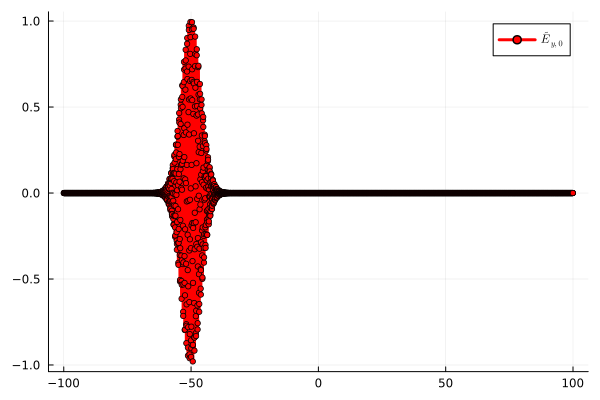

In [198]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot(xx, Ex0, color=:blue,label=L"E_{x,0}", format=:png)
# plot(xx, Ey0, color=:red,label=L"E_{y,0}", format=:png)
# plot!(xx, Bz0, color=:green,label=L"B_{z,0}", format=:png)
# plot!(xx, Phix0, color=:orange,label=L"\phi_{x,0}", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)
ind = 1:4:length(xrealm)
# plot(xrealm[ind],dsemm.Q[ind,1], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{x,0}", format=:png)
#.*(Lnorm)/lp
plot(xreale[ind],dsemm.Q[ind,2], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y,0}", format=:png)
# plot!(xrealm[ind],dsemm.Q[ind,3], color=:green,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{B}_{z,0}", format=:png)
# plot!(xrealm,dsemm.Q[:,4], color=:orange,seriestype=:scatter,label=L"\tilde{\phi}_{x,0}", format=:png)
# plot!(xlim=(-2.75,-2.0),ylim=(-1.0,1.0), format=:png)

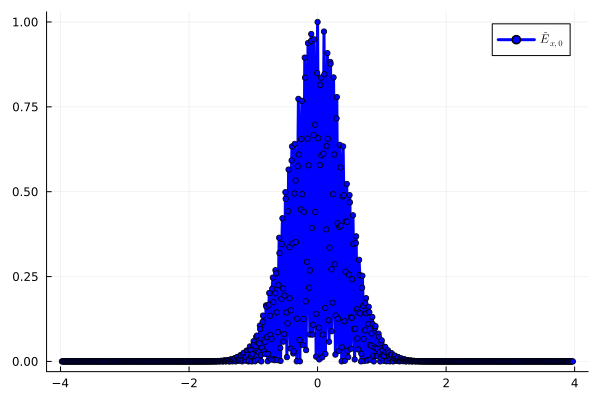

In [131]:
Intensity = dsemm.Q[:,2].^2
ind = 1:4:length(xrealm)
plot(xreale[ind].*(Lnorm)/lp,Intensity[ind], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{x,0}", format=:png)
# plot!(xlim=(-2.0,2.0), format=:png)

In [132]:
maximum(Intensity)*Intnorm

1.2273111013276242e13

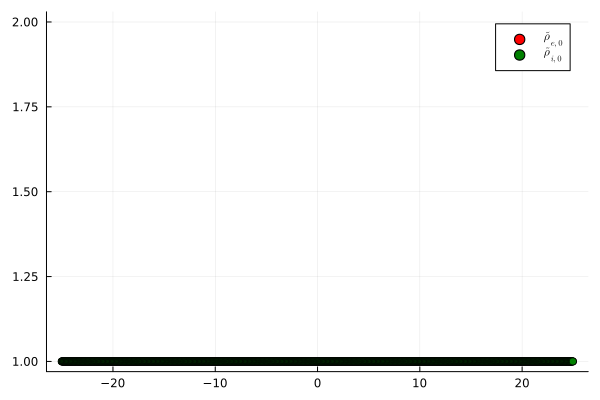

In [133]:
j = 1
plot(xreale[ind],dseme.Q[ind,j], color=:red,seriestype=:scatter,label=L"\tilde{\rho}_{e,0}", format=:png)
plot!(xreale[ind],dsemi.Q[ind,j]/Mi, color=:green,seriestype=:scatter,label=L"\tilde{\rho}_{i,0}", format=:png)
# plot!(xrealm,dsemm.Q[:,4], color=:orange,seriestype=:scatter,label=L"\tilde{\phi}_{x,0}", format=:png)
# plot!(xlim=(-15,15), format=:png)

In [134]:
# plot(xrealm,dsemi.Q[:,1], color=:green,seriestype=:scatter,label=L"\tilde{\rho}_{i,0}", format=:png)
# # plot!(xrealm,dsemm.Q[:,4], color=:orange,seriestype=:scatter,label=L"\tilde{\phi}_{x,0}", format=:png)
# plot!(xlim=(-15,15), format=:png)

In [135]:
# dens = zeros(Float64, K)
# for k in 1:K
#     l = dseme.eindex[2*k-1]
#     #right boundary index
#     r = dseme.eindex[2*k]
#     dens[k] = sum(dseme.Q[l:r,1].*dseme.wk[k])

# end

In [136]:
#element real location boundaries
xk;

In [137]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);
#create elements index locations in 1D array
elindex2 = zeros(Int64, K*2)
elindex2[1] = 1
for k in 1:K-1
    elindex2[2*k] = elindex2[2*k-1] + N[k]+1
    elindex2[2*k+1] = elindex2[2*k]+1
end
elindex2[end] = K*(N[end]+2);

In [138]:
dsemm.eindex = elindex
dsemm.eindex2 = elindex2
dseme.eindex = elindex
dseme.eindex2 = elindex2
dsemi.eindex = elindex
dsemi.eindex2 = elindex2;

In [139]:
function ExtFunEul(Qint, mass::Float64, xyBoundary, xy, t, LRTB)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = mass*rho1#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = mass*rho1*u1#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        Qext[3] = mass*rho1*u1
        Qext[4] = mass*rho1*E1
    elseif LRTB=="RIGHT"
        Qext[1] = mass*rho1#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = mass*rho1*u1#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
        Qext[3] = mass*rho1*u1
        Qext[4] = mass*rho1*E1
    end
    return Qext
end

ExtFunEul (generic function with 1 method)

In [140]:
# x0source = 0.0
# timeoff = 10
# fwhm = 2.0*pi#lp
# ttau = (fwhm)/sqrt(2.0*log(2))
# tau = ttau/sqrt(2.0) #fwhm
# tau0 = tau/lp
# xpulse0 = -25.0-4.0*fwhm#1.5*fwhm
# a = 1/pi^0.25 / sqrt(tau0)
# #taylor off oscillations
# ttay = 2.5*fwhm/lp
# # fwhm, tau, tpulse0, a
# ##speed of light in normalized units
# cc = 1.0
# fEbc(x,t) = cos(wlas/wp*t - klas/kp*x) * exp( -((x-xpulse0) - cc*t)^2/(2.0*tau^2) )

In [141]:


function ExtFunMax(Qint, xyBoundary, xy, t, LRTB)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = fEy(xy,t)#fEbc(xy,t)#fEy(xy,t)#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        Qext[3] = fBz(xy,t)
        Qext[4] = 0.0
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = fEy(xy,t)#0.0#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
        Qext[3] = fBz(xy,t)
        Qext[4] = 0.0
    end
    return Qext
end

ExtFunMax (generic function with 1 method)

In [142]:
dseme.ExtFun = ExtFunEul
dsemi.ExtFun = ExtFunEul
dsemm.ExtFun = ExtFunMax

ExtFunMax (generic function with 1 method)

In [143]:
# c1, c2

In [173]:
ddxx = dxk
CFT = 1.0
ddtt = CFT/c1*ddxx/(NN+1)

0.00956292184248745

In [145]:
wlas/wp

10.0

In [146]:
function RK45DriverT!(t0::Float64, dt::Float64, NT::Int64, DGMax::AbstractArray, DGEule::AbstractArray, DGEuli::AbstractArray)

    tn = t0
    for n in 0:NT
        if mod(n,1) == 0
            IJulia.clear_output(true)
            println("Time Step Start: ",n)
        end
        # DGSEMstep1DRK45Maxwell!(dsemam, dsemae, dsemai, tn, dt)
        DGSEMstep1DRK45PlasmaT!(DGMax, DGEule, DGEuli, tn, dt)
        tn = (n+1)*dt
        if mod(n,1) == 0
            # IJulia.clear_output(true)
            println("Time Step End: ",n)
        end
        
        
    end

end

RK45DriverT! (generic function with 1 method)

In [147]:
# @btime RK45Driver!(0.0, dt, 1, dsemam, dsemae, dsemai)
# @btime RK45DriverT!(0.0, dt, 1, dsemam, dsemae, dsemai)
#The regular RK45Driver! multithread was much faster than the T-version. about 5x faster and uses approximately 1/3 the memory

In [148]:
# @btime RK45DriverT!(0.0, dt, 1, dsemam, dsemae, dsemai)

In [166]:
dt = 1.0e-4#*2.0*pi/wlas#1.0e-3#2.0/(T0)#
ttot = 1.0*dt
NT = floor(Int64, ttot/dt)
ttot, NT, dt, wp/wlas# dsem.c[1], dsem.c[2], NT

(0.0001, 1, 0.0001, 0.1)

In [150]:
Cs*ttot/Lnorm

5.641457659224042e6

In [156]:
dsem1 = deepcopy(dsemm)
dsem2 = deepcopy(dsemm)
dsem3 = deepcopy(dsemm)
dsem4 = deepcopy(dsemm)
dsem5 = deepcopy(dsemm)
dsem6 = deepcopy(dsemm);

In [157]:
dsee1 = deepcopy(dseme)
dsee2 = deepcopy(dseme)
dsee3 = deepcopy(dseme)
dsee4 = deepcopy(dseme)
dsee5 = deepcopy(dseme)
dsee6 = deepcopy(dseme);

In [158]:
dsei1 = deepcopy(dsemi)
dsei2 = deepcopy(dsemi)
dsei3 = deepcopy(dsemi)
dsei4 = deepcopy(dsemi)
dsei5 = deepcopy(dsemi)
dsei6 = deepcopy(dsemi);

In [159]:

dsemam = [dsem1 , dsem2 , dsem3 , dsem4 , dsem5 , dsem6 ]
dsemae = [dsee1 , dsee2 , dsee3 , dsee4 , dsee5 , dsee6 ]
dsemai = [dsei1 , dsei2 , dsei3 , dsei4 , dsei5 , dsei6 ];


In [160]:
datadir = "/dfs6/pub/ernestob/Julia/SpectralMethods/"
filepre= "NDGWake"
RK45Driver!(0.0, dt, NT, dsemam, dsemae, dsemai, datadir,filepre)

Time Step Finished: 0
Time Step Finished: 1


In [161]:
# datadir = "/dfs6/pub/ernestob/Julia/SpectralMethods/"
# filepre= "WF"
# n=1
# fid = h5open(string(datadir,filepre,n,".hdf5"), "cw")
# #g = create_group(fid, "Intensity")
# # fid["Intensity_R"] = abs2.(AR);
# # fid["Intensity_L"] = abs2.(AL);
# # dsemam, dsemae, dsemai
# fid["MaxQ"] = dsemam[1].Q;
# fid["EulQe"] = dsemae[1].Q;
# fid["EulQi"] = dsemai[1].Q;
# close(fid)

In [162]:
ttot/wp*Cs/lp

1.5915494309189534e-5

In [542]:
NDGM = dsemam[1]
NDGe = dsemae[1]
NDGi = dsemai[1];


In [543]:
CalcExt!(NDGM,NDGe,NDGi, 0.0)

4-element Vector{Float64}:
 1829.9778251037392
    0.0
    0.0
 2744.966737655609

In [558]:
CalculateUPEBeta!(NDGe) #electrons
CalculateUPEBeta!(NDGi) #ions

In [564]:
MaxwellFlux!(NDGM) #maxwell
EulerFlux!(NDGe)#electrons
EulerFlux!(NDGi) #ions

In [575]:
CalcAlphaelement!(NDGM,NDGe,NDGi)

In [579]:
CalcAlphaFinalelement!(NDGM,NDGe,NDGi)

In [583]:
CalcFluxBarelement!(NDGM,NDGe,NDGi)

In [602]:
CalcFluxBarAlphaelement!(NDGM,NDGe,NDGi)

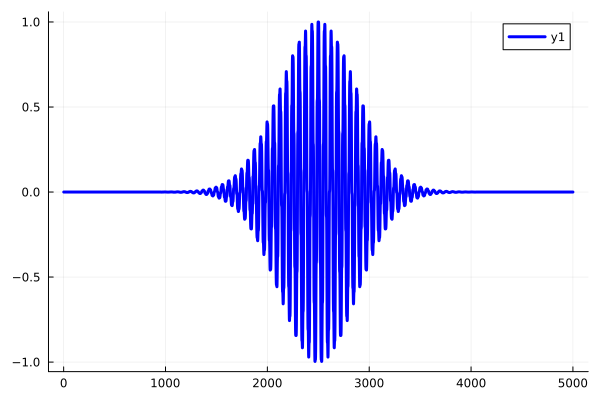

In [623]:
j = 2
plot(NDGM.FBar[:,j], color=:blue,linewidth=3, format=:png)

# plot(NDGi.alphafinal, color=:blue,linewidth=3, format=:png)
# plot!(ylim=(-0.01,0.01))

In [610]:
maximum(NDGe.F[:,j]),maximum(NDGe.FBar[:,j]),maximum(NDGe.FBarAlpha[:,j])

(1.0, 1.0000000000000018, 1.0000000000000018)

In [ ]:
maximum(NDGe.F[:,j]),maximum(NDGe.FBar[:,j]),maximum(NDGe.FBarAlpha[:,j])

In [604]:
maximum(NDGi.F[:,j]),maximum(NDGi.FBar[:,j]),maximum(NDGi.FBarAlpha[:,j])

(1829.9778251037396, 1829.9778251037424, 1829.9778251037424)

In [612]:
minimum(NDGi.F[:,j]),minimum(NDGi.FBar[:,j]), minimum(NDGi.FBarAlpha[:,j])

(1829.9778251037396, 1829.9778251037326, 0.0)

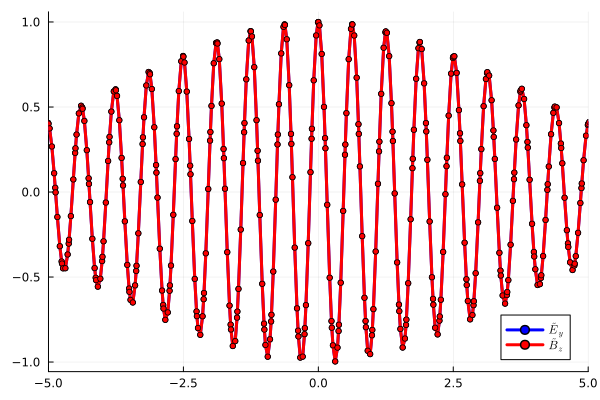

In [163]:
i=1

ind = 1:2:length(xrealm)
# println(minimum(dsemam[i].Q[ind,1]), ", ", maximum(dsemam[i].Q[ind,1]))
plot(xrealm[ind],dsemam[i].Q[ind,2], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png)
plot!(xrealm[ind],dsemam[i].Q[ind,3], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{B}_{z}", format=:png)
plot!(xlim=(-5,5))#,ylim=(-1.1,1.1), format=:png)

In [466]:
nthreads()

24

In [24]:
datadir = "/dfs6/pub/ernestob/Julia/SpectralMethods/Data/"
filepre= "NDGWake"
fid = h5open(string(datadir,filepre,1000,".hdf5"), "r")
Qmaxx = fid["MaxQ"]
Qee = fid["EulQe"]
Qii = fid["EulQi"]
Qmax= read(Qmaxx)
Qe = read(Qee);
Qi = read(Qii);
close(fid)


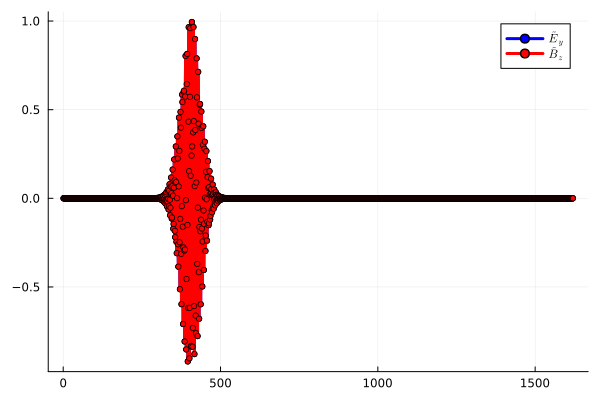

In [25]:
ind = 1:10:length(Qmax[:,2])
# println(minimum(dsemam[i].Q[ind,1]), ", ", maximum(dsemam[i].Q[ind,1]))
# plot(xrealm[ind],Qmax[ind,2], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png)
# plot!(xrealm[ind],Qmax[ind,3], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{B}_{z}", format=:png)
# plot!(xlim=(-5,5))
plot(Qmax[ind,2], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png)
plot!(Qmax[ind,3], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{B}_{z}", format=:png)
# plot!(xlim=(-5,5))

In [469]:
# plot(xk[1:end-1],dsemai[1].alphafinal, format=:png)
# plot!(xk[1:end-1],dsemai[1].ELeg, format=:png)

In [21]:
# i=1
# j=4
# ind = 1:5:length(xreale)
# # println(minimum(dseme.p))
# # println(minimum(dsemi.p))
# # plot(xreale,dseme.Q[:,1], color=:red,linewidth=:4,label=L"\tilde{\rho}_{e,0}", format=:png)
# plot(xreale[ind],dsemae[i].Q[ind,j]./dsemae[i].mass, color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\rho}_{e}", format=:png)
# plot!(xreale[ind],dsemai[i].Q[ind,j]./dsemai[i].mass, color=:orange,marker=:utriangle,linewidth=:3,markersize=3,label=L"\tilde{\rho}_{i}", format=:png)

# # plot!(xreale[ind],dsemae[i].Q[ind,2], color=:green,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\rho u}_{e,x}", format=:png)

# # plot!(xrealm[ind],dsemae[i].Q[ind,3], color=:orange,marker=:diamond,linewidth=:3,markersize=3,label=L"\tilde{\rho u}_{e,y}", format=:png)
# # plot!(xreale[ind],dsemae[i].Q[ind,4], color=:purple,marker=:square,linewidth=:3,markersize=3,label=L"\tilde{e}_{e}", format=:png)
# # plot!(xlim=(-4.0,4.0))#,ylim=(0.5,1.5), format=:png)

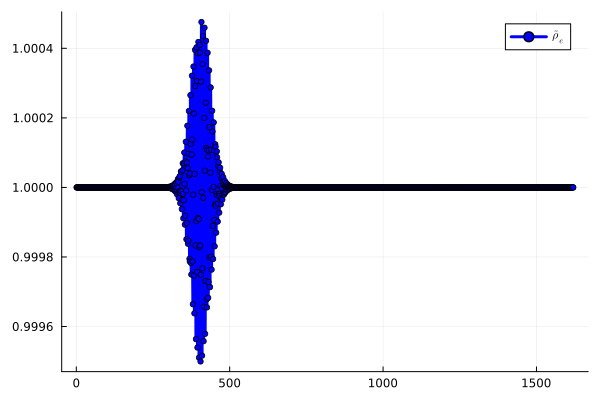

In [29]:
# ind = 1:5:length(xreale)
# plot(xreale,dseme.Q[:,1], color=:red,linewidth=:4,label=L"\tilde{\rho}_{e,0}", format=:png)
j=1
j=1
plot(Qe[ind,j], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\rho}_{e}", format=:png)
# plot!(Qi[ind,j], color=:orange,marker=:utriangle,linewidth=:3,markersize=3,label=L"\tilde{\rho}_{i}", format=:png)

In [436]:
ttot, wp/wlas

(0.001, 0.1)

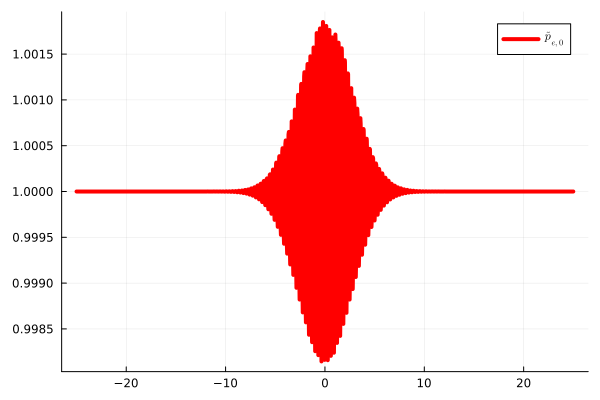

In [472]:
i=1
# println(minimum(dsemae[i].p),", ", maximum(dsemae[i].p))
# println(minimum(dsemai[i].p), ", ",maximum(dsemai[i].p))
ind = 1:2:length(xreale)

plot(xreale[ind],dsemae[i].p[ind], color=:red,linewidth=:4,label=L"\tilde{p}_{e,0}", format=:png)
# plot(xreale[ind],dsemae[i].e[ind], color=:red,linewidth=:4,label=L"\tilde{p}_{e,0}", format=:png)
# plot(xreale[ind],dsemae[i].Beta[ind], color=:red,linewidth=:4,label=L"\tilde{p}_{e,0}", format=:png)

# plot(xreale[ind],dsemae[i].ux[ind], color=:blue,linewidth=:4,label=L"\tilde{u}_{e,x,0}", format=:png)
# plot!(xlim=(-2.0,2.0), format=:png)

In [438]:
minimum(dsemae[i].p)

0.9999999972404272

In [439]:
2/pi

0.6366197723675814

In [473]:
i=1
ddens = @. dsemae[i].Q[:,1]./dsemae[i].mass-dsemai[i].Q[:,1]./dsemai[i].mass
ddens = ddens*density;

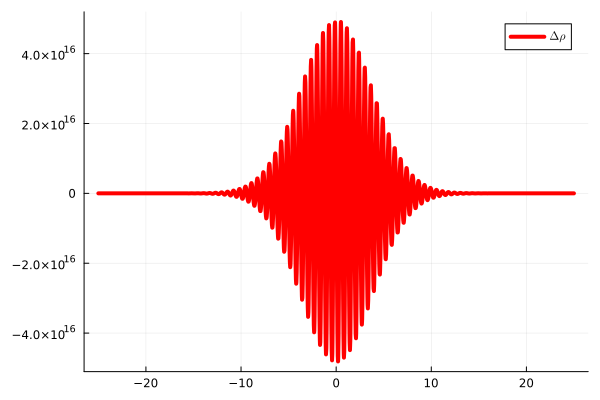

In [474]:
i=1
ind = 1:2:length(xreale)
plot(xreale[ind],ddens[ind], color=:red,linewidth=:4,label=L"\Delta\rho", format=:png)
# plot!(xlim=(-2,2), format=:png)

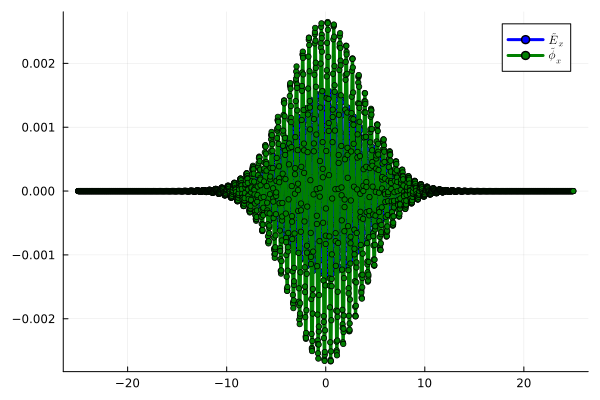

In [475]:

i=1
j=1

ind = 1:2:length(xrealm)
# println(minimum(dsemam[i].Q[ind,1]), ", ", maximum(dsemam[i].Q[ind,1]))
plot(xrealm[ind],dsemam[i].Q[ind,j], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{x}", format=:png)
# plot!(xrealm[ind],dsemam[i].Q[ind,2], color=:red,marker=:diamond,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png) 
# plot!(xrealm[ind],dsemam[i].Q[ind,3], color=:purple, marker=:square, linewidth=:3, markersize=3, label=L"\tilde{B}_{z}", format=:png) 
plot!(xrealm[ind],dsemam[i].Q[ind,4], color=:green,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\phi}_{x}", format=:png) 
# plot!(xlim=(-1.5,1.5), format=:png)

In [443]:
# plot(xrealm[ind],Qmaxx[ind,1], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{x}", format=:png)
# plot!(xrealm[ind],Qmaxx[ind,4], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\phi}_{x}", format=:png)
# # plot!(xlim=(-5,5))

In [ ]:
# i=1

# ind = 1:2:length(xrealm)
# # println(minimum(dsemam[i].Q[ind,1]), ", ", maximum(dsemam[i].Q[ind,1]))
# plot(dsemam[i].FBar[:,2], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png)
# plot!(dsemam[i].FBarAlpha[:,2], color=:red,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{E}_{y}", format=:png)

# # plot!(ylim=(0.0,1.0))

In [ ]:
maximum(dsemam[i].Q[:,1])*Enorm, maximum(dsemam[i].Q[:,2])*Enorm,maximum(dsemam[i].Q[:,2])

In [ ]:
ttot/wp

In [ ]:
1/wp

In [ ]:
Esim2 = maximum(dsemam[i].Q[:,1])*Enorm
Esim2, amp*Enorm, Esim2/(amp*Enorm)

In [ ]:
densim = maximum(ddens)

In [ ]:
phisim2 = densim *Qe/Eps0

In [ ]:
phisim = maximum(dsemam[i].Q[ind,4])*me*(Cs)^2/Qe#*(2.0*Cs)^2/Qe

In [ ]:
Esim2 = phisim2/klas

In [ ]:
Esim = maximum(dsemam[1].Q[ind,1])*me*Cs*wp/Qe

In [ ]:
Esim2/Esim

In [ ]:
wp/Cs

In [ ]:
Esim2*Qe*(maximum(dsemae[i].Q[:,1]) - minimum(dsemai[i].Q[:,1])/Mi)*density

In [ ]:
maximum(dsemae[i].Q[:,1])

In [ ]:
(Esim2*Qe/me/wp)/Cs

In [ ]:
Esim/Enorm

In [ ]:
Esim2/Esim

In [ ]:
Esim2, Esim*pi/2

In [ ]:
i=1
ind = 1:20:length(xreale)
# plot(xreale,dseme.S[:,1], color=:red,linewidth=:4,label=L"\tilde{\rho}_{e,0}", format=:png)
plot(xreale[ind],dsemam[i].S[ind,1], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{J}_{x}", format=:png)
plot!(xreale[ind],dsemam[i].S[ind,4], color=:orange,marker=:utriangle,linewidth=:3,markersize=3,label=L"\tilde{\rho}_{e}", format=:png)

In [ ]:
maximum(dsemae[i].Q[ind,1])*Eps0*me*wp^2/Qe^2

In [ ]:
density

In [ ]:
Esim2 = maximum(dsemam[i].Q[ind,1])*Enorm#*me*Cs*wp/Qe/(pi/2)

In [ ]:
Esim2 = maximum(dsemam[i].Q[ind,1])*Enorm
Qe/me*Esim2/wp

In [ ]:
Cs*Eps0/Mu0

In [ ]:
Cs/(Mu0/Eps0)

In [ ]:
(-(density-am*density) + density )*Qe/Eps0

In [ ]:
maximum(dsemae[i].Q[ind,1]), maximum(dsemai[i].Q[ind,1])/Mi

In [ ]:
rhod = (maximum(dsemae[i].Q[ind,1]) - maximum(dsemai[i].Q[ind,1])/Mi)*density *Qe/Eps0

In [ ]:
rhod 

In [ ]:

i=1
ind = 4:10:length(xreale)
# println(minimum(dsemam[i].Q[ind,1]), ", ", maximum(dsemam[i].Q[ind,1]))
plot(xrealm[ind],dsemam[i].Q[ind,4], color=:blue,marker=:circle,linewidth=:3,markersize=3,label=L"\tilde{\phi}_{x}", format=:png)

In [ ]:
dsemae[i].mass

In [ ]:
i=3
ind = 1:20:length(xreale)

plot(xreale[ind],dsemae[i].S[ind,2], color=:purple,marker=:square,linewidth=:3,markersize=3,label=L"\tilde{e}_{e}", format=:png)

In [ ]:
minimum(dsemi.p[ind])

In [ ]:
i=2
plot(dsemae[i].alphafinal,color=:blue, format=:png)
# plot(dsemae[i].ELeg,color=:red, format=:png)

In [ ]:
# xkk = @. xk+0.5*dxk
# xkk = xkk[1:end-1];
# Elegendre = (dsema[1].ELeg)/maximum(dsema[1].ELeg);
i = 1
j =1

# plot(xrealm, dsemae[i].Q[:,j], color=:red, format=:png)
# plot(xrealm, dsemai[i].F[:,j], color=:purple,linestyle=:dot, format=:png)
# plot(dsemai[i].FBar[:,j], color=:purple,linestyle=:dot, format=:png)

# plot!(xrealm, dsemae[i].Q[:,2],  format=:png)
# plot!(xrealm, dsemai[i].Q[:,2],  format=:png)
plot(xrealm, dsemae[i].Beta, color=:blue, linestyle=:dash, format=:png)
# plot!(xrealm, dsemae[i].Beta,color=:green, format=:png)


In [ ]:
maximum(dsemae[i].Q[:,j])

In [ ]:
10.0/(30/400)

In [ ]:
i = 1
plot(dsemam[i].alpha, color=:blue, format=:png)
# plot(dsemam[i].alpha, color=:green, format=:png)
plot!(dsemam[i].ELeg, color=:red,format=:png)

In [ ]:
function CalcLegEelementMaxwellA!(NDG::Maxwell)
    #calculates the Legendre Energy for each element
    K = NDG.K
    N = NDG.N[1]
    m = NDG.si[1]
    #calculate Legendre Mode Energies for each element
    for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        #calculate energy legendre mode
        NDG.ELeg[k] = calculateLegE(NDG.Q[l:r,3], NDG.Q[l:r,3], NDG.xi[k], NDG.wk[k], m)#NDG.Q[l:r,1], NDG.p[l:r], NDG.xi[k], NDG.wk[k], m)

    end
    return nothing

end

In [ ]:
i = 1
dsemam[i].si = [NN+1]
CalcLegEelementMaxwellA!(dsemam[i])

In [ ]:
i = 1
plot(dsemam[i].alpha, color=:blue, format=:png)
# plot(dsemam[i].alpha, color=:green, format=:png)
plot!(dsemam[i].ELeg, color=:red,format=:png)

In [ ]:
k=50
#left boundary index
l = dsemam[1].eindex[2*k-1]
#right boundary index
r =dsemam[1].eindex[2*k]
#calculate energy legendre mode
calculateLegE(dsemam[1].Q[l:r,2], dsemam[1].Q[l:r,3], dsemam[1].xi[1], dsemam[1].wk[1], NN+1)

In [ ]:
k=50
#left boundary index
l = dsemam[1].eindex[2*k-1]
#right boundary index
r =dsemam[1].eindex[2*k+4]
plot(dsemam[i].Q[:,2])
plot!(xlim=(l,r), ylim=(-1.0e-6,1.0e-7))

In [ ]:
xrealm[465]

In [ ]:
dsemam[1].Q[l:r,3]

In [ ]:
i = 1
plot(xrealm,dsemam[i].dF[:,2], color=:red,seriestype=:scatter,label=L"\tilde{E}_{y}", format=:png)
plot!(xrealm,dsemam[i].dF[:,3]*c, color=:blue, marker=:diamond,markersize=2.75,seriestype=:scatter,label=L"\tilde{B}_{z}", format=:png)


In [ ]:
i = 1
plot(dsemam[i].FBar[:,3], color=:red,seriestype=:scatter,label=L"\tilde{E}_{y}", format=:png)

In [ ]:
Lam0/c

In [ ]:
(dxk*Lam0)/Lam0

In [ ]:
Vm = dsemam
Ve = dsemae
Vi = dsemai;

N = Vm[1].N
K = Vm[1].K
Neqn = Vm[1].Neqn



a1 = [1.0, 0.44437049406734, 0.62010185138540, 0.17807995410773, 0.00683325884039]
a2 = [0.0, 0.55562950593266, 0.0, 0.0 , 0.0 ]
a3 = [0.0, 0.0, 0.37989814861460, 0.0, 0.51723167208978]
a4 = [0.0, 0.0, 0.0, 0.82192004589227, 0.12759831133288]
a5 = [0.0, 0.0, 0.0, 0.0, 0.34833675773694]
a = [a1 a2 a3 a4 a5]
b1 = [0.39175222700392, 0.0, 0.0, 0.0, 0.0]
b2 = [0.0, 0.36841059262959, 0.0, 0.0, 0.0]
b3 = [0.0, 0.0, 0.2518917, 0.0, 0.0]
b4 = [0.0, 0.0, 0.0, 0.54497475021237, 0.08460416338212]
b5 = [0.0, 0.0, 0.0, 0.0, 0.22600748319395]
b = [b1 b2 b3 b4 b5]
g = [0.0, 0.39175222700392, 0.58607968896779, 0.47454236302687, 0.93501063100924]
t = 0.0


In [ ]:
tn = 0.0
@. Vm[2].Q = 0.0
@. Vm[3].Q = 0.0
@. Vm[4].Q = 0.0
@. Vm[5].Q = 0.0
@. Vm[6].Q = 0.0
@. Vm[2].dQ = 0.0
@. Vm[3].dQ = 0.0
@. Vm[4].dQ = 0.0
@. Vm[5].dQ = 0.0
@. Vm[6].dQ = 0.0;
dt

In [ ]:
# #alg 62
# function DGSEMstep1DRK45E!(Vm::AbstractArray, Ve::AbstractArray, Vi::AbstractArray, tn::Float64, dt::Float64)

for i in 1:5
    ii = i+1
    
    #gt = g(t) #boundary condition in time
    
    for jj in 0:i-1
        j = jj+1
        
        @. Vm[ii].Q = Vm[ii].Q + a[i,j]*Vm[j].Q
        t = tn +g[i]*dt #update time
        #time derivative
        #do only when b[i,j] != 0
        if b[i,j] != 0.0
            GlobalTimeDerivativeMaxwell!(Vm[j], Ve[1], Vi[1], t)
            @. Vm[ii].Q = Vm[ii].Q + dt*b[i,j]*Vm[j].dQ
        end
            
        
    end
end

    # @. Vm[1].Q = Vm[6].Q

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0




In [ ]:
@. Vm[1].Q = Vm[6].Q;

In [ ]:

i=4
plot(xrealm,dsemm.Q[:,2], color=:red,label=L"\tilde{E}_{x,0}", format=:png)
plot!(xrealm,Vm[i].Q[:,2], color=:blue,seriestype=:scatter,label=L"\tilde{E}_{y}", format=:png)
plot!(xrealm,Vm[i+1].Q[:,2], color=:purple,seriestype=:scatter,markersize=2.75,label=L"\tilde{E}_{y,+1}", format=:png)
plot!(xrealm,Vm[i].Q[:,3].*c, color=:green,marker=:diamond,markersize=2.75,seriestype=:scatter,label=L"\tilde{B}_{z}", format=:png)
# plot!(xrealm,Vm[i].dQ[:,2], color=:purple,seriestype=:scatter,label=L"\partial_x \tilde{E}_{y}", format=:png)

plot!(xlim=(-10,10))#, ylim=(-1.2,1.6))

In [ ]:
dt

In [ ]:
i=6
# plot(xrelm,dsemm.dQ[:,2], color=:red,label=L"\tilde{E}_{x,0}", format=:png)
plot(xrealm,Vm[i].dQ[:,2].*dt, color=:blue,seriestype=:scatter,label=L"\tilde{E}_{y}", format=:png)
plot!(xrealm,Vm[i].dQ[:,3].*dt*c, color=:green,marker=:diamond,markersize=2.75,seriestype=:scatter,label=L"\tilde{B}_{z}", format=:png)
# plot!(xrealm,Vm[i].dQ[:,2], color=:purple,seriestype=:scatter,label=L"\partial_x \tilde{E}_{y}", format=:png)

plot!(xlim=(-10,10))

In [ ]:
i = 5
plot(Vm[i].FBar[:,2], linewidth=:2, format=:png)
# plot!(Vm[i].FBarAlpha[:,2])
plot!(Vm[i].FBar[:,3]*c, linestyle=:dash, linewidth=:1.5, format=:png)
plot!( Vm[i].FBarAlpha[:,3]*c, linestyle=:dot, format=:png)
plot!([r2], [NDG.FRei[2]], seriestype=:scatter, format=:png)
vline!(elindex2,linestyle=:dash,label="elements", format=:png)
plot!(xlim=(490,520), ylim=(-2.0e8,2.0e8), format=:png)

In [ ]:
CalcBoundaryFluxelementMaxwellA!(NDG)

In [ ]:
i = 5
plot(NDG.FBar[:,2], linewidth=:4,format=:png)
# plot!(Vm[i].FBarAlpha[:,2])
plot!(NDG.FBar[:,3]*c, linestyle=:dash, linewidth=:3, format=:png)
plot!( NDG.FBarAlpha[:,3]*c, linestyle=:dot,linewidth=:2.5,  format=:png)
plot!( NDG.FBarAlpha[:,2], color=:red,linestyle=:dot,linewidth=:2.5,  format=:png)

# plot!([r2], [NDG.FRei[2]], seriestype=:scatter, format=:png)
# vline!(elindex2,linestyle=:dash,label="elements", format=:png)
plot!(xlim=(490,520), ylim=(-5.0e8,5.0e8), format=:png)

In [ ]:
plot( NDG.FBarAlpha[:,2], linestyle=:dot,linewidth=:2.5,  format=:png)


In [ ]:
i = 5
plot(NDG.Q[:,2], linewidth=:2)
# plot!(Vm[i].FBarAlpha[:,2])
plot!(NDG.FBar[:,3]*c, linestyle=:dash, linewidth=:1.5)
plot!( NDG.FBarAlpha[:,3]*c, linestyle=:dot)
plot!([r2], [NDG.FRei[2]], seriestype=:scatter)
vline!(elindex2,linestyle=:dash,label="elements")
plot!(xlim=(200,500), ylim=(-2.0e8,2.0e8))

In [ ]:
r2

In [ ]:
K,size(Vm[4].Q[:,1])

In [ ]:
k = 85
NDG = Vm[5]
l = NDG.eindex[2*k-1]
l2 = NDG.eindex2[2*k-1]
#right boundary index
r = NDG.eindex[2*k]
r2 = NDG.eindex2[2*k]

In [ ]:
NDG.FLei

In [ ]:
NDG.FBarAlpha[r2,:]

In [ ]:
NDG.F[r,:], NDG.F[r+1,:]

In [ ]:
 NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3]

In [ ]:
NDG.Q[r,3]*c^2

In [ ]:
@. NDG.FRei = 0.0

In [ ]:
EntropyStableFluxMaxwellA!(NDG.FRei, NDG.F[r,:], NDG.F[r+1,:], NDG.c[1], NDG.c[2],NDG.Q[r,1],NDG.Q[r+1,1], NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3], NDG.Q[r,4], NDG.Q[r+1,4])

In [ ]:
NDG.FRei

In [ ]:
NDG.F[r,:]

In [ ]:
NDG.FBarAlpha[r2,:]

In [ ]:
NDG.F[r-1,:]

In [ ]:
function EntropyStableFluxMaxwellA!(FES::AbstractArray, Fl::AbstractArray, Fk::AbstractArray, c::Float64, chi::Float64, ExL::Float64, ExR::Float64, EyL::Float64, EyR::Float64, BzL::Float64, BzR::Float64, PhixL::Float64, PhixR::Float64, normal::Float64)

    #normal
    n=normal
    #define division by speed of light
    divc = 1.0/c
    #Entropy conserving flux
    @. FES = 0.5 * (Fl + Fk)
    #find maximum of speeds
    lambda = maximum([c*chi, c])

    FES[1] = FES[1] - 0.5*lambda * ( (divc*ExL + PhixL ) - (divc*ExR + PhixR )  )
    FES[2] = FES[2] - 0.5*lambda * ( (divc*EyL + BzL ) - (divc*EyR + BzR  )  )
    FES[3] = FES[3] - 0.5*lambda * ( (BzL - divc*EyL ) + (BzR - divc*EyR  )  )
    FES[4] = FES[4] - 0.5*lambda * ( (PhixL - divc*ExL ) - (PhixR - divc*ExR  )  )
    
    return nothing #3FES
end

In [ ]:
NDG.c

In [ ]:
#Add boundary fluxes
function CalcBoundaryFluxelementMaxwellA!(NDG::Maxwell)
    #Element Boundary Entropy Stable Flux
    c = NDG.c[1]
    chi = NDG.c[2]
    K=NDG.K
    for k in 1:K
        #left boundary index
        l = NDG.eindex[2*k-1]
        l2 = NDG.eindex2[2*k-1]
        #right boundary index
        r = NDG.eindex[2*k]
        r2 = NDG.eindex2[2*k]
        #check if left boundary use external left flux and right flux from next eelement
        # EntropyStableFluxMaxwell!(FES::AbstractArray, Fl::AbstractArray, Fk::AbstractArray, c::Float64, chi::Float64, ExL::AbstractArray, ExR::AbstractArray, EyL::AbstractArray, EyR::AbstractArray, BzL::AbstractArray, BzR::AbstractArray, PhixL::AbstractArray, PhixR::AbstractArray)
        if k==1
            #might need @view(NDG.FLext)
             EntropyStableFluxMaxwellA!(NDG.FLei, NDG.FLext, NDG.F[l,:], c, chi,NDG.QLext[1],NDG.Q[l,1], NDG.QLext[2],NDG.Q[l,2], NDG.QLext[3], NDG.Q[l,3], NDG.QLext[4], NDG.Q[l,4], -1.0)
            
             EntropyStableFluxMaxwellA!(NDG.FRei, NDG.F[r,:], NDG.F[r+1,:], c, chi,NDG.Q[r,1],NDG.Q[r+1,1], NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3], NDG.Q[r,4], NDG.Q[r+1,4], 1.0)
        #if right boundary use external right flux and left element flux
        elseif k==K
            EntropyStableFluxMaxwellA!(NDG.FRei, NDG.F[r,:], NDG.FRext, c, chi, NDG.Q[r,1], NDG.QRext[1], NDG.Q[r,2], NDG.QRext[2], NDG.Q[r,3], NDG.QRext[3], NDG.Q[r,4],  NDG.QRext[4], 1.0)
            
            EntropyStableFluxMaxwellA!(NDG.FLei, NDG.F[l-1,:], NDG.F[l,:], c, chi,NDG.Q[l-1,1],NDG.Q[l,1], NDG.Q[l-1,2],NDG.Q[l,2], NDG.Q[l-1,3], NDG.Q[l,3], NDG.Q[l-1,4], NDG.Q[l,4], -1.0)
        else
            EntropyStableFluxMaxwellA!(NDG.FRei, NDG.F[r,:], NDG.F[r+1,:], c, chi,NDG.Q[r,1],NDG.Q[r+1,1], NDG.Q[r,2],NDG.Q[r+1,2], NDG.Q[r,3], NDG.Q[r+1,3], NDG.Q[r,4], NDG.Q[r+1,4], 1.0)
            EntropyStableFluxMaxwellA!(NDG.FLei, NDG.F[l-1,:], NDG.F[l,:], c, chi,NDG.Q[l-1,1],NDG.Q[l,1], NDG.Q[l-1,2],NDG.Q[l,2], NDG.Q[l-1,3], NDG.Q[l,3], NDG.Q[l-1,4], NDG.Q[l,4], -1.0)
        end
        
        NDG.FBarAlpha[l2,:] .=  NDG.FLei
        NDG.FBarAlpha[r2,:] .= NDG.FRei
    end
    return nothing

end

#Entropy Stable Numerical Schemes for Two-Fluid Plasma Equations by Kumar
#Eqn 3.8


In [ ]:
#alg 88 NDG::NDG2DWaves
# ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT", c, epsr, mur, Z)
function ReimannSolverNDG1DRHMaxA!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, side::String, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
    #Qout - outgoing corresponds to +
    #Qinc - incoming wave corresponds to -
    #normal is normal to x surface
    #epsr - [1] is incoming eps and [2] is outgoing
    
    ZL = Z[1]
    ZR = Z[2]
    cL = c[1]
    cR = c[2]
    epsL = epsr[1]
    epsR = epsr[2]
    muL = mur[1]
    muR = mur[2]

    EL = QL[1]
    HL = QL[2]
    ER = QR[1]
    HR = QR[2]

    F1 = 0.0
    F2 = 0.0
    
    # FLstar
    if side == "LEFT" #|| side == "RIGHT"
        F1 = normal*cL*cR*((EL + cL*HL) - (ER - cR*HR) )/((cL+cR))
        # normal*( ZR*cL*(EL + normal*ZL*HL) - ZL*cR*(ER - normal*ZR*HR) )/((ZL+ZR)) 
        F2 = normal*(cL*(EL + normal*cL*HL) + cR*(ER - cR*HR))/((cL+cR))
        # normal*(cL*(EL + normal*HL*ZL) + cR*(ER - normal*ZR*HR))/((ZL+ZR))
    elseif side == "RIGHT"
        #normal = -1.0*normal
        # F1 = ( ZR*cL*(EL + normal*ZL*HL) - ZL*cR*(ER - normal*ZR*HR) )/((ZL+ZR)) 
        # F2 = normal*(cL*(EL + normal*HL*ZL) + cR*(ER - normal*ZR*HR))/((ZL+ZR))
    end

    return [F1, F2] #[FLstar1, FLstar2], [FRstar1, Fstar2]
    

end

In [ ]:
plot(NDG.F[:,2])

In [ ]:
elindex2

In [ ]:
size(Vm[i].FBar[:,2]), size(xrealm)

In [ ]:
i = 6
plot(Vm[i].S[:,3], format=:png)

In [ ]:
size(dsemam[i].dQ[:,2])

In [ ]:
1/(30/1000)

In [ ]:
maximum(dsemam[i].dQ[:,2]), maximum(dsemam[i].dQ[:,3])

In [ ]:
size(dsemam[i].FBar[:,2])

In [ ]:
i = 5
plot(dsemam[i].alphafinal, color=:blue, format=:png)
# plot(dsemam[i].alpha, color=:green, format=:png)
plot!(dsemam[i].ELeg, color=:red,format=:png)



In [ ]:
maximum(dsemam[i].alphafinal)

In [ ]:
plot(xreale, dsemae[1].ux)
plot!(xreale, dsemae[1].uy)
plot!(xreale, dsemae[1].p)
plot!(xreale, dsemae[1].e)
plot!(xreale, dsemae[1].Q[:,1])

In [ ]:
plot(xreale, dsemai[1].ux)
plot!(xreale, dsemai[1].uy)
plot!(xreale, dsemai[1].p)
plot!(xreale, dsemai[1].e)
plot!(xreale, dsemai[1].Q[:,1])

In [ ]:
plot(xrealm, dsemam[2].dQ[:,2])

In [ ]:
NDG = dsemam[1];

In [ ]:
t = 0.0
NDG.QLext = NDG.ExtFun(NDG.Q[1,:], -1.0, NDG.xk[1], t, "LEFT")
#right
NDG.QRext = NDG.ExtFun(NDG.Q[end,:], 1.0, NDG.xk[end], t, "RIGHT")

In [ ]:
MaxwellFlux!(NDG)

In [ ]:
maximum(c^2 * NDG.Q[:,3])

In [ ]:
maximum(NDG.Q[:,2])

In [ ]:
maximum(NDG.F[:,2])

In [ ]:
mode = floor(Int64, NDG.si[1])

In [ ]:
CalcLegEelementMaxwell!(NDG)

In [ ]:
plot(NDG.ELeg)

In [ ]:
s = NDG.sf[1]

In [ ]:
CalcAlphaelement!(NDG)

In [ ]:
plot(NDG.alpha)

In [ ]:
CalcAlphaFinalelement!(NDG)

In [ ]:
plot(NDG.alphafinal)

In [ ]:
CalcFluxBarelementMaxwell!(NDG)

In [ ]:
plot(NDG.FBar[:,2])
plot!(NDG.FBar[:,3]*c)

In [ ]:
CalcFluxBarAlphaelementMaxwell!(NDG)

In [ ]:
plot(NDG.FBarAlpha[:,2])
plot!(NDG.FBarAlpha[:,3]*c)

In [ ]:
CalcBoundaryFluxelementMaxwell!(NDG)

In [ ]:
plot(NDG.FBarAlpha[:,2])
plot!(NDG.FBarAlpha[:,3]*c)

In [ ]:
SourceMaxwell!(NDG, dseme, dsemi);

In [ ]:
plot(NDG.S[:,2])

In [ ]:
LocalTimeDerivativeElement!(NDG)

In [ ]:
plot(NDG.dQ[:,2])
plot!(NDG.dQ[:,3]*c)

In [ ]:
plot(NDG.dQ[:,2]*dt + NDG.Q[:,2])
plot!((NDG.dQ[:,3]*dt + NDG.Q[:,3]).*c)

In [ ]:
dt*T0

In [ ]:
0.001*maximum(NDG.dQ[:,2])

In [ ]:
#alg 93
function GlobalTimeDerivativeMaxwell!(NDG::Maxwell,NDGe::Euler,NDGi::Euler, t::Float64,  eindex::Array{Int64}, eindex2::Array{Int64})

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    #alpha parameter
    s = NDG.sf[1] #9.21024
    #get external boundaries
    #left
    NDG.QLext = NDG.ExtFun(NDG.Q[1,:], -1.0, NDG.xk[1], t, "LEFT")
    #right
    NDG.QRext = NDG.ExtFun(NDG.Q[end,:], 1.0, NDG.xk[end], t, "RIGHT")
    #calculate regular Euler flux
    MaxwellFlux!(NDG)
    #calculate Legendre Mode Energies for each element
    #Legendre mode
    mode = floor(Int64, NDG.si[1])
    CalcLegEelementMaxwell!(NDG, eindex,mode )
    #calculate alpha for each element
    CalcAlphaelement!(NDG, eindex, s)
    #calculate alpha final for each element
    CalcAlphaFinalelement!(NDG, eindex)
    # calculate flux bar for each element
    CalcFluxBarelementMaxwell!(NDG, eindex,eindex2)
    # calculate flux BAR ALPHA for each element
    CalcFluxBarAlphaelementMaxwell!(NDG, eindex,eindex2)
    #Add boundary fluxes
    CalcBoundaryFluxelementMaxwell!(NDG, eindex,eindex2)
    #calculate sources
    SourceMaxwell!(NDG, NDGe, NDGi)
    #calculate d/dt (Fbaralpha)
    LocalTimeDerivativeElement!(NDG, eindex, eindex2)
    return nothing
    
end

In [ ]:
sum(dsema[1].MD[1,:])

In [ ]:

# plot(dsema[1].alphafinal, color=:blue,label=L"\alpha_f",linewidth=2.0, format=:png)
# plot!(Elegendre, color=:red,label=L"E_{Leg}",linewidth=2.0, format=:png)

In [ ]:
NX = 5
dX = 2.0/NX
XX= [-1.0 + i*dX for i in 0:NX-1];
PolM = PolynomialInterpolationMatrix(dsem.xi[1],XX, dsem.wbk[1],1.0e-8);
rho = PolM*dsema[1].Q[elindex[1]:elindex[2], 1]
ux = PolM*dsema[1].u[elindex[1]:elindex[2]]
p = PolM*dsema[1].p[elindex[1]:elindex[2]]
En = PolM*dsema[1].E[elindex[1]:elindex[2]]
Xreal = @. (XX+1)/2*dxk
for k in 2:K
    l = elindex[2*k-1]
    r = elindex[2*k]
    rho = [rho; PolM*dsema[1].Q[l:r, 1]]
    ux = [ux; PolM*dsema[1].u[l:r]]
    p = [p; PolM*dsema[1].p[l:r]]
    En = [En; PolM*dsema[1].E[l:r]]
    xx = @. dxk*(k-1) + (XX+1)/2*dxk
    Xreal = [ Xreal ; xx  ]
end

In [ ]:

plot(Xreal,rho, color=:blue,label=L"\tilde{\rho}",linewidth=2.0, format=:png)
plot!(Xreal,ux, color=:red,label=L"\tilde{u}", linewidth=2.0,format=:png)
plot!(Xreal,p, color=:green,label=L"\tilde{p}", linewidth=2.0,format=:png)
plot!(Xreal,En, color=:purple,label=L"\tilde{E}", linewidth=2.0,format=:png)
# vline!([3], color=:darkblue, linewidth=2, label="")
# annotate!(0.75, 1.1, text(L"\epsilon_r = 1", :darkblue, :right, 16))
# annotate!(4.9, 1.1, text(L"\epsilon_r = 4.0", :darkblue, :right, 16))
#annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.25, 1.0, text("Reflected\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(4.0, 1.0, text("Transmitted\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# annotate!(1.25, 0.5, text("Reflected", :black, :left, 10))
# annotate!(4.3, 0.5, text("Transmitted", :black, :left, 10))
# plot!([xreal[45]], [0.0], seriestype=:scatter,label=L"J_{source}", color=:orange,marker=(:diamond, 8.0))
plot!(title="t=0.05", legend=:bottomleft, legendfontsize=12,format=:png)#, ylim=(-1.5,1.5))#, xlim=(3.1,4.0))#, ylim=(-0.25,0.25))#, xlim=(1,3))
xlabel!(L"x", guidefont=18,format=:png)
# ylabel!(L"E,H", guidefont=18)
#xlim!([3.5,5.0])


In [ ]:
# #Alg 92
# #using eqn 5.152
function SystemDGSEMDerivativePW!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, c::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    # for n in 1:Neqn 
    #     dF[:, n] .= Dhat * F[:,n]
    
    #     @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    # end
    dF[:, 1] .= Dhat * F[:,1]
    @. dF[:,1] =  dF[:,1] + (FR[1]*lp1  + FL[1]*ln1)/w #/c^2
    dF[:, 2] .= Dhat * F[:,2]
    @. dF[:,2] =  dF[:,2] + (FR[2]*lp1  + FL[2]*ln1)/w

    return nothing


end

In [ ]:
#alg 93
function DGSEM1DGlobalTimeDerivativeMax!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function, SOURCEE::Function, SOURCEB::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    kkk=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,kkk], -1.0, NDG.xk[1], t, "LEFT")
    kkk=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,kkk], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            #ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, "LEFT",epsr, mur, c, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT",epsr, mur, c, Z)
        else
            lpoint = eindex[2*k-1]
            rpoint = eindex[2*k]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, "RIGHT", epsr, mur, c, Z) ##ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        #FluxMaxwell(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, epsr::AbstractArray, mur::AbstractArray)
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.epsr[lpoint:rpoint], NDG.mur[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        #SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
        # SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])
        SystemDGSEMDerivativePW!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k],  NDG.c[lpoint:rpoint], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        #[Jesource.(xreal,1.0) Jbsource.(xreal,1.0)];
        #-2.0.*dsema.dF ./ dsema.dxk[1] .+ [Jesource.(dsema.xreal[elindex[1]:elindex[2]],1.0) Jbsource.(dsema.xreal[elindex[1]:elindex[2]],1.0)]
        NDG.dQ[lpoint:rpoint, :] .= -2.0.*NDG.dF ./ NDG.dxk[k] .+ [SOURCEE.(NDG.xreal[lpoint:rpoint],t) SOURCEB.(NDG.xreal[lpoint:rpoint],t)]
            
        
    end

    
end

In [ ]:
# #alg 62
function DGSEMstep1DRK3Max!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function, SOURCEE::Function, SOURCEB::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivativeMax!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux, SOURCEE, SOURCEB)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

In [ ]:
t0 = 0.0
mu0 = 1.0
mu1 = 1.0
eps0 = 1.0 #vacuum relative permittivity
eps1 = 2.250 #material relative permittivity
xeps = 3.0 #position of material boundary
c0 = 1.0/sqrt(eps0*mu0) #relative wave speed in vacuum
c1 = 1.0/sqrt(eps1*mu1)
Z0 = sqrt(mu0/eps0)
Z1 = sqrt(mu1/eps1)

#x will be scaled by wavelength x/lambda -> x
#time will be scaled by frequency t*f -> f
#so wavelength must also
lambda0 = 1/2.0
k0 = 2.0*pi/lambda0
omegaf = 2.0*pi*c0/lambda0
lambda1 = c1 *2.0*pi/omegaf
k1 = 2.0*pi/lambda1
Pgauss = 12.0

lambda0, lambda1, omegaf, c0, c1

In [ ]:
tau*sqrt(2.0*log(2.0))

In [ ]:
1.5/sqrt(2.0*log(2.0))

We can model an infinite plane wave by a supergaussian:

\begin{align}
    e^{-\left(  \frac{\left( x - x_0  \right)^2}{2 \tau^2}   \right)^P }
\end{align}

Where $P$ is the higher order gaussian. We will choose $P=8$ with a $FWHM = 10$ and a starting position outside the domain so that there is a flux coming. 

In [ ]:
function speedc(x::Float64, xeps=xeps)
    c = 0.0
    if x <= xeps
        c = c0#1.0/sqrt(epsr*mur)
    else
        c = c1
    end
    return c
end

function impZ(x::Float64, xeps=xeps)
    Z = 0.0
    if x <= xeps
        Z = Z0#1.0/sqrt(epsr*mur)
    else
        Z = Z1
    end
    return Z
end

function klam(x::Float64, xeps=xeps)
    k = 0.0
    if x <= xeps
        k = k0#1.0/sqrt(epsr*mur)
    else
        k = k1
    end
    return k
end
#time is scaled by c -> c=1 so 

Fe(x,t) = sin(omegaf*t)  #sin(omegaf*t - klam(x)*x) * exp(-(  ((x-X0) - t*speedc(x))^2/(2.0*tau^2)  )^Pgauss )
Fh(x,t) = 0.0#1.0/impZ(x) * sin(omegaf*t - klam(x)*x) * exp(-(  ((x-X0) - t*speedc(x))^2/(2.0*tau^2)  )^Pgauss )
Fun = [Fe, Fh]

In [ ]:
Z1

In [ ]:
#calculate beta impedance ratio
Beta = Z0/Z1

In [ ]:
#calculate plane wave reflected and transmitted ratios
ERef = (1-Beta)/(1+Beta)
ETran = 2.0/(1+Beta)

ERef, ETran

In [ ]:
#calculate transmitted pulse ratio amplitude for E-field and H-field
ETran*sqrt(Beta), ETran*sqrt(Beta)/Z1

In [ ]:
#calculate new pulse widths for reflected and transmitted wave
#and amplitude modifiers
#
taur = tau
ar = 1/pi^0.25 / sqrt(taur)
taut = tau * c1/c0
at = 1/pi^0.25 / sqrt(taut)

tau, taur, taut

In [ ]:
lambda1

In [ ]:
5/20/10

In [ ]:
kvec = [1.0, -1.0]
xtot = [0.0, 5.0]
Nvec = 2
K = 60
NN = 11
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

In [ ]:
#make struct
DGSEM = DGmaxwell
dsem = DGSEM()

In [ ]:
xreal = NDGConstructMax(dsem, N, K, "leg", Nvec, Fun, kvec, t0,  xk);
#NDGConstruct(dsem, N, K, "leg", Nvec, Fun,  c, rho, Kbulk, kvec, t0,  xk);
# NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  c::AbstractArray, epsr::AbstractArray, mur::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)

In [ ]:
#need to construct arrays for eps, mu, and c
epsr = zeros(Float64, length(xreal))
mur = zeros(Float64, length(xreal))
c = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

for i in 1:length(c)
    if xreal[i] <= xeps
        epsr[i] = eps0
        mur[i] = mu0
        c[i] = c0
        Z[i] = Z0
    elseif xreal[i] > xeps
        epsr[i] = eps1
        mur[i] = mu1
        c[i] = c1
        Z[i] = Z1
    end

end

In [ ]:
dsem.epsr = epsr
dsem.mur = mur
dsem.c = c;
dsem.Z = Z;

In [ ]:
xx = [0.0 + i*xtot[end]/100 for i in 0:100]
tt = 0.0
Eana0 = Fe.(xx,tt);
Hana0 = Fh.(xx,tt);
E0 = Fe.(xreal,tt);
H0 = Fh.(xreal,tt);

In [ ]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
plot!(xx, Hana0, color=:red,label=L"H_0", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)

plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"e_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"h_0", format=:png)
plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)

In [ ]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [ ]:
elindex;

In [ ]:
# for k in 1:K
#     #left boundary index
#     lpoint = elindex[2*k-1]
#     #right boundary index
#     rpoint = elindex[2*k]
#     println(lpoint,":", rpoint)
# end

In [ ]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [ ]:
epk.eleft;

In [ ]:
epk.eright;

In [ ]:
#alg 88 NDG::NDG2DWaves
# ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT", c, epsr, mur, Z)
function ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, side::String, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
    #Qout - outgoing corresponds to +
    #Qinc - incoming wave corresponds to -
    #normal is normal to x surface
    #epsr - [1] is incoming eps and [2] is outgoing
    
    ZL = Z[1]
    ZR = Z[2]
    cL = c[1]
    cR = c[2]
    epsL = epsr[1]
    epsR = epsr[2]
    muL = mur[1]
    muR = mur[2]

    EL = QL[1]
    HL = QL[2]
    ER = QR[1]
    HR = QR[2]

    F1 = 0.0
    F2 = 0.0
    
    # FLstar
    if side == "LEFT" #|| side == "RIGHT"
        F1 = normal*cL*cR*((EL + cL*HL) - (ER - cR*HR) )/((cL+cR))
        # normal*( ZR*cL*(EL + normal*ZL*HL) - ZL*cR*(ER - normal*ZR*HR) )/((ZL+ZR)) 
        F2 = normal*(cL*(EL + normal*cL*HL) + cR*(ER - cR*HR))/((cL+cR))
        # normal*(cL*(EL + normal*HL*ZL) + cR*(ER - normal*ZR*HR))/((ZL+ZR))
    elseif side == "RIGHT"
        #normal = -1.0*normal
        # F1 = ( ZR*cL*(EL + normal*ZL*HL) - ZL*cR*(ER - normal*ZR*HR) )/((ZL+ZR)) 
        # F2 = normal*(cL*(EL + normal*HL*ZL) + cR*(ER - normal*ZR*HR))/((ZL+ZR))
    end

    return [F1, F2] #[FLstar1, FLstar2], [FRstar1, Fstar2]
    

end

In [ ]:
#alg 64
function FluxMaxwell(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, epsr::AbstractArray, mur::AbstractArray)

    F[:,1] = 1.0 ./ epsr ./ mur .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] =  Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


In [ ]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagation(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#143.67/omegaf*cos(omegaf*t - k0*xy)/eps0 + k0/omegaf*Qint[2]/c0#Qint[1]
        Qext[2] = 0.0#-Qint[2]
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#Qint[1]
        Qext[2] = 0.0#Qint[2]
    end
    return Qext
end

# EI = FeI.(xx,tt)
# HI = FhI.(xx,tt);
# ER = FeR.(xx,tt)
# HR = FhR.(xx,tt);
# ET = FeT.(xx,tt)
# HT = FhT.(xx,tt);

In [ ]:
#CFT Number
ddxx = 5.0/(Ntot - K)
CFT = 1.0
ddtt = CFT/c1*ddxx


In [ ]:
xreal[elindex[25]]

In [ ]:
xreal[145]

In [ ]:
x0source = xreal[145]
timeoff = 10
fwhm = 1.0
ttau = (fwhm/2.0)/sqrt(2.0*log(2))
tau = ttau/sqrt(2) #fwhm
tpulse0 = 1.5*fwhm
a = 1/pi^0.25 / sqrt(tau)
fwhm, tau, tpulse0, a

In [ ]:


function Jesource(x::Float64, t::Float64)

    Je = 0.0
    if x == x0source && t <= timeoff
        Je = -519.5570421341623*sin(omegaf*(t-tpulse0) - k0*x)/eps0 * exp( -(c0*(t-tpulse0))^2/(2.0*tau^2) )
    end
    return Je

end
function Jbsource(x::Float64, t::Float64)

    Jb = 0.0

    return Jb

end

In [ ]:
dsemb = deepcopy(dsem)
dt = 1.0e-3
ttotb = 2.3
NTb = floor(Int64, ttotb/dt)

tn = 0.0
for n in 0:NTb
    if mod(n,100) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsemb.G = 0
    @. dsemb.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    #ReimannSolverNDG1D
    #ReimannSolverNDG1DRHMax!
    DGSEMstep1DRK3Max!(dsemb, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1DRHMax!, FluxMaxwell, Jesource, Jbsource)
    tn = (n+1)*dt
    
    
end

In [ ]:
NX = 10
dX = 2.0/NX
XX= [-1.0 + i*dX for i in 0:NX-1];
PolM = PolynomialInterpolationMatrix(dsemb.xi[1],XX, dsemb.wbk[1],1.0e-8);
efield = PolM*dsemb.Q[elindex[1]:elindex[2], 1]
bfield = PolM*dsemb.Q[elindex[1]:elindex[2], 2]
Xreal = @. (XX+1)/2*dxk
for k in 2:K
    l = elindex[2*k-1]
    r = elindex[2*k]
    efield = [efield; PolM*dsemb.Q[l:r, 1]]
    bfield = [bfield; PolM*dsemb.Q[l:r, 2]]
    xx = @. dxk*(k-1) + (XX+1)/2*dxk
    Xreal = [ Xreal ; xx  ]
end

In [ ]:
pulse = @. 0.5*exp( -(Xreal-1.005-c0*(ttotb-tpulse0))^2/(2.0*tau^2) );

In [ ]:

plot(Xreal,pulse, color=:black,label=L"pulse", linewidth=3.0,format=:png)
plot!(Xreal,efield, color=:blue,label=L"e_0",linewidth=3.0, format=:png)
plot!(Xreal,bfield, color=:red,label=L"h_0", linewidth=3.0,format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(0.75, 1.1, text(L"\epsilon_r = 1", :darkblue, :right, 16))
annotate!(4.9, 1.1, text(L"\epsilon_r = 4.0", :darkblue, :right, 16))
#annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.25, 1.0, text("Reflected\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(4.0, 1.0, text("Transmitted\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# annotate!(1.25, 0.5, text("Reflected", :black, :left, 10))
# annotate!(4.3, 0.5, text("Transmitted", :black, :left, 10))
# plot!([xreal[45]], [0.0], seriestype=:scatter,label=L"J_{source}", color=:orange,marker=(:diamond, 8.0))
plot!(title="t=4.1", legend=:bottomleft, legendfontsize=12, ylim=(-1.5,1.5))#, xlim=(3.1,4.0))#, ylim=(-0.25,0.25))#, xlim=(1,3))
xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)
#xlim!([3.5,5.0])


In [ ]:
dsema = deepcopy(dsem)
dt = 1.0e-3
ttot = 5.0
NT = floor(Int64, ttot/dt)


In [ ]:
tn = 0.0
for n in 0:NT
    if mod(n,100) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    #ReimannSolverNDG1D
    DGSEMstep1DRK3Max!(dsema, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1DRHMax!, FluxMaxwell, Jesource, Jbsource)
    tn = (n+1)*dt
    
    
end

In [ ]:
NX = 10
dX = 2.0/NX
XX= [-1.0 + i*dX for i in 0:NX-1];
PolM = PolynomialInterpolationMatrix(dsema.xi[1],XX, dsema.wbk[1],1.0e-8);
efield2 = PolM*dsema.Q[elindex[1]:elindex[2], 1]
bfield2 = PolM*dsema.Q[elindex[1]:elindex[2], 2]
Xreal = @. (XX+1)/2*dxk
for k in 2:K
    l = elindex[2*k-1]
    r = elindex[2*k]
    efield2 = [efield2; PolM*dsema.Q[l:r, 1]]
    bfield2 = [bfield2; PolM*dsema.Q[l:r, 2]]
    xx = @. dxk*(k-1) + (XX+1)/2*dxk
    Xreal = [ Xreal ; xx  ]
end

In [ ]:
tau

In [ ]:
2/(1+Beta)

In [ ]:
tautran = c1/c0*tau;
atran = 2/(1+Beta)/c1
tautran, atran

In [ ]:
1/c1, c1, 1/sqrt(c1)

In [ ]:
sqrt(eps1)

In [ ]:
sqrt(tau/tautran)/sqrt(c1)

In [ ]:
tauref = tau;
aref = (1-Beta)/(1+Beta)
tauref, aref

In [ ]:
x13 = Xreal[1:floor(Int64, length(Xreal)*3/5)]
x35 = Xreal[floor(Int64, length(Xreal)*3/5):end]
pulseEr = @. 0.5*aref*exp( -(x13-3.0-(2.0)+c0*(ttot-tpulse0))^2/(2.0*tautran^2) )
pulseHr = @. -0.5/c0*aref*exp( -(x13-3.0-(2.0)+c0*(ttot-tpulse0))^2/(2.0*tautran^2) )
pulseEt = @. 0.5*atran*exp( -(x35-3.0+c1*(2.0)-c1*(ttot-tpulse0))^2/(2.0*tautran^2) )
pulseHt = @. 0.5/c1*atran*exp( -(x35-3.0+c1*(2.0)-c1*(ttot-tpulse0))^2/(2.0*tautran^2) );


In [ ]:

# plot!(xreal,dsemb.Q[:,1], color=:blue,marker=(:circle, 5),label=L"e_0", format=:png)
# plot!(xreal,dsemb.Q[:,2], color=:red,marker=(:circle, 3.0),label=L"h_0", format=:png)
plot(Xreal,efield2, color=:blue,label=L"e_0",linewidth=3.0, format=:png)
plot!(Xreal,bfield2, color=:red,label=L"h_0", linewidth=3.0,format=:png)
plot!(x35,pulseEt, color=:purple,label=L"E_{t}", linewidth=3.0,linestyle=:dot,format=:png)
plot!(x35,pulseHt, color=:green,label=L"B_{t}", linewidth=3.0,linestyle=:dot,format=:png)
plot!(x35,-1.0.*pulseEt, color=:purple,label="", linewidth=3.0,linestyle=:dot,format=:png)
plot!(x35,-1.0.*pulseHt, color=:green,label="", linewidth=3.0,linestyle=:dot,format=:png)
plot!(x13,pulseEr, color=:orange,label=L"E_{r}", linewidth=3.0,linestyle=:dot,format=:png)
plot!(x13,pulseHr, color=:maroon,label=L"B_{r}", linewidth=3.0,linestyle=:dot,format=:png)
# plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h", format=:png)
# plot!(xx, EE, color=:blue,label=L"E", linewidth=2.0,format=:png)
# plot!(xx, HH, color=:red,label=L"H", linewidth=2.0,format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(0.75, 1.1, text(L"\epsilon_r = 1", :darkblue, :right, 16))
annotate!(4.9, 1.1, text(L"\epsilon_r = 4.0", :darkblue, :right, 16))
#annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.25, 1.0, text("Reflected\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(4.0, 1.0, text("Transmitted\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# annotate!(1.25, 0.5, text("Reflected", :black, :left, 10))
# annotate!(4.3, 0.5, text("Transmitted", :black, :left, 10))
# plot!([xreal[45]], [0.0], seriestype=:scatter,label=L"J_{source}", color=:orange,marker=(:diamond, 8.0))
plot!(title="t=4.1", legend=:bottomleft, legendfontsize=12, ylim=(-1.0,1.0))#, xlim=(3.83,4.17))#, ylim=(-0.25,0.25))#, xlim=(1,3))
xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)
#xlim!([3.5,5.0])

In [ ]:
lambda1/4

In [ ]:
2/(1+Beta)/Z1*0.5

In [ ]:
2/(1+1/c1)/sqrt(c1)*

In [ ]:
4*lambda1

In [ ]:
sqrt(1/(1.69*lambda))*2/(1+Beta)*0.5

In [ ]:
ttau = 1.0/ sqrt(2)/(2^24)

In [ ]:
ttau2 = ttau*lambda1/(2*pi)

In [ ]:
2/(1+1/c1) * sqrt(ttau/ttau2)

In [ ]:
dP = dsemb.Q[:,1].*dsemb.Q[:,2] #.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
Pi = sum(weightsk .* dP) #incident poynting
Pi

In [ ]:
dP = dsemb.Q[44:end,1].*dsemb.Q[44:end,2] #.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
Pi = sum(weightsk[44:end] .* dP) #incident poynting
Pi

In [ ]:
dPrt = dsema.Q[:,1].*dsema.Q[:,2]
Pr = sum(weightsk[1:132] .* dPrt[1:132])
Pr

In [ ]:
Pt = sum(weightsk[133:end] .* dPrt[133:end])
Pt

In [ ]:
Pt+Pr

In [ ]:
MU0 = 1.25e-6
EPS0 = 8.854e-12

In [ ]:
Pt*Z1

In [ ]:
dP = dsemb.Q[:,1].*dsemb.Q[:,2] #.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
Pi = sum(weightsk .* dP) #incident poynting
Pi

In [ ]:
eps1*c1

In [ ]:
1/Z1

In [ ]:
dPie = dsemb.Q[:,1].*dsemb.Q[:,1] #.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
dPih = dsemb.Q[:,2].*dsemb.Q[:,1]
dPrte = dsema.Q[:,1].*dsema.Q[:,1]
Pi = sum(weightsk .* dP) 
Pt = sum(weightsk[133:end] .* dPrt[133:end])
Pr = sum(weightsk[1:132] .* dPrt[1:132])
Pi, Pr, Pt

In [ ]:
Pr/Pi

In [ ]:
c1

In [ ]:
dPi = dsemb.Q[:,1].^2 + Z.*dsemb.Q[:,2].^2 
dPrt = dsema.Q[:,1].^2 + Z.*dsema.Q[:,2].^2 #.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
Pi = sum(weightsk .* dPi) 
Prt = sum(weightsk .* dPrt) 
Pr = sum(weightsk[1:132] .* dPrt[1:132]) 
Pt = sum(weightsk[132:end] .* dPrt[132:end])
Pi, Prt, Pr, Pt

In [ ]:
Pt*Z1

In [ ]:
dPr = dsema.Q[1:132,1].^2 .+ dsema.Q[1:132,2].^2 
dPt = eps1.*dsema.Q[132:end,1].^2 .+ dsema.Q[132:end,2].^2#.*dsemb.Q[:,1] .+ dsemb.Q[:,2]
Pr = sum(weightsk[1:132] .* dPrt[1:132]) 
Pt = sum(weightsk[132:end] .* dPrt[132:end])
Pr, Pt

In [ ]:
PPt

We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    E_I &= \tilde{E}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_I &= \tilde{H}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} 2^{ -\frac{(x -c_0 t -1)^2}{b^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  2^{ -\frac{(x -c_0 t -1)^2}{b^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 1.7$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. According to Griffiths 

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

In [ ]:
Beta = Z0/Z1

In [ ]:
ERef = (1-Beta)/(1+Beta)

In [ ]:
ETran = 2.0/(1+Beta)

In [ ]:
ETran/Z1

In [ ]:
function FeI(x,t)
    FE = 0.0
    if x < xeps
        FE = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhI(x,t)
    FH = 0.0
    if x < xeps
        FH = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

In [ ]:
function FeR(x,t)
    FE = 0.0
    if x < xeps
        FE = ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -ERef*0.5/impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

In [ ]:
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = ETran*0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

In [ ]:
tt = 0.5
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

In [ ]:
plot(xx, EI, color=:blue,label=L"E_i", format=:png)
plot!(xx, HI, color=:red,label=L"H_i", format=:png)
plot!(xx, ER, color=:green,label=L"E_r", format=:png)
plot!(xx, HR, color=:purple,label=L"H_r", format=:png)
plot!(xx, ET, color=:darkblue,label=L"E_t", format=:png)
plot!(xx, HT, color=:darkred,label=L"H_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
# plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [ ]:
maximum(EI)

In [ ]:
maximum(HI)

In [ ]:
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [ ]:

#LegendreNDG1DWave!(dsema, epk, NT, dt, 1, elindex, ExtFunFreePropagation, ReimannSolverNDG1D, Flux)

In [ ]:
dsema.Q[1,1]

Again we do the eigen analysis to diagonalize our equation:

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} && -\sqrt{\mu / \epsilon} \\
    1 && 1
    \end{array}\right]
\end{align}

and

\begin{align}
    \underline{S}^{-1} = \frac{1}{2} \left[ \begin{array}{cc} 
    \sqrt{\epsilon / \mu } && 1  \\
    -\sqrt{\epsilon / \mu} && 1
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    c && 0 \\
    0 && 0
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^- = \left[ \begin{array}{cc} 
    0 && 0 \\
    0 && -c
    \end{array}\right]
\end{align}

Using $Z = \sqrt{\mu / \epsilon}$

Also note that both $\mu$, $\epsilon$, and $c$ change with respect to position and therefore change with respect to which side of the surface boundary they're at

\begin{align}
    \underline{S}^{-1} \cdot \bar{q} =  \frac{1}{2} \left[ \begin{array}{cc} 
   \frac{1}{Z^+}\cdot E_y + H_z  \\
    \frac{-1}{Z^-}\cdot E_y + H_z 
    \end{array}\right] = \frac{1}{2}  \left[ \begin{array}{cc} 
   w^+\\
    w^-
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{+} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   c^+ \cdot w^+\\
    0
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{-} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   0\\
    -c^- \cdot w^-
    \end{array}\right]
\end{align}

\begin{align}
    F^* = \left( \underline{S} \cdot \underline{\Lambda}^{+} \cdot \underline{S}^{-1} +   \underline{S} \cdot\underline{\Lambda}^{-} \cdot \underline{S}^{-1}  \right)  \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   Z \left( w^+ + w^-  \right) \\
    w^+ - w^-
    \end{array}\right] = \frac{c}{2} \left[ \begin{array}{cc} 
     E^+_y + Z\: H_z^+ - E_y^- + Z\: H_z^-   \\
    \frac{E_y^+}{Z} + H_z^+ + \frac{E_y^-}{Z} - H_z^- 
    \end{array}\right]
\end{align}

In [ ]:
#alg 116
mutable struct DSEM1D

    N::Int64
    K::Int64
    xi::Array{Float64} #node locations
    wk::Array{Float64} #Gauss-Lobatto quad weights
    wbk::Array{Float64} #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::Array{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::Array{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::Array{Float64} #Low Storage RK3
    QL::Array{Float64} # solution at left element boundaries
    QR::Array{Float64} #solution at right element boundaries
    FstarR::Array{Float64} #numerical flux on the right of elements
    FstarL::Array{Float64} #numerical flux on left of elements


end

#seperate struct for element boundary pointers
mutable struct EPK

    eleft::Vector{Int64}
    eright::Vector{Int64}
    nodeleft::Vector{Int64}
    noderight::Vector{Int64}

end

In [ ]:
#alg 117
function maskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    nR = 0
    for k in 1:K-1
        # kk=k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        a[nR] = 0.0

    end
    

end

function unmaskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    nR = 0
    nL = 0
    for k in 1:K-1
        # kk=k
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)
        
        a[nR] = a[nL]

    end
    

end


function globalsumSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    tmp = 0.0
    nR = 0
    nL = 0
    #might need to handle the k=0 element somehow
    for k in 1:K-1
        # kk = k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)

        tmp = a[nR] + a[nL] #a[jR,eR] + a[jL,eL]
        a[nR] = tmp # a[jR,eR] = tmp
        a[nL] = tmp # a[jL,eL] = tmp

    end
    

end